# Student Exam Score Prediction

## Project Overview
Machine learning model to predict student exam scores using demographic and behavioral features.

**Dataset:** 20,000 student records with 13 features  
**Target:** Exam Score prediction (regression)  
**Goal:** R² > 0.75, MAE < 10% of score range

---

## Table of Contents

### Part I: Exploratory Data Analysis
1. [Dataset Overview](#1-dataset-overview)
2. [Missing Values Analysis](#2-missing-values-analysis)
3. [Numerical Features Analysis](#3-numerical-features-analysis)
4. [Categorical Features Analysis](#4-categorical-features-analysis)
5. [Correlation Analysis](#5-correlation-analysis)
6. [Target Variable Deep Dive](#6-target-variable-deep-dive)

### Part II: Data Preparation
7. [Data Preparation and Splitting](#7-data-preparation-and-splitting)
8. [Feature Preprocessing and PCA](#8-feature-preprocessing-and-pca)
9. [Data Preprocessing Pipeline](#9-data-preprocessing-pipeline)

### Part III: Model Development
10. [Stepwise Regression](#10-stepwise-regression)
11. [ElasticNet Regression](#11-elasticnet-regression)
12. [Random Forest Models](#12-random-forest-models)
13. [XGBoost Models](#13-xgboost-models)

### Part IV: Evaluation
14. [Model Validation Comparison](#14-model-validation-comparison)
15. [Final Model Evaluation](#15-final-model-evaluation)

In [101]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kundanbedmutha/exam-score-prediction-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\jp_ms\.cache\kagglehub\datasets\kundanbedmutha\exam-score-prediction-dataset\versions\2


In [102]:
# =============================================================================
# CORE IMPORTS
# =============================================================================
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
from scipy import stats
from scipy.stats import shapiro

# System
import os
import warnings
warnings.filterwarnings('ignore')

# NOTE: Additional ML imports are made in their respective sections:
#   - Section 7: sklearn.model_selection, sklearn.preprocessing, sklearn.decomposition
#   - Section 10: statsmodels, sklearn.metrics
#   - Section 11: sklearn.linear_model (ElasticNet)
#   - Section 12: sklearn.ensemble (RandomForest)
#   - Section 13: xgboost

# Set professional plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 16

# Color palette for consistent styling
COLORS = {
    'primary': '#2E86AB',
    'secondary': '#A23B72', 
    'accent': '#F18F01',
    'success': '#C73E1D',
    'neutral': '#3B3B3B'
}

# Load the CSV file
df = pd.read_csv(os.path.join(path, "Exam_Score_Prediction.csv"))
print("✓ Dataset loaded successfully!")
print(f"✓ Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")

✓ Dataset loaded successfully!
✓ Shape: 20,000 rows × 13 columns


In [103]:
## 1. Dataset Overview


In [104]:
# Dataset shape and basic info
print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(f"\n📊 Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"💾 Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\n" + "-" * 60)
print("COLUMN INFORMATION")
print("-" * 60)

# Create a summary dataframe
col_info = pd.DataFrame({
    'Column': df.columns,
    'Data Type': df.dtypes.values,
    'Non-Null Count': df.notna().sum().values,
    'Null Count': df.isna().sum().values,
    'Null %': (df.isna().sum().values / len(df) * 100).round(2),
    'Unique Values': df.nunique().values
})
col_info.index = range(1, len(col_info) + 1)
display(col_info)

# Separate numerical and categorical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

print("\n" + "-" * 60)
print("FEATURE TYPES")
print("-" * 60)
print(f"\n🔢 Numerical Features ({len(numerical_cols)}): {numerical_cols}")
print(f"\n📝 Categorical Features ({len(categorical_cols)}): {categorical_cols}")


DATASET OVERVIEW

📊 Shape: 20,000 rows × 13 columns
💾 Memory Usage: 8.16 MB

------------------------------------------------------------
COLUMN INFORMATION
------------------------------------------------------------


Column Data Type  Non-Null Count  Null Count  Null %  \
1         student_id     int64           20000           0     0.0   
2                age     int64           20000           0     0.0   
3             gender    object           20000           0     0.0   
4             course    object           20000           0     0.0   
5        study_hours   float64           20000           0     0.0   
6   class_attendance   float64           20000           0     0.0   
7    internet_access    object           20000           0     0.0   
8        sleep_hours   float64           20000           0     0.0   
9      sleep_quality    object           20000           0     0.0   
10      study_method    object           20000           0     0.0   
11   facility_rating    object           20000           0     0.0   
12   exam_difficulty    object           20000           0     0.0   
13        exam_score   float64           20000           0     0.0   

    Unique Values  
1           20000  
2               8  
3               3  
4               7  
5             784  
6             589  
7               2  
8              59  
9               3  
10              5  
11              3  
12              3  
13            805


------------------------------------------------------------
FEATURE TYPES
------------------------------------------------------------

🔢 Numerical Features (6): ['student_id', 'age', 'study_hours', 'class_attendance', 'sleep_hours', 'exam_score']

📝 Categorical Features (7): ['gender', 'course', 'internet_access', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty']


In [105]:
# First and last rows preview
print("=" * 60)
print("DATA PREVIEW")
print("=" * 60)
print("\n📋 First 5 Rows:")
display(df.head())

print("\n📋 Last 5 Rows:")
display(df.tail())


DATA PREVIEW

📋 First 5 Rows:


student_id  age  gender   course  study_hours  class_attendance  \
0           1   17    male  diploma         2.78              92.9   
1           2   23   other      bca         3.37              64.8   
2           3   22    male     b.sc         7.88              76.8   
3           4   20   other  diploma         0.67              48.4   
4           5   20  female  diploma         0.89              71.6   

  internet_access  sleep_hours sleep_quality   study_method facility_rating  \
0             yes          7.4          poor       coaching             low   
1             yes          4.6       average  online videos          medium   
2             yes          8.5          poor       coaching            high   
3             yes          5.8       average  online videos             low   
4             yes          9.8          poor       coaching             low   

  exam_difficulty  exam_score  
0            hard        58.9  
1        moderate        54.8  
2        moderate        90.3  
3        moderate        29.7  
4        moderate        43.7


📋 Last 5 Rows:


student_id  age gender   course  study_hours  class_attendance  \
19995       19997   18  other      bba         6.50              71.3   
19996       19998   18   male    b.com         3.71              41.6   
19997       19999   19  other  diploma         7.88              68.2   
19998       20000   19   male      bba         4.60              76.3   
19999       20001   20   male     b.sc         7.50              47.9   

      internet_access  sleep_hours sleep_quality study_method facility_rating  \
19995             yes          5.0          good   self-study             low   
19996              no          5.9       average     coaching          medium   
19997             yes          4.6          poor  group study             low   
19998              no          6.1          good   self-study          medium   
19999             yes          7.5          poor     coaching          medium   

      exam_difficulty  exam_score  
19995            easy        86.5  
19996        moderate        60.9  
19997            easy        64.5  
19998        moderate        79.0  
19999        moderate        71.0

## 2. Missing Values Analysis


MISSING VALUES ANALYSIS

✅ No missing values found in the dataset!


Column  Missing Count  Missing %  Present Count  Present %
1         student_id              0        0.0          20000      100.0
2                age              0        0.0          20000      100.0
3             gender              0        0.0          20000      100.0
4             course              0        0.0          20000      100.0
5        study_hours              0        0.0          20000      100.0
6   class_attendance              0        0.0          20000      100.0
7    internet_access              0        0.0          20000      100.0
8        sleep_hours              0        0.0          20000      100.0
9      sleep_quality              0        0.0          20000      100.0
10      study_method              0        0.0          20000      100.0
11   facility_rating              0        0.0          20000      100.0
12   exam_difficulty              0        0.0          20000      100.0
13        exam_score              0        0.0          20000      100.0

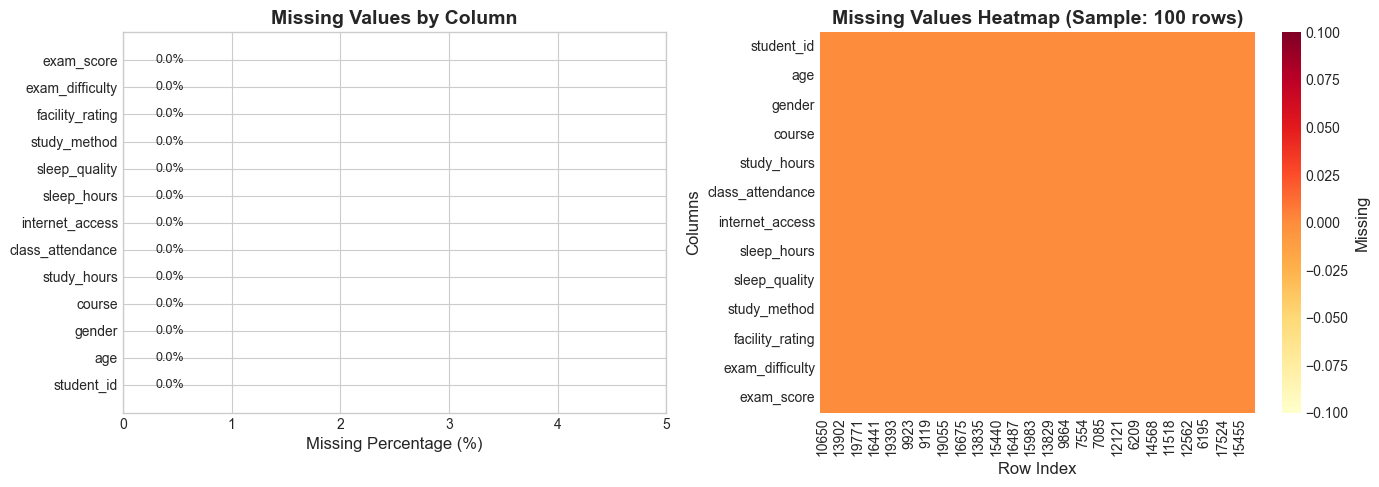


📊 Total Missing Values: 0 (0.00% of all data)


In [106]:
# Missing Values Analysis
print("=" * 60)
print("MISSING VALUES ANALYSIS")
print("=" * 60)

missing_data = pd.DataFrame({
    'Column': df.columns,
    'Missing Count': df.isna().sum().values,
    'Missing %': (df.isna().sum().values / len(df) * 100).round(2),
    'Present Count': df.notna().sum().values,
    'Present %': (df.notna().sum().values / len(df) * 100).round(2)
})
missing_data = missing_data.sort_values('Missing %', ascending=False)
missing_data.index = range(1, len(missing_data) + 1)

# Only show columns with missing values if any
if missing_data['Missing Count'].sum() > 0:
    print("\n⚠️ Columns with Missing Values:")
    display(missing_data[missing_data['Missing Count'] > 0])
else:
    print("\n✅ No missing values found in the dataset!")
    
display(missing_data)

# Visualize missing values
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot of missing values
ax1 = axes[0]
colors = ['#C73E1D' if x > 0 else '#2E86AB' for x in missing_data['Missing Count'].values]
bars = ax1.barh(missing_data['Column'], missing_data['Missing %'], color=colors)
ax1.set_xlabel('Missing Percentage (%)')
ax1.set_title('Missing Values by Column', fontweight='bold', fontsize=14)
ax1.set_xlim(0, max(missing_data['Missing %'].max() * 1.1, 5))
for i, (bar, pct) in enumerate(zip(bars, missing_data['Missing %'].values)):
    ax1.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2, 
             f'{pct:.1f}%', va='center', fontsize=9)

# Heatmap of missing values (sample if large dataset)
ax2 = axes[1]
sample_size = min(100, len(df))
df_sample = df.sample(sample_size, random_state=42) if len(df) > sample_size else df
sns.heatmap(df_sample.isna().T, cbar=True, cmap='YlOrRd', ax=ax2,
            yticklabels=df.columns, cbar_kws={'label': 'Missing'})
ax2.set_title(f'Missing Values Heatmap (Sample: {sample_size} rows)', fontweight='bold', fontsize=14)
ax2.set_xlabel('Row Index')
ax2.set_ylabel('Columns')

plt.tight_layout()
plt.show()

print(f"\n📊 Total Missing Values: {df.isna().sum().sum():,} ({(df.isna().sum().sum() / df.size * 100):.2f}% of all data)")


## 3. Numerical Features Analysis

For each numerical feature, we display:
- **Summary Statistics**: Mean, median, std, min, max, skewness, kurtosis
- **Histogram with KDE**: Distribution visualization
- **Box Plot**: Outlier detection
- **QQ Plot**: Normality assessment with Shapiro-Wilk test



In [107]:
# Function to analyze numerical features with 4-panel figure
def analyze_numerical_feature(data, column, color='#2E86AB'):
    """
    Create a comprehensive 4-panel analysis for a numerical feature.
    """
    fig = plt.figure(figsize=(14, 10))
    
    # Create grid for subplots
    gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)
    
    # Get clean data (remove NaN)
    clean_data = data[column].dropna()
    
    # ============ Panel 1: Summary Statistics (Top-Left) ============
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.axis('off')
    
    # Calculate statistics
    stats_dict = {
        'Count': f'{len(clean_data):,}',
        'Mean': f'{clean_data.mean():.4f}',
        'Median': f'{clean_data.median():.4f}',
        'Std Dev': f'{clean_data.std():.4f}',
        'Min': f'{clean_data.min():.4f}',
        'Max': f'{clean_data.max():.4f}',
        'Range': f'{clean_data.max() - clean_data.min():.4f}',
        'Skewness': f'{clean_data.skew():.4f}',
        'Kurtosis': f'{clean_data.kurtosis():.4f}',
        'Q1 (25%)': f'{clean_data.quantile(0.25):.4f}',
        'Q3 (75%)': f'{clean_data.quantile(0.75):.4f}',
        'IQR': f'{clean_data.quantile(0.75) - clean_data.quantile(0.25):.4f}'
    }
    
    # Create table
    table_data = [[k, v] for k, v in stats_dict.items()]
    table = ax1.table(cellText=table_data, colLabels=['Statistic', 'Value'],
                      loc='center', cellLoc='left',
                      colColours=[color, color])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    
    # Style table header
    for (row, col), cell in table.get_celld().items():
        if row == 0:
            cell.set_text_props(fontweight='bold', color='white')
        cell.set_edgecolor('#cccccc')
    
    ax1.set_title('Summary Statistics', fontweight='bold', fontsize=12, pad=20)
    
    # ============ Panel 2: Histogram with KDE (Top-Right) ============
    ax2 = fig.add_subplot(gs[0, 1])
    sns.histplot(clean_data, kde=True, ax=ax2, color=color, edgecolor='white', alpha=0.7)
    ax2.axvline(clean_data.mean(), color='#C73E1D', linestyle='--', linewidth=2, label=f'Mean: {clean_data.mean():.2f}')
    ax2.axvline(clean_data.median(), color='#F18F01', linestyle='-.', linewidth=2, label=f'Median: {clean_data.median():.2f}')
    ax2.set_title('Distribution (Histogram + KDE)', fontweight='bold', fontsize=12)
    ax2.set_xlabel(column)
    ax2.set_ylabel('Frequency')
    ax2.legend(loc='upper right', fontsize=9)
    
    # ============ Panel 3: Box Plot (Bottom-Left) ============
    ax3 = fig.add_subplot(gs[1, 0])
    bp = ax3.boxplot(clean_data, vert=True, patch_artist=True, widths=0.5)
    bp['boxes'][0].set_facecolor(color)
    bp['boxes'][0].set_alpha(0.7)
    bp['medians'][0].set_color('#C73E1D')
    bp['medians'][0].set_linewidth(2)
    
    # Annotate outliers count
    Q1 = clean_data.quantile(0.25)
    Q3 = clean_data.quantile(0.75)
    IQR = Q3 - Q1
    outliers = clean_data[(clean_data < Q1 - 1.5 * IQR) | (clean_data > Q3 + 1.5 * IQR)]
    
    ax3.set_title('Box Plot', fontweight='bold', fontsize=12)
    ax3.set_ylabel(column)
    ax3.set_xticklabels([column])
    
    # Add outlier annotation
    outlier_text = f'Outliers: {len(outliers)} ({len(outliers)/len(clean_data)*100:.1f}%)'
    ax3.text(0.95, 0.95, outlier_text, transform=ax3.transAxes, fontsize=10,
             verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # ============ Panel 4: QQ Plot (Bottom-Right) ============
    ax4 = fig.add_subplot(gs[1, 1])
    stats.probplot(clean_data, dist="norm", plot=ax4)
    ax4.get_lines()[0].set_markerfacecolor(color)
    ax4.get_lines()[0].set_markeredgecolor(color)
    ax4.get_lines()[0].set_markersize(4)
    ax4.get_lines()[1].set_color('#C73E1D')
    ax4.set_title('Q-Q Plot (Normal Distribution)', fontweight='bold', fontsize=12)
    
    # Shapiro-Wilk test (sample if data is too large)
    sample_for_test = clean_data.sample(min(5000, len(clean_data)), random_state=42) if len(clean_data) > 5000 else clean_data
    try:
        stat, p_value = shapiro(sample_for_test)
        normality = "Normal" if p_value > 0.05 else "Not Normal"
        normality_text = f'Shapiro-Wilk Test\nStatistic: {stat:.4f}\np-value: {p_value:.4e}\nResult: {normality} (α=0.05)'
    except:
        normality_text = 'Shapiro-Wilk Test\nCould not compute'
    
    ax4.text(0.05, 0.95, normality_text, transform=ax4.transAxes, fontsize=9,
             verticalalignment='top', horizontalalignment='left',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    # Main title
    fig.suptitle(f'Numerical Feature Analysis: {column}', fontweight='bold', fontsize=14, y=1.02)
    
    plt.tight_layout()
    plt.show()
    
    return stats_dict


## 4. Categorical Features Analysis

For each categorical feature, we display:
- **Frequency Table**: Counts and percentages for each category
- **Bar Chart**: Visual distribution of categories


In [108]:
# Function to analyze categorical features
def analyze_categorical_feature(data, column, color='#2E86AB'):
    """
    Create a comprehensive analysis for a categorical feature with frequency table and bar chart.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Get value counts
    value_counts = data[column].value_counts()
    value_pcts = data[column].value_counts(normalize=True) * 100
    
    # ============ Panel 1: Frequency Table (Left) ============
    ax1 = axes[0]
    ax1.axis('off')
    
    # Create frequency table data
    freq_df = pd.DataFrame({
        'Category': value_counts.index,
        'Count': value_counts.values,
        'Percentage': [f'{p:.2f}%' for p in value_pcts.values],
        'Cumulative %': [f'{c:.2f}%' for c in value_pcts.cumsum().values]
    })
    
    # Create table
    table_data = freq_df.values.tolist()
    table = ax1.table(cellText=table_data, 
                      colLabels=['Category', 'Count', 'Percentage', 'Cumulative %'],
                      loc='center', cellLoc='center',
                      colColours=[color]*4)
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    
    # Style table
    for (row, col), cell in table.get_celld().items():
        if row == 0:
            cell.set_text_props(fontweight='bold', color='white')
        cell.set_edgecolor('#cccccc')
    
    ax1.set_title('Frequency Table', fontweight='bold', fontsize=12, pad=20)
    
    # ============ Panel 2: Horizontal Bar Chart (Right) ============
    ax2 = axes[1]
    
    # Sort by count for better visualization
    sorted_idx = value_counts.sort_values().index
    sorted_counts = value_counts[sorted_idx]
    sorted_pcts = value_pcts[sorted_idx]
    
    # Create gradient colors
    n_bars = len(sorted_counts)
    bar_colors = plt.cm.Blues(np.linspace(0.4, 0.9, n_bars))
    
    bars = ax2.barh(range(len(sorted_counts)), sorted_counts.values, color=bar_colors, edgecolor='white')
    ax2.set_yticks(range(len(sorted_counts)))
    ax2.set_yticklabels(sorted_counts.index)
    ax2.set_xlabel('Count')
    ax2.set_title('Distribution Bar Chart', fontweight='bold', fontsize=12)
    
    # Add count and percentage labels on bars
    for i, (bar, count, pct) in enumerate(zip(bars, sorted_counts.values, sorted_pcts.values)):
        ax2.text(bar.get_width() + max(sorted_counts) * 0.02, bar.get_y() + bar.get_height()/2,
                 f'{count:,} ({pct:.1f}%)', va='center', fontsize=9)
    
    # Extend x-axis to fit labels
    ax2.set_xlim(0, max(sorted_counts) * 1.25)
    
    # Add summary stats
    summary_text = f'Total: {len(data[column]):,}\nUnique: {data[column].nunique()}\nMode: {value_counts.index[0]}'
    ax2.text(0.95, 0.05, summary_text, transform=ax2.transAxes, fontsize=10,
             verticalalignment='bottom', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    
    # Main title
    fig.suptitle(f'Categorical Feature Analysis: {column}', fontweight='bold', fontsize=14, y=1.02)
    
    plt.tight_layout()
    plt.show()
    
    return freq_df


CATEGORICAL FEATURES ANALYSIS

📊 Found 7 categorical features to analyze:

  1. gender (3 unique values)
  2. course (7 unique values)
  3. internet_access (2 unique values)
  4. sleep_quality (3 unique values)
  5. study_method (5 unique values)
  6. facility_rating (3 unique values)
  7. exam_difficulty (3 unique values)

Feature 1/7: gender


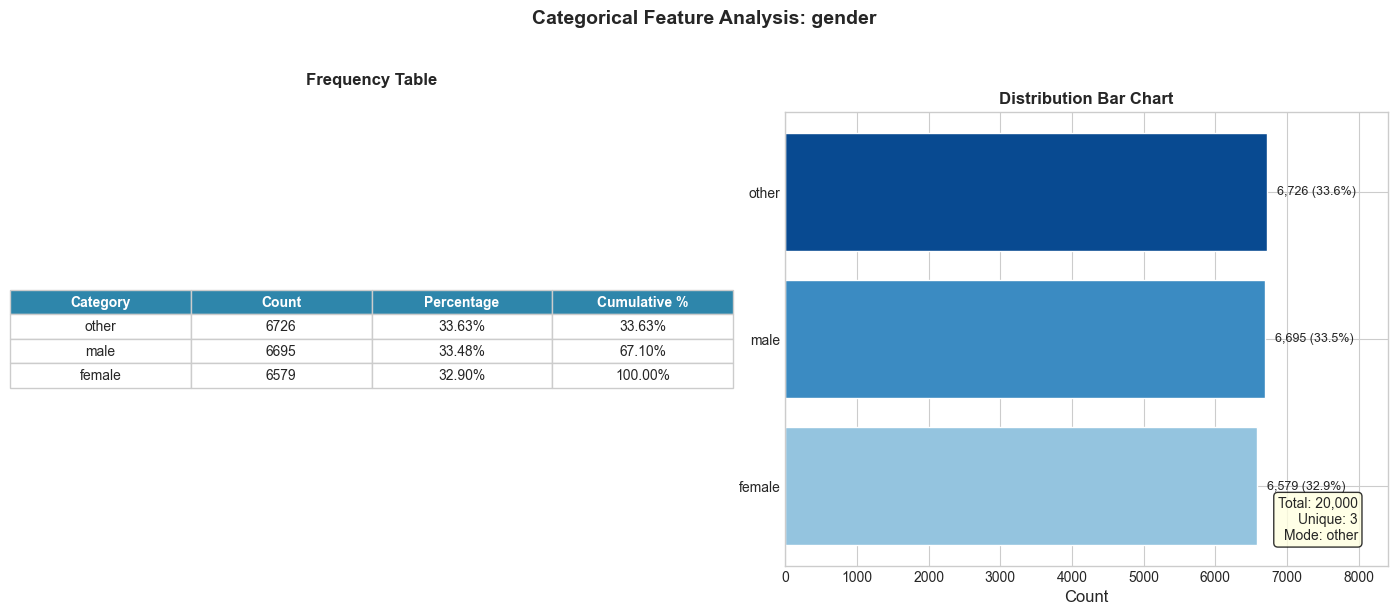


Feature 2/7: course


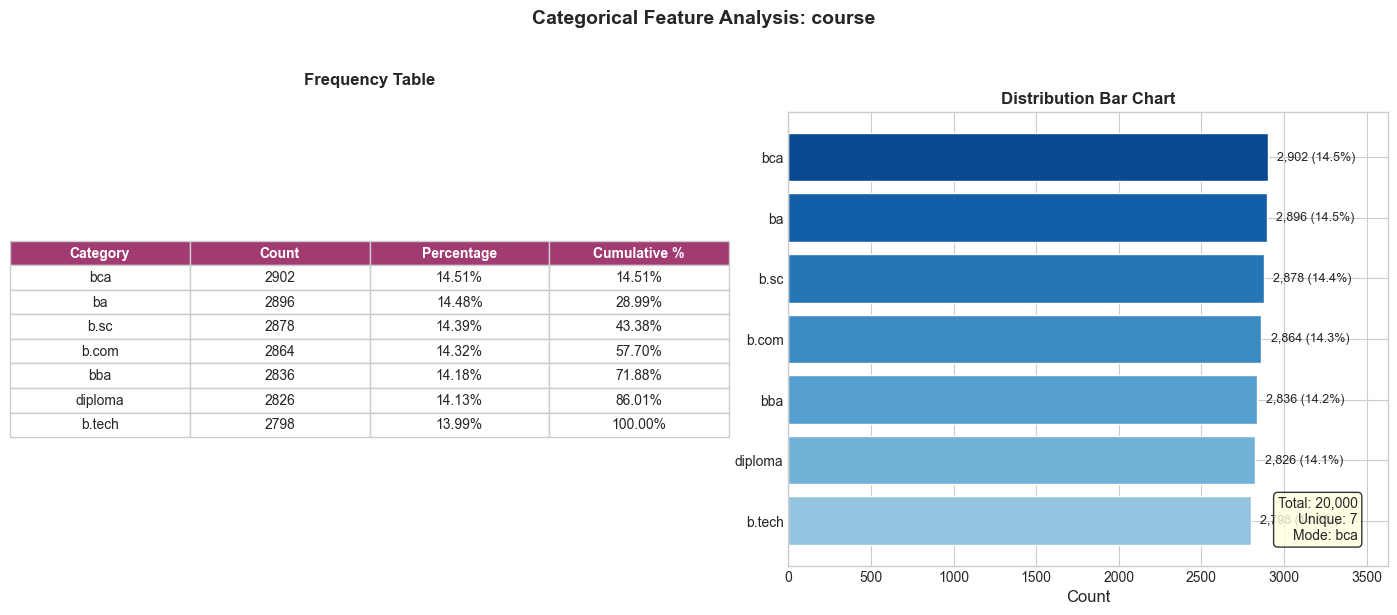


Feature 3/7: internet_access


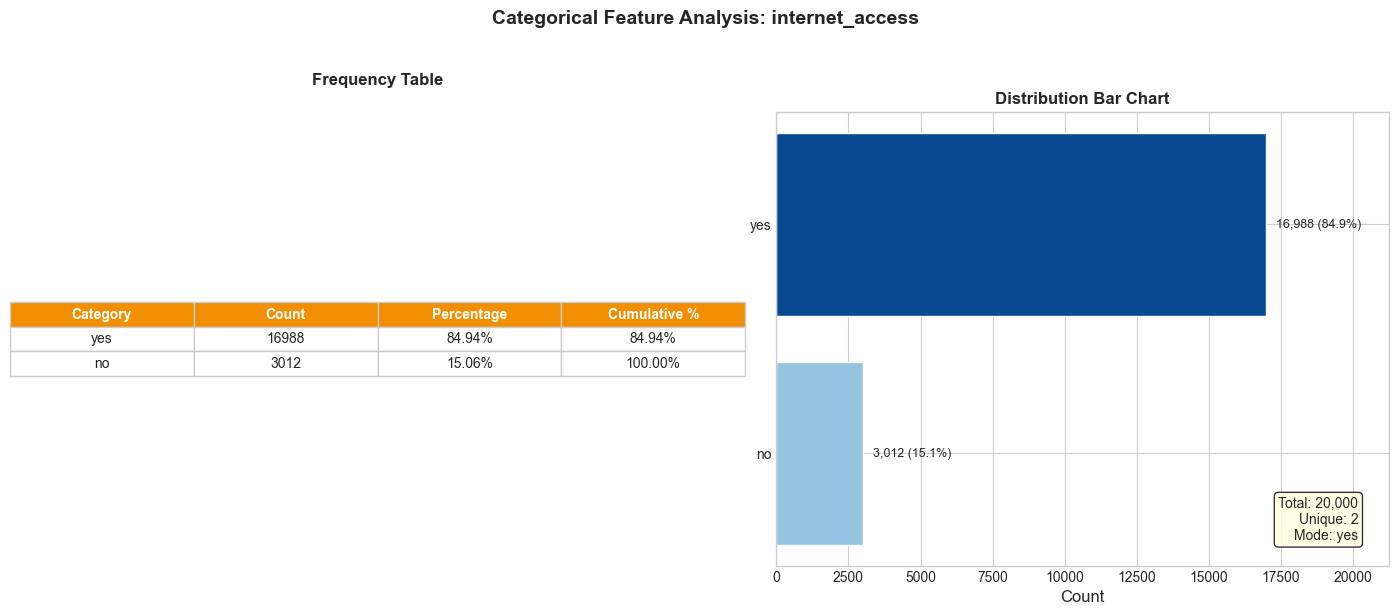


Feature 4/7: sleep_quality


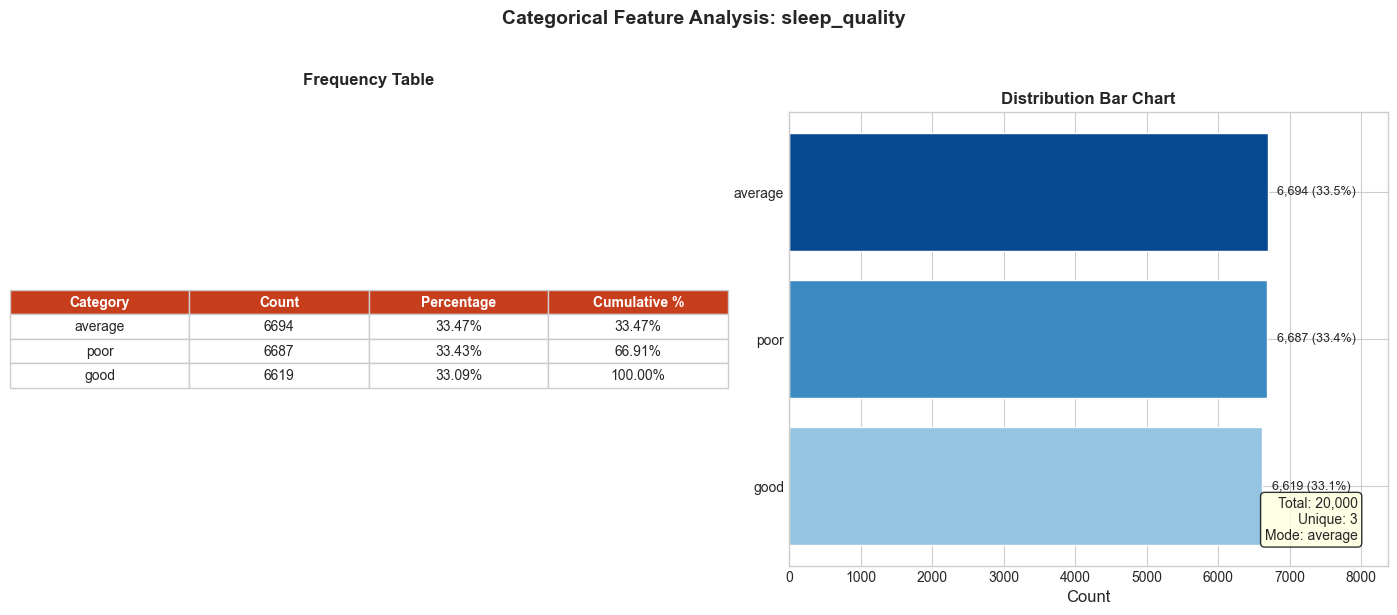


Feature 5/7: study_method


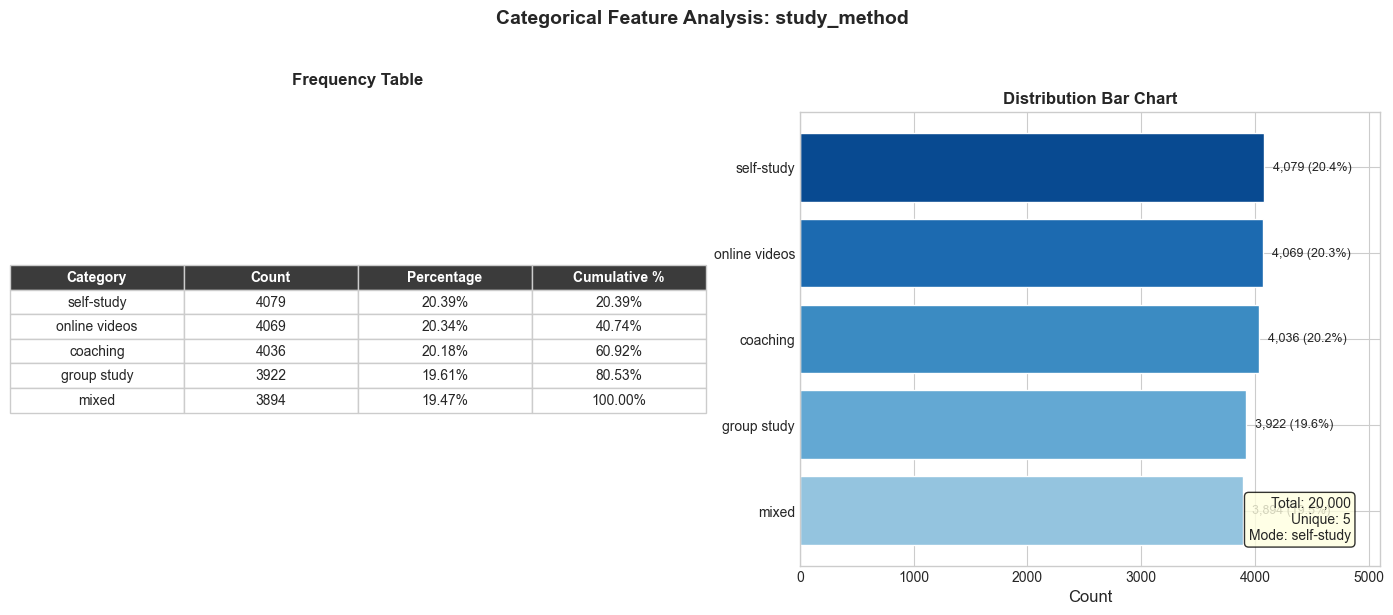


Feature 6/7: facility_rating


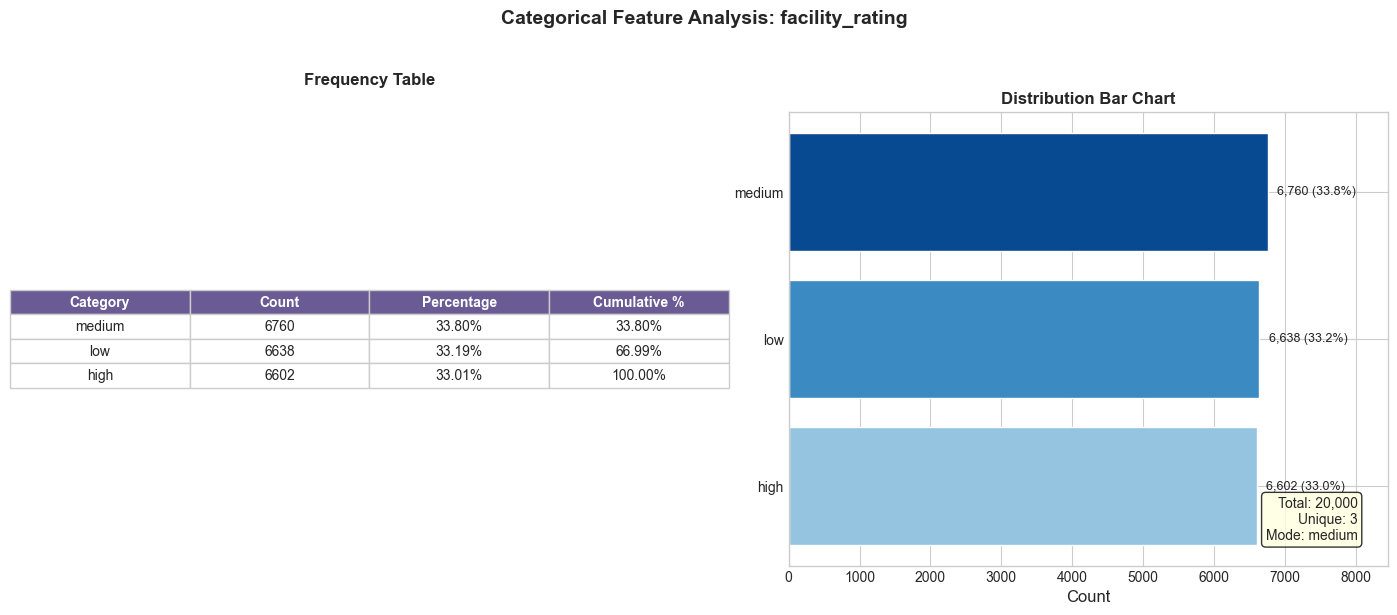


Feature 7/7: exam_difficulty


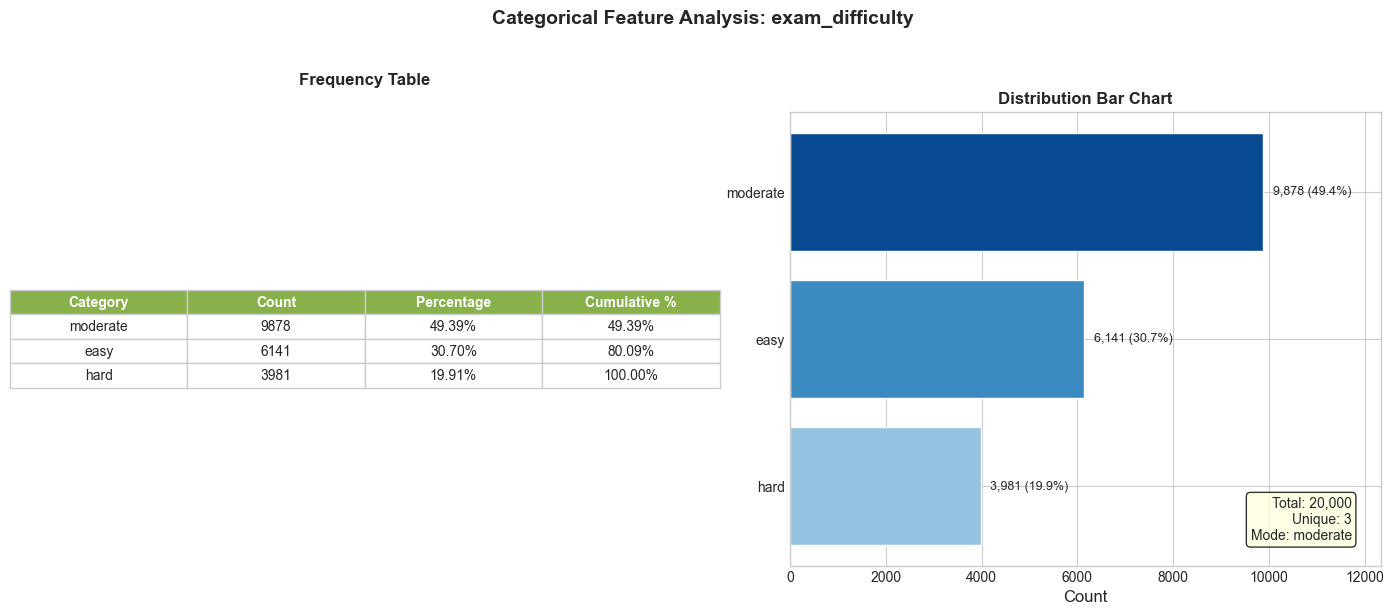

In [109]:
# Analyze all categorical features
print("=" * 60)
print("CATEGORICAL FEATURES ANALYSIS")
print("=" * 60)

# Get categorical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

if len(categorical_cols) == 0:
    print("\n⚠️ No categorical features found in the dataset.")
else:
    print(f"\n📊 Found {len(categorical_cols)} categorical features to analyze:\n")
    for i, col in enumerate(categorical_cols, 1):
        print(f"  {i}. {col} ({df[col].nunique()} unique values)")
    
    # Color palette for variety
    colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#3B3B3B', '#6B5B95', '#88B04B', '#F7CAC9']
    
    # Analyze each categorical feature
    categorical_stats = {}
    for i, col in enumerate(categorical_cols):
        print(f"\n{'='*60}")
        print(f"Feature {i+1}/{len(categorical_cols)}: {col}")
        print("="*60)
        color = colors[i % len(colors)]
        categorical_stats[col] = analyze_categorical_feature(df, col, color=color)


## 5. Correlation Analysis

Analyzing relationships between numerical features:
- **Correlation Matrix Heatmap**: Visualize all pairwise correlations
- **Top Correlations with Target**: Identify most related features to Exam Score
- **Scatter Plots**: Detailed view of top correlated features vs target


CORRELATION ANALYSIS


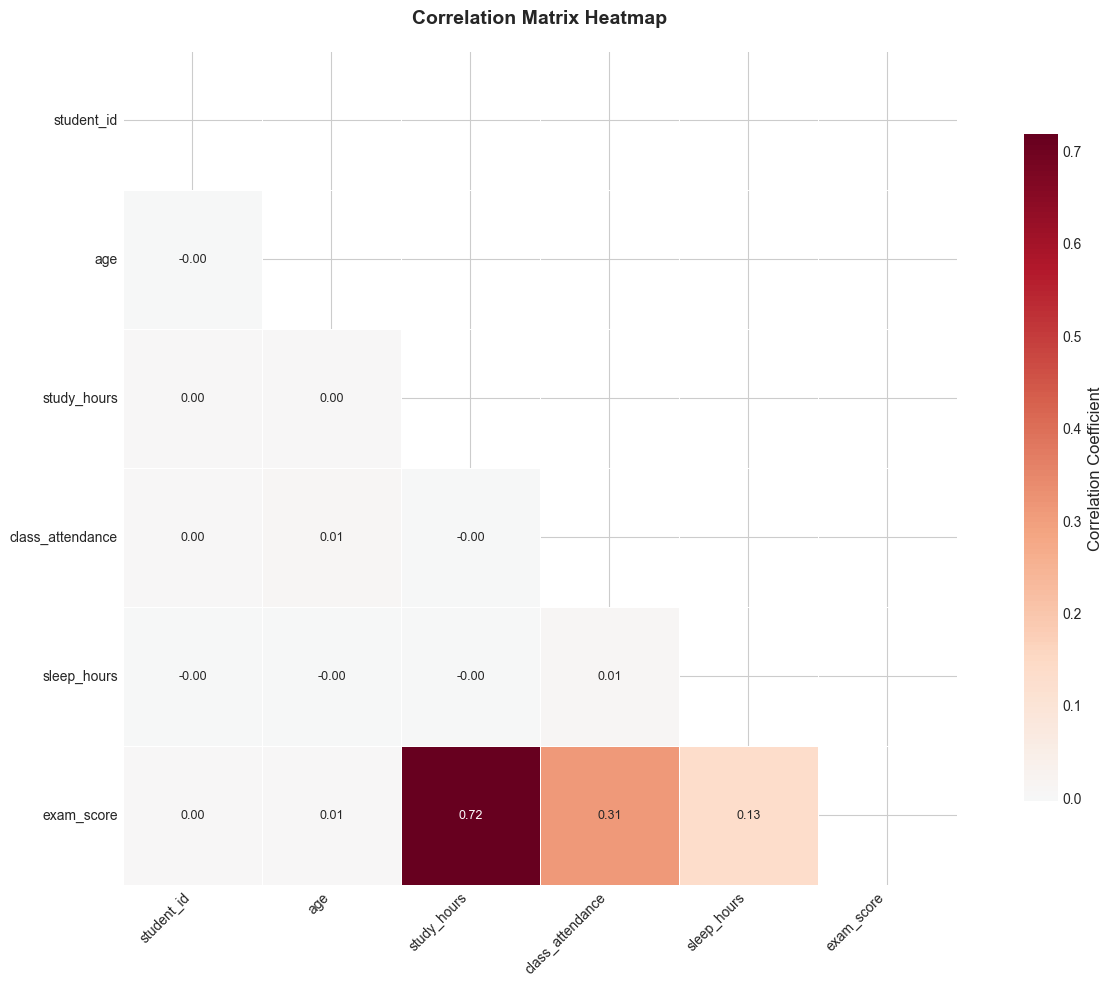


------------------------------------------------------------
TOP CORRELATIONS (Absolute Value)
------------------------------------------------------------

📊 Top 15 Feature Correlations:


Feature 1         Feature 2  Correlation  Abs Correlation
1        study_hours        exam_score     0.717788         0.717788
2   class_attendance        exam_score     0.308850         0.308850
3        sleep_hours        exam_score     0.133222         0.133222
4                age  class_attendance     0.008449         0.008449
5   class_attendance       sleep_hours     0.007187         0.007187
6                age        exam_score     0.006522         0.006522
7        study_hours       sleep_hours    -0.004533         0.004533
8         student_id        exam_score     0.003269         0.003269
9                age       study_hours     0.002955         0.002955
10        student_id               age    -0.002574         0.002574
11        student_id       study_hours     0.002116         0.002116
12       study_hours  class_attendance    -0.001645         0.001645
13        student_id  class_attendance     0.001128         0.001128
14        student_id       sleep_hours    -0.000560         0.000560
15               age       sleep_hours    -0.000385         0.000385

In [110]:
# Correlation Analysis
print("=" * 60)
print("CORRELATION ANALYSIS")
print("=" * 60)

# Get numerical columns for correlation
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

if len(numerical_cols) < 2:
    print("\n⚠️ Not enough numerical features for correlation analysis.")
else:
    # Calculate correlation matrix
    corr_matrix = df[numerical_cols].corr()
    
    # ============ Correlation Heatmap ============
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Create mask for upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    # Create heatmap
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
                center=0, square=True, linewidths=0.5, ax=ax,
                cbar_kws={'label': 'Correlation Coefficient', 'shrink': 0.8},
                annot_kws={'size': 9})
    
    ax.set_title('Correlation Matrix Heatmap', fontweight='bold', fontsize=14, pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # ============ Top Correlations Table ============
    print("\n" + "-" * 60)
    print("TOP CORRELATIONS (Absolute Value)")
    print("-" * 60)
    
    # Get all correlations as pairs
    corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_pairs.append({
                'Feature 1': corr_matrix.columns[i],
                'Feature 2': corr_matrix.columns[j],
                'Correlation': corr_matrix.iloc[i, j]
            })
    
    corr_df = pd.DataFrame(corr_pairs)
    corr_df['Abs Correlation'] = corr_df['Correlation'].abs()
    corr_df = corr_df.sort_values('Abs Correlation', ascending=False)
    corr_df.index = range(1, len(corr_df) + 1)
    
    print("\n📊 Top 15 Feature Correlations:")
    display(corr_df.head(15))


TARGET VARIABLE CORRELATIONS

🎯 Identified Target Variable: exam_score

📊 Correlations with exam_score:


Feature  Correlation  Abs Correlation     Strength
1       study_hours     0.717788         0.717788  Very Strong
2  class_attendance     0.308850         0.308850     Moderate
3       sleep_hours     0.133222         0.133222         Weak
4               age     0.006522         0.006522         Weak
5        student_id     0.003269         0.003269         Weak

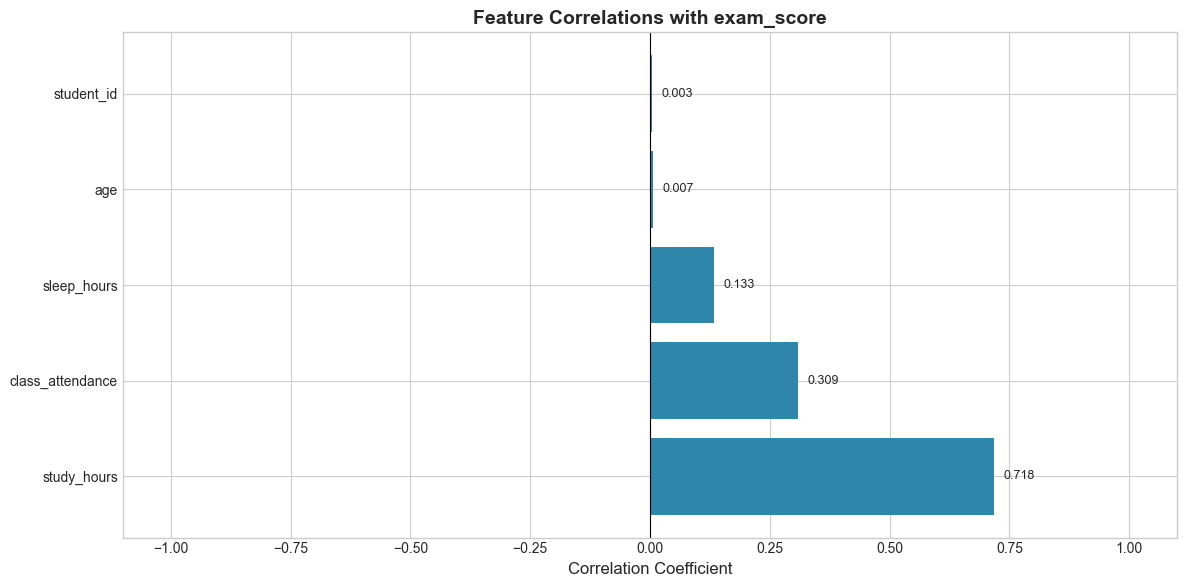


SCATTER PLOTS: Top 4 Correlated Features vs exam_score


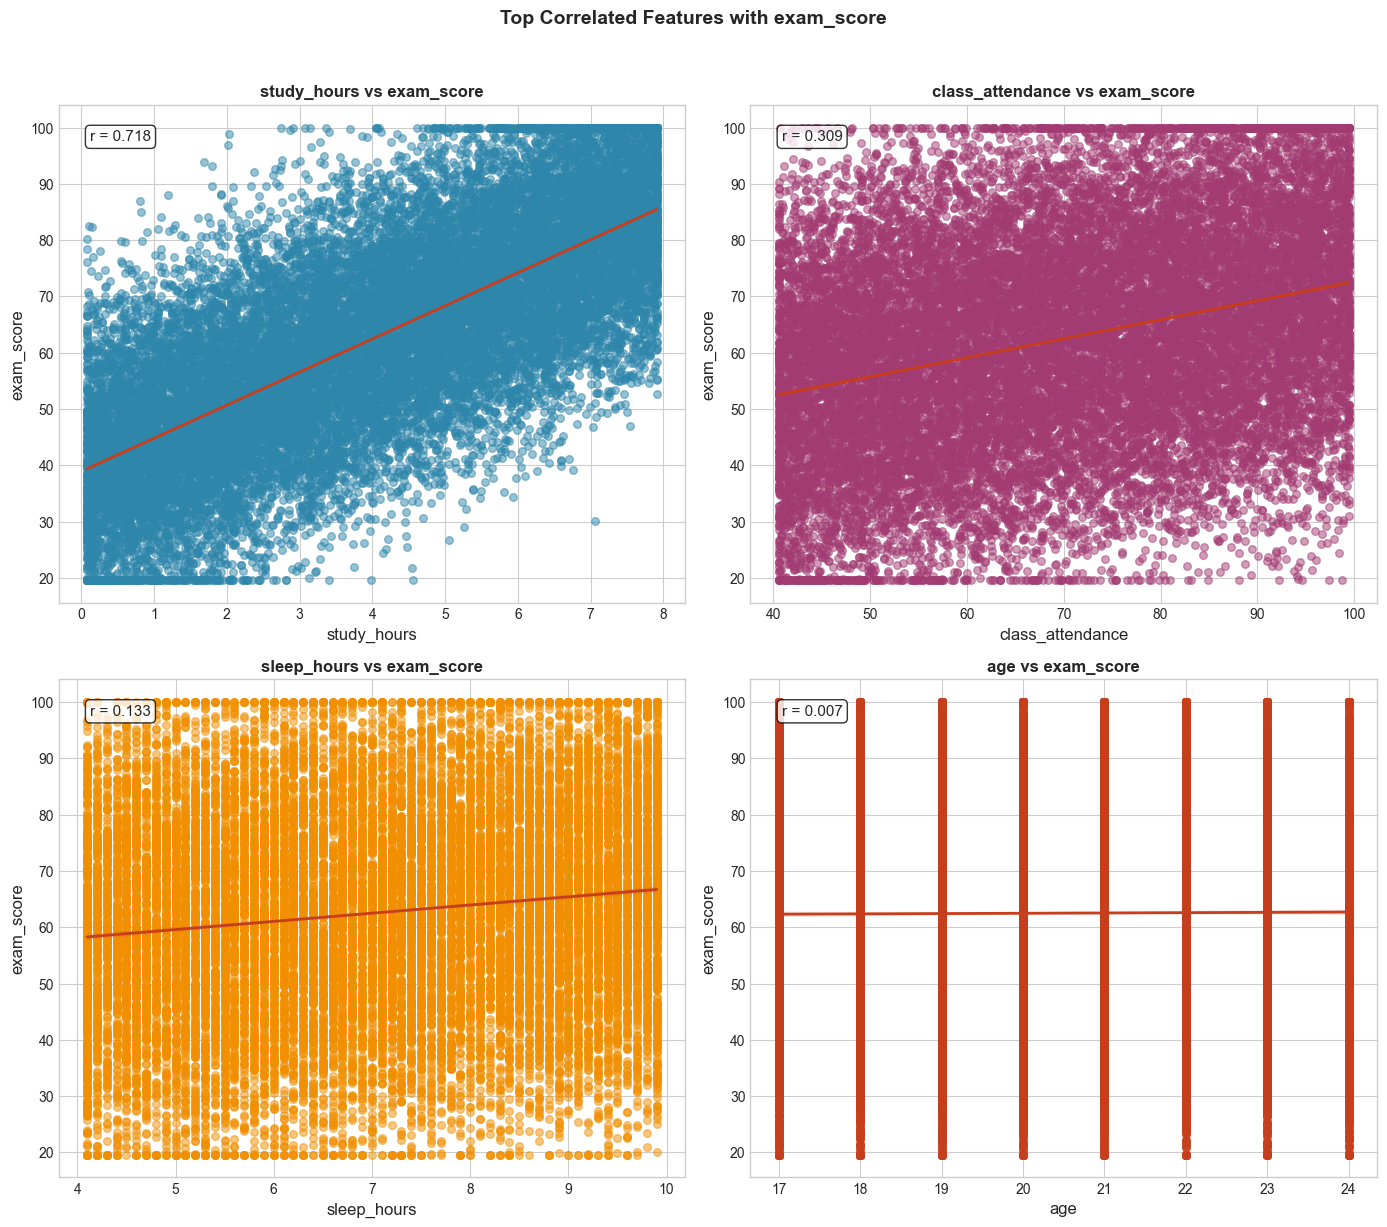

In [111]:
# Find and analyze target variable correlations
print("=" * 60)
print("TARGET VARIABLE CORRELATIONS")
print("=" * 60)

# Try to find the target variable (Exam Score related)
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
target_candidates = [col for col in numerical_cols if 'score' in col.lower() or 'exam' in col.lower() or 'grade' in col.lower()]

if len(target_candidates) > 0:
    target_col = target_candidates[0]
    print(f"\n🎯 Identified Target Variable: {target_col}")
else:
    # Use the last numerical column as target
    target_col = numerical_cols[-1] if numerical_cols else None
    print(f"\n🎯 Using last numerical column as target: {target_col}")

if target_col and len(numerical_cols) > 1:
    # Get correlations with target
    target_corr = corr_matrix[target_col].drop(target_col).sort_values(key=abs, ascending=False)
    
    # Display correlations with target
    target_corr_df = pd.DataFrame({
        'Feature': target_corr.index,
        'Correlation': target_corr.values,
        'Abs Correlation': np.abs(target_corr.values),
        'Strength': pd.cut(np.abs(target_corr.values), 
                          bins=[0, 0.3, 0.5, 0.7, 1.0],
                          labels=['Weak', 'Moderate', 'Strong', 'Very Strong'])
    })
    target_corr_df.index = range(1, len(target_corr_df) + 1)
    
    print(f"\n📊 Correlations with {target_col}:")
    display(target_corr_df)
    
    # Visualize correlations with target
    fig, ax = plt.subplots(figsize=(12, 6))
    colors = ['#C73E1D' if x < 0 else '#2E86AB' for x in target_corr.values]
    bars = ax.barh(target_corr.index, target_corr.values, color=colors)
    ax.axvline(x=0, color='black', linewidth=0.8)
    ax.set_xlabel('Correlation Coefficient')
    ax.set_title(f'Feature Correlations with {target_col}', fontweight='bold', fontsize=14)
    
    # Add correlation values on bars
    for bar, corr_val in zip(bars, target_corr.values):
        x_pos = bar.get_width() + 0.02 if bar.get_width() >= 0 else bar.get_width() - 0.08
        ax.text(x_pos, bar.get_y() + bar.get_height()/2, f'{corr_val:.3f}', 
                va='center', fontsize=9)
    
    ax.set_xlim(-1.1, 1.1)
    plt.tight_layout()
    plt.show()
    
    # ============ Scatter plots for top correlated features ============
    top_features = target_corr.head(4).index.tolist()
    
    if len(top_features) > 0:
        print(f"\n{'='*60}")
        print(f"SCATTER PLOTS: Top {len(top_features)} Correlated Features vs {target_col}")
        print("="*60)
        
        n_plots = min(4, len(top_features))
        fig, axes = plt.subplots(2, 2, figsize=(14, 12))
        axes = axes.flatten()
        
        colors_scatter = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']
        
        for i, feature in enumerate(top_features[:n_plots]):
            ax = axes[i]
            
            # Scatter plot with regression line
            sns.regplot(data=df, x=feature, y=target_col, ax=ax, 
                       scatter_kws={'alpha': 0.5, 'color': colors_scatter[i], 's': 30},
                       line_kws={'color': '#C73E1D', 'linewidth': 2})
            
            # Add correlation annotation
            corr_val = target_corr[feature]
            ax.text(0.05, 0.95, f'r = {corr_val:.3f}', transform=ax.transAxes,
                   fontsize=11, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
            ax.set_title(f'{feature} vs {target_col}', fontweight='bold', fontsize=12)
            ax.set_xlabel(feature)
            ax.set_ylabel(target_col)
        
        # Hide unused subplots
        for j in range(n_plots, 4):
            axes[j].set_visible(False)
        
        plt.suptitle(f'Top Correlated Features with {target_col}', fontweight='bold', fontsize=14, y=1.02)
        plt.tight_layout()
        plt.show()
else:
    print("\n⚠️ Could not identify target variable or not enough features for correlation analysis.")


## 6. Target Variable Deep Dive

Detailed analysis of the Exam Score (target variable):
- **Distribution Analysis**: Comprehensive look at the target variable
- **Group Comparisons**: Mean exam score by categorical features
by   


TARGET VARIABLE DEEP DIVE

🎯 Target Variable: exam_score


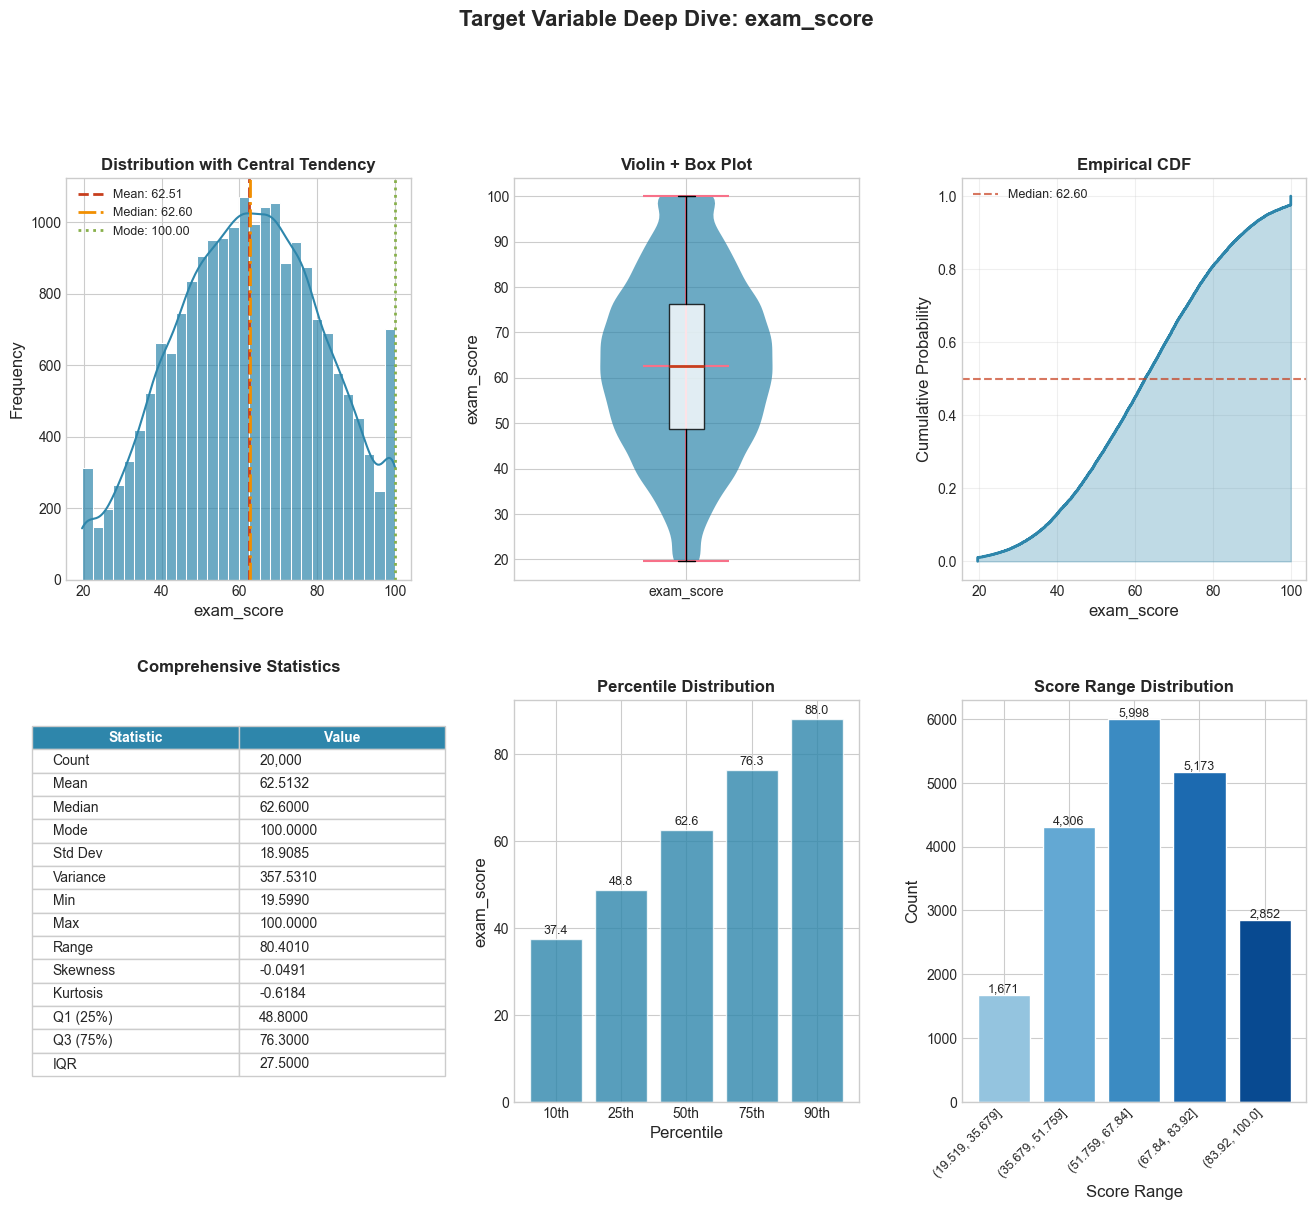

In [112]:
# Target Variable Deep Dive
print("=" * 60)
print("TARGET VARIABLE DEEP DIVE")
print("=" * 60)

# Find the target variable
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
target_candidates = [col for col in numerical_cols if 'score' in col.lower() or 'exam' in col.lower() or 'grade' in col.lower()]

if len(target_candidates) > 0:
    target_col = target_candidates[0]
else:
    target_col = numerical_cols[-1] if numerical_cols else None

if target_col:
    print(f"\n🎯 Target Variable: {target_col}")
    
    # ============ Detailed Distribution Analysis ============
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)
    
    target_data = df[target_col].dropna()
    
    # Panel 1: Histogram with multiple overlays
    ax1 = fig.add_subplot(gs[0, 0])
    sns.histplot(target_data, kde=True, ax=ax1, color='#2E86AB', edgecolor='white', alpha=0.7, bins=30)
    ax1.axvline(target_data.mean(), color='#C73E1D', linestyle='--', linewidth=2, label=f'Mean: {target_data.mean():.2f}')
    ax1.axvline(target_data.median(), color='#F18F01', linestyle='-.', linewidth=2, label=f'Median: {target_data.median():.2f}')
    ax1.axvline(target_data.mode().iloc[0] if len(target_data.mode()) > 0 else target_data.mean(), 
                color='#88B04B', linestyle=':', linewidth=2, label=f'Mode: {target_data.mode().iloc[0]:.2f}' if len(target_data.mode()) > 0 else 'Mode: N/A')
    ax1.set_title('Distribution with Central Tendency', fontweight='bold', fontsize=12)
    ax1.set_xlabel(target_col)
    ax1.set_ylabel('Frequency')
    ax1.legend(fontsize=9)
    
    # Panel 2: Box and Violin plot
    ax2 = fig.add_subplot(gs[0, 1])
    parts = ax2.violinplot(target_data, positions=[0], showmeans=True, showmedians=True)
    parts['bodies'][0].set_facecolor('#2E86AB')
    parts['bodies'][0].set_alpha(0.7)
    ax2.boxplot(target_data, positions=[0], widths=0.1, patch_artist=True,
                boxprops=dict(facecolor='white', alpha=0.8),
                medianprops=dict(color='#C73E1D', linewidth=2))
    ax2.set_title('Violin + Box Plot', fontweight='bold', fontsize=12)
    ax2.set_ylabel(target_col)
    ax2.set_xticks([0])
    ax2.set_xticklabels([target_col])
    
    # Panel 3: ECDF (Empirical Cumulative Distribution)
    ax3 = fig.add_subplot(gs[0, 2])
    sorted_data = np.sort(target_data)
    ecdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    ax3.plot(sorted_data, ecdf, color='#2E86AB', linewidth=2)
    ax3.fill_between(sorted_data, ecdf, alpha=0.3, color='#2E86AB')
    ax3.axhline(0.5, color='#C73E1D', linestyle='--', alpha=0.7, label=f'Median: {target_data.median():.2f}')
    ax3.set_title('Empirical CDF', fontweight='bold', fontsize=12)
    ax3.set_xlabel(target_col)
    ax3.set_ylabel('Cumulative Probability')
    ax3.legend(fontsize=9)
    ax3.grid(True, alpha=0.3)
    
    # Panel 4: Summary Statistics Table
    ax4 = fig.add_subplot(gs[1, 0])
    ax4.axis('off')
    
    stats_dict = {
        'Count': f'{len(target_data):,}',
        'Mean': f'{target_data.mean():.4f}',
        'Median': f'{target_data.median():.4f}',
        'Mode': f'{target_data.mode().iloc[0]:.4f}' if len(target_data.mode()) > 0 else 'N/A',
        'Std Dev': f'{target_data.std():.4f}',
        'Variance': f'{target_data.var():.4f}',
        'Min': f'{target_data.min():.4f}',
        'Max': f'{target_data.max():.4f}',
        'Range': f'{target_data.max() - target_data.min():.4f}',
        'Skewness': f'{target_data.skew():.4f}',
        'Kurtosis': f'{target_data.kurtosis():.4f}',
        'Q1 (25%)': f'{target_data.quantile(0.25):.4f}',
        'Q3 (75%)': f'{target_data.quantile(0.75):.4f}',
        'IQR': f'{target_data.quantile(0.75) - target_data.quantile(0.25):.4f}'
    }
    
    table_data = [[k, v] for k, v in stats_dict.items()]
    table = ax4.table(cellText=table_data, colLabels=['Statistic', 'Value'],
                      loc='center', cellLoc='left',
                      colColours=['#2E86AB', '#2E86AB'])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.4)
    for (row, col), cell in table.get_celld().items():
        if row == 0:
            cell.set_text_props(fontweight='bold', color='white')
        cell.set_edgecolor('#cccccc')
    ax4.set_title('Comprehensive Statistics', fontweight='bold', fontsize=12, pad=20)
    
    # Panel 5: Percentile Distribution
    ax5 = fig.add_subplot(gs[1, 1])
    percentiles = [10, 25, 50, 75, 90]
    percentile_values = [target_data.quantile(p/100) for p in percentiles]
    bars = ax5.bar([f'{p}th' for p in percentiles], percentile_values, color='#2E86AB', edgecolor='white', alpha=0.8)
    ax5.set_title('Percentile Distribution', fontweight='bold', fontsize=12)
    ax5.set_xlabel('Percentile')
    ax5.set_ylabel(target_col)
    for bar, val in zip(bars, percentile_values):
        ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                 f'{val:.1f}', ha='center', va='bottom', fontsize=9)
    
    # Panel 6: Score Distribution Bins
    ax6 = fig.add_subplot(gs[1, 2])
    # Create score bins
    bins = pd.cut(target_data, bins=5)
    bin_counts = bins.value_counts().sort_index()
    colors_bins = plt.cm.Blues(np.linspace(0.4, 0.9, len(bin_counts)))
    bars = ax6.bar(range(len(bin_counts)), bin_counts.values, color=colors_bins, edgecolor='white')
    ax6.set_xticks(range(len(bin_counts)))
    ax6.set_xticklabels([str(interval) for interval in bin_counts.index], rotation=45, ha='right', fontsize=9)
    ax6.set_title('Score Range Distribution', fontweight='bold', fontsize=12)
    ax6.set_xlabel('Score Range')
    ax6.set_ylabel('Count')
    for bar, count in zip(bars, bin_counts.values):
        ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                 f'{count:,}', ha='center', va='bottom', fontsize=9)
    
    fig.suptitle(f'Target Variable Deep Dive: {target_col}', fontweight='bold', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️ Could not identify target variable.")


GROUP COMPARISONS: TARGET BY CATEGORICAL FEATURES

🎯 Comparing exam_score across categorical features



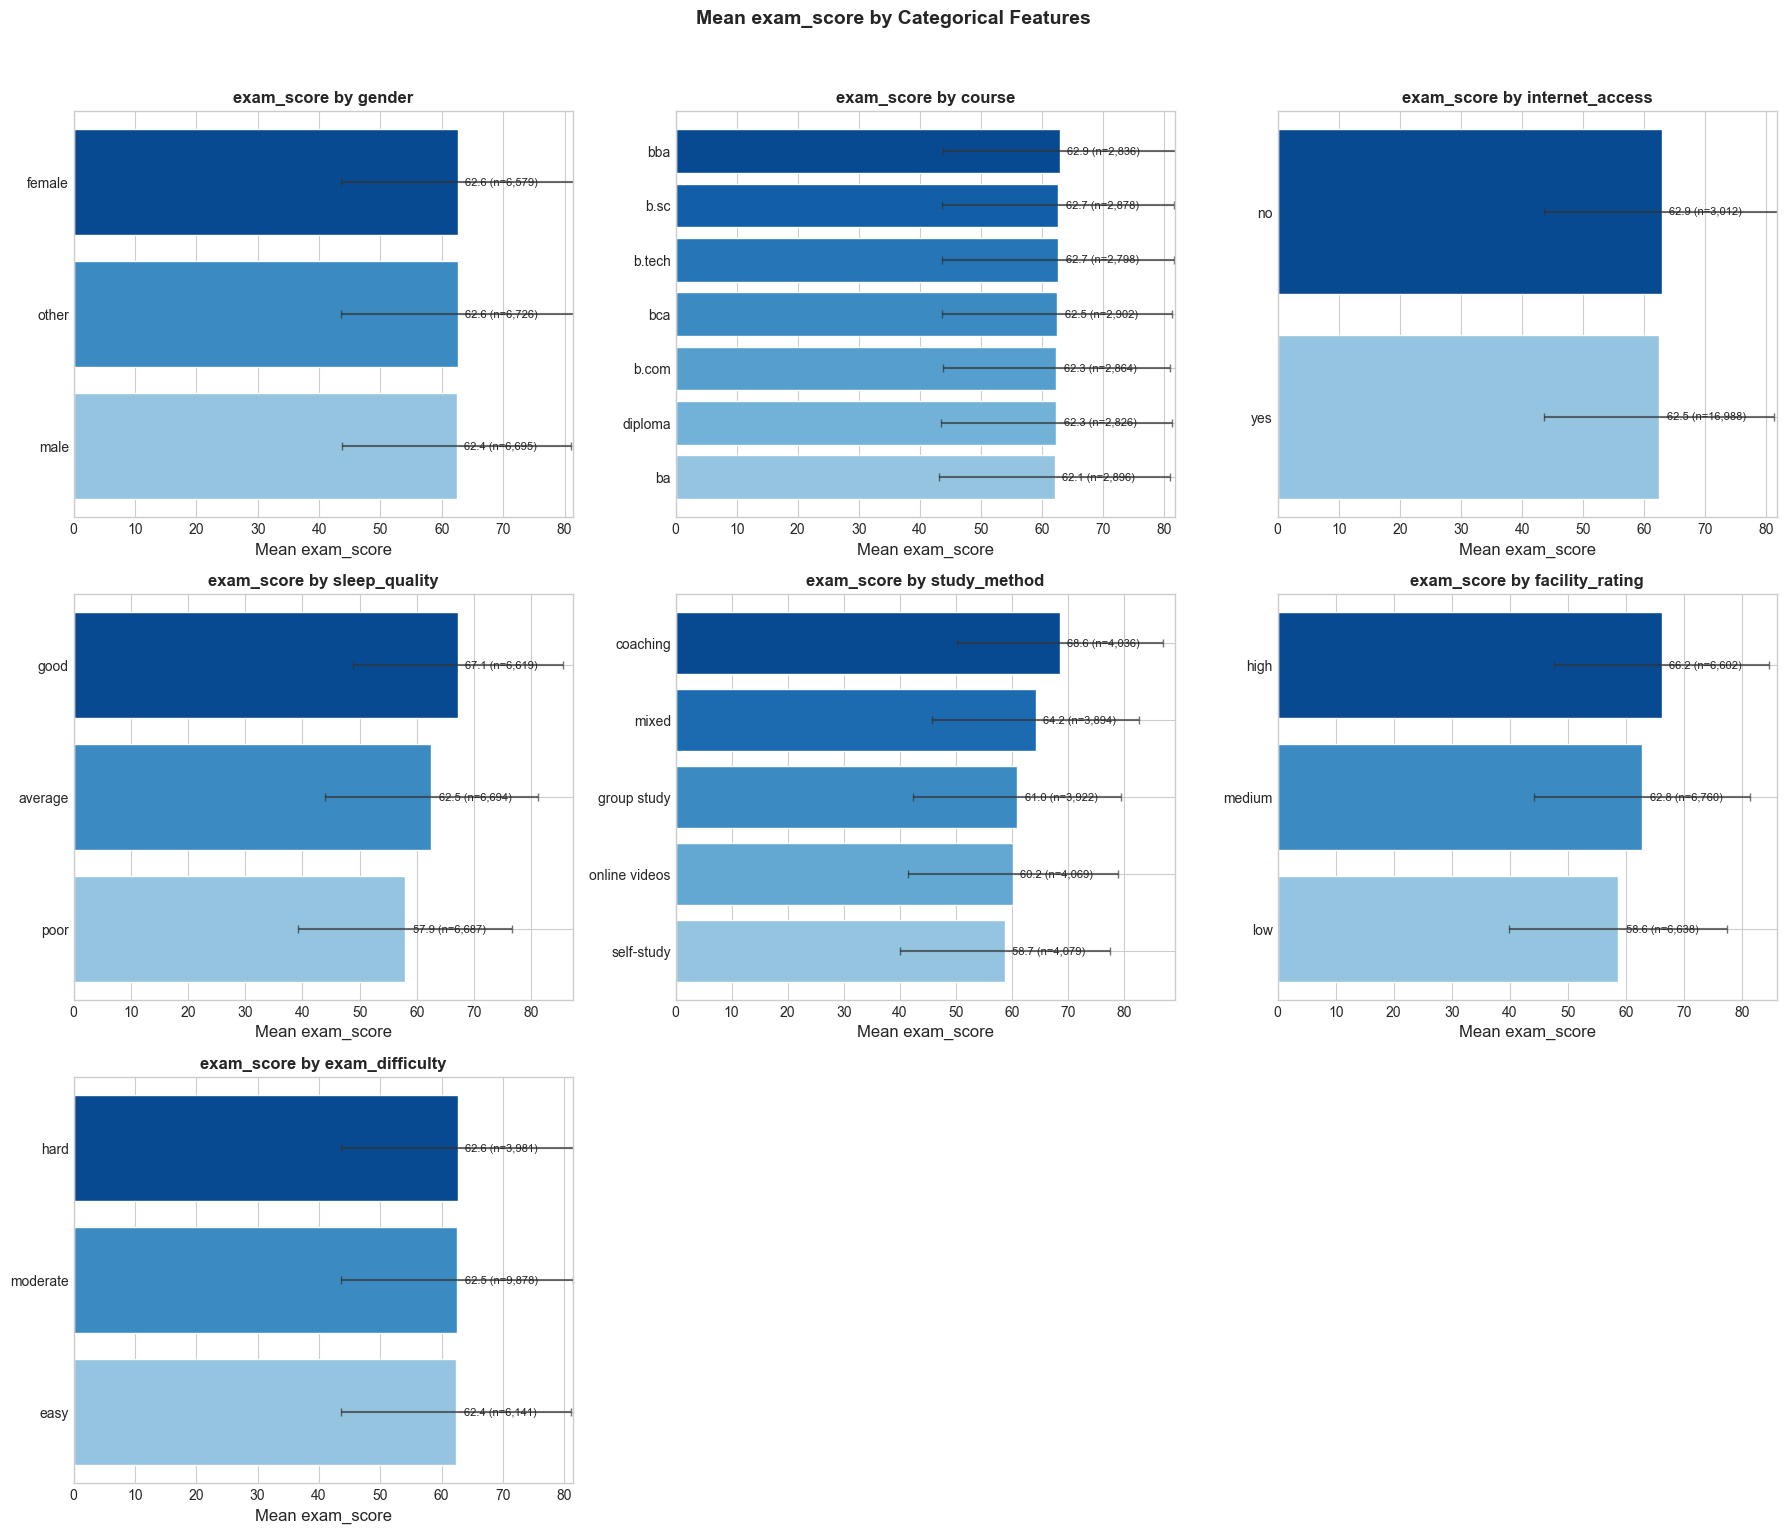


------------------------------------------------------------
SUMMARY: Mean Target by Categories
------------------------------------------------------------

📊 gender:


Mean    Std   Min    Max  Count
gender                                  
female  62.58  19.06  19.6  100.0   6579
other   62.56  18.99  19.6  100.0   6726
male    62.40  18.68  19.6  100.0   6695


📊 course:


Mean    Std   Min    Max  Count
course                                   
bba      62.93  19.10  19.6  100.0   2836
b.sc     62.72  19.01  19.6  100.0   2878
b.tech   62.65  19.00  19.6  100.0   2798
bca      62.52  18.84  19.6  100.0   2902
b.com    62.33  18.61  19.6  100.0   2864
diploma  62.33  18.93  19.6  100.0   2826
ba       62.11  18.89  19.6  100.0   2896


📊 internet_access:


Mean    Std   Min    Max  Count
internet_access                                  
no               62.86  19.20  19.6  100.0   3012
yes              62.45  18.86  19.6  100.0  16988


📊 sleep_quality:


Mean    Std   Min    Max  Count
sleep_quality                                  
good           67.14  18.33  19.6  100.0   6619
average        62.53  18.60  19.6  100.0   6694
poor           57.92  18.66  19.6  100.0   6687


📊 study_method:


Mean    Std   Min    Max  Count
study_method                                   
coaching       68.55  18.42  19.6  100.0   4036
mixed          64.24  18.42  19.6  100.0   3894
group study    60.97  18.53  19.6  100.0   3922
online videos  60.15  18.75  19.6  100.0   4069
self-study     58.73  18.77  19.6  100.0   4079


📊 facility_rating:


Mean    Std   Min    Max  Count
facility_rating                                  
high             66.17  18.55  19.6  100.0   6602
medium           62.79  18.62  19.6  100.0   6760
low              58.59  18.80  19.6  100.0   6638


📊 exam_difficulty:


Mean    Std   Min    Max  Count
exam_difficulty                                  
hard             62.63  19.03  19.6  100.0   3981
moderate         62.55  18.93  19.6  100.0   9878
easy             62.38  18.80  19.6  100.0   6141


END OF EXPLORATORY DATA ANALYSIS


In [113]:
# Group Comparisons: Mean Exam Score by Categorical Features
print("=" * 60)
print("GROUP COMPARISONS: TARGET BY CATEGORICAL FEATURES")
print("=" * 60)

# Get categorical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Find target variable
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
target_candidates = [col for col in numerical_cols if 'score' in col.lower() or 'exam' in col.lower() or 'grade' in col.lower()]
target_col = target_candidates[0] if len(target_candidates) > 0 else (numerical_cols[-1] if numerical_cols else None)

if target_col and len(categorical_cols) > 0:
    print(f"\n🎯 Comparing {target_col} across categorical features\n")
    
    # Limit to categorical columns with reasonable number of categories
    valid_cat_cols = [col for col in categorical_cols if df[col].nunique() <= 15]
    
    if len(valid_cat_cols) > 0:
        # Calculate number of plots needed
        n_cols = min(3, len(valid_cat_cols))
        n_rows = (len(valid_cat_cols) + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
        if n_rows == 1 and n_cols == 1:
            axes = np.array([axes])
        axes = axes.flatten() if hasattr(axes, 'flatten') else [axes]
        
        for i, cat_col in enumerate(valid_cat_cols):
            ax = axes[i]
            
            # Calculate mean target by category
            group_stats = df.groupby(cat_col)[target_col].agg(['mean', 'std', 'count']).sort_values('mean', ascending=True)
            
            # Create bar plot
            colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(group_stats)))
            bars = ax.barh(range(len(group_stats)), group_stats['mean'], color=colors, edgecolor='white')
            
            # Add error bars
            ax.errorbar(group_stats['mean'], range(len(group_stats)), 
                       xerr=group_stats['std'], fmt='none', color='#333333', capsize=3, alpha=0.7)
            
            ax.set_yticks(range(len(group_stats)))
            ax.set_yticklabels(group_stats.index)
            ax.set_xlabel(f'Mean {target_col}')
            ax.set_title(f'{target_col} by {cat_col}', fontweight='bold', fontsize=12)
            
            # Add mean values on bars
            for j, (bar, mean_val, count) in enumerate(zip(bars, group_stats['mean'], group_stats['count'])):
                ax.text(bar.get_width() + max(group_stats['mean']) * 0.02, bar.get_y() + bar.get_height()/2,
                       f'{mean_val:.1f} (n={count:,})', va='center', fontsize=8)
            
            ax.set_xlim(0, max(group_stats['mean']) * 1.3)
        
        # Hide unused subplots
        for j in range(len(valid_cat_cols), len(axes)):
            axes[j].set_visible(False)
        
        plt.suptitle(f'Mean {target_col} by Categorical Features', fontweight='bold', fontsize=14, y=1.02)
        plt.tight_layout()
        plt.show()
        
        # Summary table
        print("\n" + "-" * 60)
        print("SUMMARY: Mean Target by Categories")
        print("-" * 60)
        
        for cat_col in valid_cat_cols:
            print(f"\n📊 {cat_col}:")
            summary = df.groupby(cat_col)[target_col].agg(['mean', 'std', 'min', 'max', 'count'])
            summary = summary.round(2)
            summary.columns = ['Mean', 'Std', 'Min', 'Max', 'Count']
            summary = summary.sort_values('Mean', ascending=False)
            display(summary)
    else:
        print("\n⚠️ No categorical columns with reasonable number of categories (<= 15) found.")
else:
    print("\n⚠️ No categorical features found or target variable not identified.")

print("\n" + "=" * 60)
print("END OF EXPLORATORY DATA ANALYSIS")
print("=" * 60)


# Model Development

## 7. Data Preparation and Splitting

Data splitting strategy:
- **5% Website Holdout**: Reserved for production website testing (never touched during training)
- **Remaining 95%** split into:
  - **70% Training Set**: For model training
  - **20% Validation Set**: For hyperparameter tuning
  - **10% Test Set**: For final evaluation


In [114]:
# Import additional libraries for model development
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

print("=" * 60)
print("DATA PREPARATION FOR MODEL DEVELOPMENT")
print("=" * 60)

# Identify target and features
target_col = 'exam_score'
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols.remove(target_col)  # Remove target from features
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"\n🎯 Target Variable: {target_col}")
print(f"🔢 Numerical Features ({len(numerical_cols)}): {numerical_cols}")
print(f"📝 Categorical Features ({len(categorical_cols)}): {categorical_cols}")

# Prepare features (X) and target (y)
X = df.drop(columns=[target_col])
y = df[target_col]

print(f"\n📊 Total Dataset: {len(df):,} samples")


DATA PREPARATION FOR MODEL DEVELOPMENT

🎯 Target Variable: exam_score
🔢 Numerical Features (5): ['student_id', 'age', 'study_hours', 'class_attendance', 'sleep_hours']
📝 Categorical Features (7): ['gender', 'course', 'internet_access', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty']

📊 Total Dataset: 20,000 samples


In [115]:
# STEP 1: Extract 5% Website Holdout Set
print("=" * 60)
print("STEP 1: WEBSITE HOLDOUT SET (5%)")
print("=" * 60)

X_remaining, X_website, y_remaining, y_website = train_test_split(
    X, y, 
    test_size=0.05,  # 5% for website testing
    random_state=42,
    shuffle=True
)

print(f"\n✅ Website Holdout Set: {len(X_website):,} samples ({len(X_website)/len(X)*100:.1f}%)")
print(f"✅ Remaining for Training: {len(X_remaining):,} samples ({len(X_remaining)/len(X)*100:.1f}%)")

# Save website holdout to CSV for later use
website_holdout = pd.concat([X_website, y_website], axis=1)
website_holdout.to_csv('website_holdout_set.csv', index=False)
print(f"\n💾 Website holdout set saved to 'website_holdout_set.csv'")


STEP 1: WEBSITE HOLDOUT SET (5%)

✅ Website Holdout Set: 1,000 samples (5.0%)
✅ Remaining for Training: 19,000 samples (95.0%)

💾 Website holdout set saved to 'website_holdout_set.csv'


In [116]:
# STEP 2: Split Remaining Data into Train/Validation/Test
# Ratios from remaining 95%: 70% train, 20% validation, 10% test
print("=" * 60)
print("STEP 2: TRAIN/VALIDATION/TEST SPLIT")
print("=" * 60)

# First split: separate test set (10% of remaining = ~9.5% of original)
# test_size = 10 / 100 = 0.1 of remaining
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_remaining, y_remaining,
    test_size=0.10,  # 10% of remaining for test
    random_state=42,
    shuffle=True
)

# Second split: separate validation from training (20% of remaining = ~19% of original)
# validation should be 20/90 = 0.222 of train_val
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.222,  # 20/90 ≈ 0.222 to get 20% of remaining
    random_state=42,
    shuffle=True
)

print(f"\n📊 Split Summary (from remaining {len(X_remaining):,} samples):")
print(f"   ├── Training Set:   {len(X_train):,} samples ({len(X_train)/len(X_remaining)*100:.1f}% of remaining)")
print(f"   ├── Validation Set: {len(X_val):,} samples ({len(X_val)/len(X_remaining)*100:.1f}% of remaining)")
print(f"   └── Test Set:       {len(X_test):,} samples ({len(X_test)/len(X_remaining)*100:.1f}% of remaining)")

print(f"\n📊 Overall Split Summary (from original {len(X):,} samples):")
print(f"   ├── Website Holdout: {len(X_website):,} samples ({len(X_website)/len(X)*100:.1f}%)")
print(f"   ├── Training Set:    {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"   ├── Validation Set:  {len(X_val):,} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"   └── Test Set:        {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")


STEP 2: TRAIN/VALIDATION/TEST SPLIT

📊 Split Summary (from remaining 19,000 samples):
   ├── Training Set:   13,303 samples (70.0% of remaining)
   ├── Validation Set: 3,797 samples (20.0% of remaining)
   └── Test Set:       1,900 samples (10.0% of remaining)

📊 Overall Split Summary (from original 20,000 samples):
   ├── Website Holdout: 1,000 samples (5.0%)
   ├── Training Set:    13,303 samples (66.5%)
   ├── Validation Set:  3,797 samples (19.0%)
   └── Test Set:        1,900 samples (9.5%)


## 8. Feature Preprocessing and PCA Analysis

Before PCA, we need to:
1. **Encode categorical variables** (One-Hot Encoding)
2. **Standardize numerical features** (Z-score normalization)
3. **Perform PCA** on the combined feature set
4. **Interpret principal components** by examining loadings


In [117]:
# STEP 3: Feature Preprocessing
print("=" * 60)
print("STEP 3: FEATURE PREPROCESSING")
print("=" * 60)

# Get feature column names
numerical_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"\n🔢 Numerical Features ({len(numerical_features)}): {numerical_features}")
print(f"📝 Categorical Features ({len(categorical_features)}): {categorical_features}")

# Create preprocessor with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# Fit on training data only (to prevent data leakage)
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)
X_website_processed = preprocessor.transform(X_website)

# Get feature names after preprocessing
num_feature_names = numerical_features
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features).tolist()
all_feature_names = num_feature_names + cat_feature_names

print(f"\n✅ Preprocessing Complete!")
print(f"   Original features: {X_train.shape[1]}")
print(f"   After One-Hot Encoding: {X_train_processed.shape[1]}")
print(f"\n📋 All Feature Names After Encoding:")
for i, name in enumerate(all_feature_names, 1):
    print(f"   {i:2d}. {name}")


STEP 3: FEATURE PREPROCESSING

🔢 Numerical Features (5): ['student_id', 'age', 'study_hours', 'class_attendance', 'sleep_hours']
📝 Categorical Features (7): ['gender', 'course', 'internet_access', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty']



✅ Preprocessing Complete!
   Original features: 12
   After One-Hot Encoding: 31

📋 All Feature Names After Encoding:
    1. student_id
    2. age
    3. study_hours
    4. class_attendance
    5. sleep_hours
    6. gender_female
    7. gender_male
    8. gender_other
    9. course_b.com
   10. course_b.sc
   11. course_b.tech
   12. course_ba
   13. course_bba
   14. course_bca
   15. course_diploma
   16. internet_access_no
   17. internet_access_yes
   18. sleep_quality_average
   19. sleep_quality_good
   20. sleep_quality_poor
   21. study_method_coaching
   22. study_method_group study
   23. study_method_mixed
   24. study_method_online videos
   25. study_method_self-study
   26. facility_rating_high
   27. facility_rating_low
   28. facility_rating_medium
   29. exam_difficulty_easy
   30. exam_difficulty_hard
   31. exam_difficulty_moderate


In [118]:
# STEP 4: PCA Analysis
print("=" * 60)
print("STEP 4: PRINCIPAL COMPONENT ANALYSIS (PCA)")
print("=" * 60)

# Fit PCA with all components first to analyze variance
pca_full = PCA()
pca_full.fit(X_train_processed)

# Calculate cumulative variance explained
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Find number of components for different variance thresholds
n_95 = np.argmax(cumulative_variance >= 0.95) + 1
n_90 = np.argmax(cumulative_variance >= 0.90) + 1
n_80 = np.argmax(cumulative_variance >= 0.80) + 1

print(f"\n📊 Variance Explained Analysis:")
print(f"   Total components: {len(pca_full.explained_variance_ratio_)}")
print(f"   Components for 80% variance: {n_80}")
print(f"   Components for 90% variance: {n_90}")
print(f"   Components for 95% variance: {n_95}")

# Detailed variance breakdown
print(f"\n📋 Variance Explained by First 10 Components:")
variance_df = pd.DataFrame({
    'PC': [f'PC{i+1}' for i in range(min(10, len(pca_full.explained_variance_ratio_)))],
    'Variance Ratio': pca_full.explained_variance_ratio_[:10],
    'Variance %': (pca_full.explained_variance_ratio_[:10] * 100).round(2),
    'Cumulative %': (cumulative_variance[:10] * 100).round(2)
})
variance_df.index = range(1, len(variance_df) + 1)
display(variance_df)


STEP 4: PRINCIPAL COMPONENT ANALYSIS (PCA)

📊 Variance Explained Analysis:
   Total components: 31
   Components for 80% variance: 13
   Components for 90% variance: 18
   Components for 95% variance: 21

📋 Variance Explained by First 10 Components:


PC  Variance Ratio  Variance %  Cumulative %
1    PC1        0.107025       10.70         10.70
2    PC2        0.105671       10.57         21.27
3    PC3        0.104594       10.46         31.73
4    PC4        0.103812       10.38         42.11
5    PC5        0.103347       10.33         52.44
6    PC6        0.040947        4.09         56.54
7    PC7        0.035877        3.59         60.13
8    PC8        0.035700        3.57         63.70
9    PC9        0.035104        3.51         67.21
10  PC10        0.034611        3.46         70.67

PCA VARIANCE VISUALIZATION


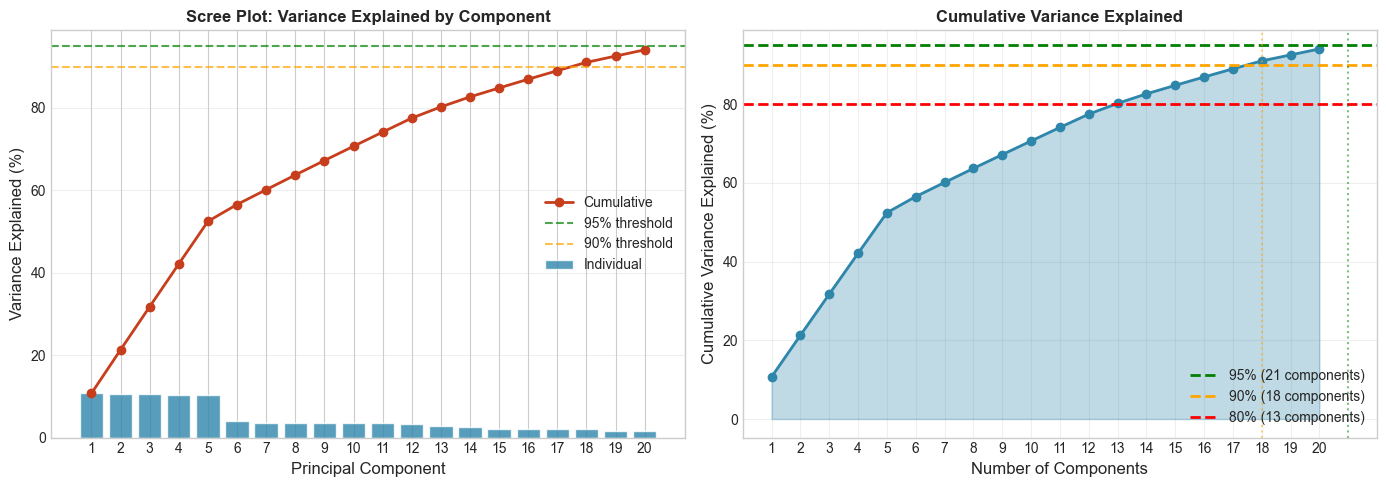

In [119]:
# Visualize PCA Variance Explained
print("=" * 60)
print("PCA VARIANCE VISUALIZATION")
print("=" * 60)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scree Plot (Elbow Plot)
ax1 = axes[0]
n_components_to_show = min(20, len(pca_full.explained_variance_ratio_))
x_range = range(1, n_components_to_show + 1)
ax1.bar(x_range, pca_full.explained_variance_ratio_[:n_components_to_show] * 100, 
        color='#2E86AB', edgecolor='white', alpha=0.8, label='Individual')
ax1.plot(x_range, cumulative_variance[:n_components_to_show] * 100, 
         'o-', color='#C73E1D', linewidth=2, markersize=6, label='Cumulative')
ax1.axhline(y=95, color='green', linestyle='--', alpha=0.7, label='95% threshold')
ax1.axhline(y=90, color='orange', linestyle='--', alpha=0.7, label='90% threshold')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Variance Explained (%)')
ax1.set_title('Scree Plot: Variance Explained by Component', fontweight='bold', fontsize=12)
ax1.legend(loc='center right')
ax1.set_xticks(x_range)
ax1.grid(axis='y', alpha=0.3)

# Cumulative Variance Plot
ax2 = axes[1]
ax2.fill_between(x_range, cumulative_variance[:n_components_to_show] * 100, 
                 alpha=0.3, color='#2E86AB')
ax2.plot(x_range, cumulative_variance[:n_components_to_show] * 100, 
         'o-', color='#2E86AB', linewidth=2, markersize=6)
ax2.axhline(y=95, color='green', linestyle='--', linewidth=2, label=f'95% ({n_95} components)')
ax2.axhline(y=90, color='orange', linestyle='--', linewidth=2, label=f'90% ({n_90} components)')
ax2.axhline(y=80, color='red', linestyle='--', linewidth=2, label=f'80% ({n_80} components)')
ax2.axvline(x=n_95, color='green', linestyle=':', alpha=0.5)
ax2.axvline(x=n_90, color='orange', linestyle=':', alpha=0.5)
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Cumulative Variance Explained (%)')
ax2.set_title('Cumulative Variance Explained', fontweight='bold', fontsize=12)
ax2.legend(loc='lower right')
ax2.set_xticks(x_range)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [120]:
# STEP 5: Interpret Principal Components (Loadings Analysis)
print("=" * 60)
print("STEP 5: PRINCIPAL COMPONENT INTERPRETATION")
print("=" * 60)

# Get loadings (component weights)
loadings = pca_full.components_

# Create loadings DataFrame
loadings_df = pd.DataFrame(
    loadings.T,
    index=all_feature_names,
    columns=[f'PC{i+1}' for i in range(loadings.shape[0])]
)

# Show loadings for first 5 principal components
n_pcs_to_show = min(5, loadings.shape[0])
print(f"\n📋 Component Loadings (First {n_pcs_to_show} PCs):")
print("(Loadings show how much each original feature contributes to each PC)")
display(loadings_df.iloc[:, :n_pcs_to_show].round(4))

# Identify top contributing features for each PC
print(f"\n📊 Top Contributing Features per Principal Component:")
print("=" * 60)

for i in range(n_pcs_to_show):
    pc_name = f'PC{i+1}'
    pc_loadings = loadings_df[pc_name].abs().sort_values(ascending=False)
    
    print(f"\n🔹 {pc_name} (Explains {pca_full.explained_variance_ratio_[i]*100:.2f}% variance)")
    print("-" * 40)
    
    # Top positive and negative loadings
    top_positive = loadings_df[pc_name].sort_values(ascending=False).head(3)
    top_negative = loadings_df[pc_name].sort_values(ascending=True).head(3)
    
    print("  Top Positive Loadings (feature increases → PC increases):")
    for feat, val in top_positive.items():
        print(f"    + {feat}: {val:.4f}")
    
    print("  Top Negative Loadings (feature increases → PC decreases):")
    for feat, val in top_negative.items():
        print(f"    - {feat}: {val:.4f}")


STEP 5: PRINCIPAL COMPONENT INTERPRETATION

📋 Component Loadings (First 5 PCs):
(Loadings show how much each original feature contributes to each PC)


PC1     PC2     PC3     PC4     PC5
student_id                  0.3709  0.6145 -0.3335  0.2810 -0.5419
age                         0.3993 -0.5487  0.0308  0.7333  0.0119
study_hours                 0.3454  0.4639  0.7041  0.1229  0.3919
class_attendance            0.5252 -0.3247  0.3178 -0.5343 -0.4816
sleep_hours                 0.5546  0.0025 -0.5382 -0.2866  0.5657
gender_female               0.0039 -0.0089 -0.0062 -0.0006 -0.0018
gender_male                -0.0033  0.0137  0.0046  0.0010 -0.0012
gender_other               -0.0006 -0.0049  0.0015 -0.0004  0.0031
course_b.com                0.0028  0.0087 -0.0024  0.0023 -0.0058
course_b.sc                 0.0035  0.0004  0.0006 -0.0033  0.0019
course_b.tech              -0.0016 -0.0075  0.0066  0.0010  0.0003
course_ba                   0.0007 -0.0021 -0.0014 -0.0055 -0.0026
course_bba                  0.0025  0.0036 -0.0020 -0.0020  0.0045
course_bca                 -0.0069 -0.0020  0.0014  0.0045  0.0014
course_diploma             -0.0010 -0.0012 -0.0028  0.0030  0.0002
internet_access_no          0.0041  0.0030 -0.0020  0.0050  0.0034
internet_access_yes        -0.0041 -0.0030  0.0020 -0.0050 -0.0034
sleep_quality_average       0.0029  0.0020 -0.0087 -0.0004 -0.0043
sleep_quality_good          0.0031  0.0074 -0.0086  0.0027  0.0040
sleep_quality_poor         -0.0060 -0.0094  0.0172 -0.0023  0.0002
study_method_coaching      -0.0015 -0.0004 -0.0011 -0.0004 -0.0027
study_method_group study   -0.0018 -0.0004 -0.0064  0.0005 -0.0067
study_method_mixed          0.0049  0.0013  0.0078  0.0040  0.0049
study_method_online videos  0.0006  0.0009  0.0078 -0.0037  0.0015
study_method_self-study    -0.0023 -0.0014 -0.0080 -0.0003  0.0030
facility_rating_high       -0.0005 -0.0005 -0.0001  0.0040 -0.0100
facility_rating_low         0.0037 -0.0028 -0.0076 -0.0026 -0.0027
facility_rating_medium     -0.0032  0.0033  0.0077 -0.0014  0.0127
exam_difficulty_easy       -0.0026  0.0030 -0.0145 -0.0099 -0.0092
exam_difficulty_hard        0.0009  0.0063  0.0034 -0.0052 -0.0001
exam_difficulty_moderate    0.0017 -0.0093  0.0111  0.0151  0.0093


📊 Top Contributing Features per Principal Component:

🔹 PC1 (Explains 10.70% variance)
----------------------------------------
  Top Positive Loadings (feature increases → PC increases):
    + sleep_hours: 0.5546
    + class_attendance: 0.5252
    + age: 0.3993
  Top Negative Loadings (feature increases → PC decreases):
    - course_bca: -0.0069
    - sleep_quality_poor: -0.0060
    - internet_access_yes: -0.0041

🔹 PC2 (Explains 10.57% variance)
----------------------------------------
  Top Positive Loadings (feature increases → PC increases):
    + student_id: 0.6145
    + study_hours: 0.4639
    + gender_male: 0.0137
  Top Negative Loadings (feature increases → PC decreases):
    - age: -0.5487
    - class_attendance: -0.3247
    - sleep_quality_poor: -0.0094

🔹 PC3 (Explains 10.46% variance)
----------------------------------------
  Top Positive Loadings (feature increases → PC increases):
    + study_hours: 0.7041
    + class_attendance: 0.3178
    + age: 0.0308
  Top Negative

PCA LOADINGS HEATMAP


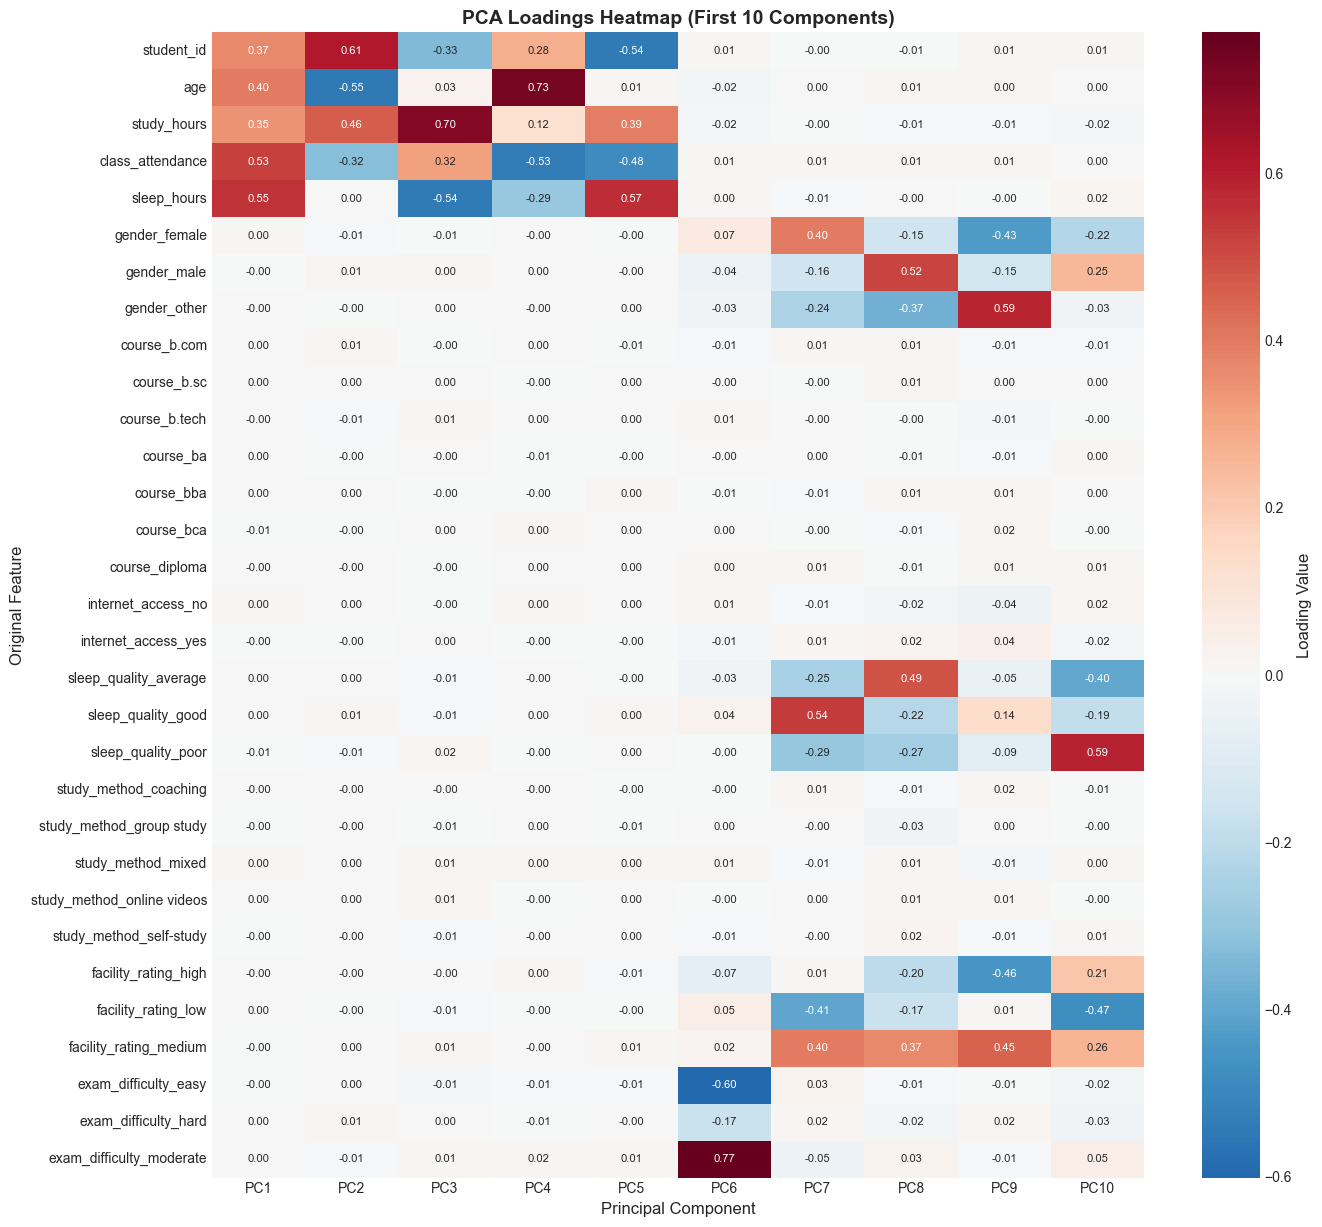

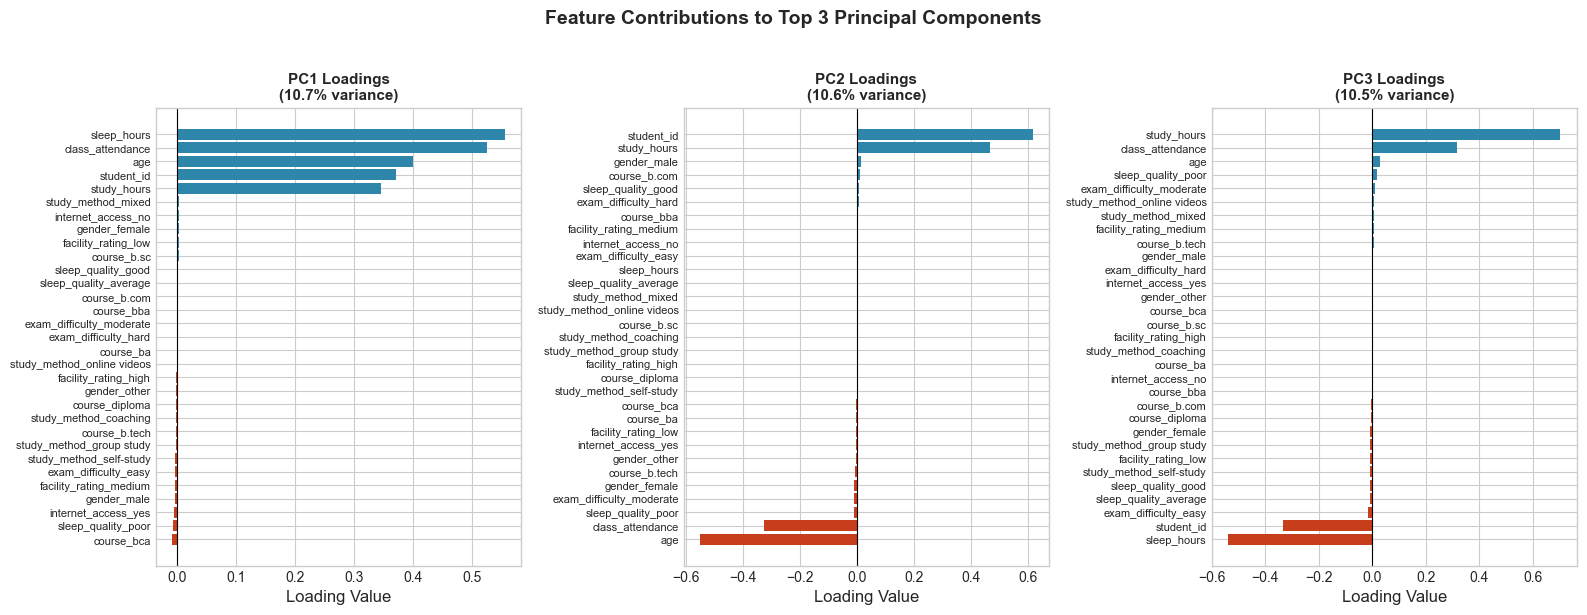

In [121]:
# Visualize PCA Loadings Heatmap
print("=" * 60)
print("PCA LOADINGS HEATMAP")
print("=" * 60)

# Create heatmap of loadings for first 10 PCs
n_pcs_heatmap = min(10, loadings.shape[0])
fig, ax = plt.subplots(figsize=(14, max(10, len(all_feature_names) * 0.4)))

sns.heatmap(loadings_df.iloc[:, :n_pcs_heatmap], 
            annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            ax=ax, cbar_kws={'label': 'Loading Value'},
            annot_kws={'size': 8})

ax.set_title(f'PCA Loadings Heatmap (First {n_pcs_heatmap} Components)', fontweight='bold', fontsize=14)
ax.set_xlabel('Principal Component')
ax.set_ylabel('Original Feature')
plt.tight_layout()
plt.show()

# Bar plot of loadings for top 3 PCs
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

for i in range(min(3, loadings.shape[0])):
    ax = axes[i]
    pc_loadings = loadings_df[f'PC{i+1}'].sort_values()
    colors = ['#C73E1D' if x < 0 else '#2E86AB' for x in pc_loadings.values]
    
    ax.barh(range(len(pc_loadings)), pc_loadings.values, color=colors)
    ax.set_yticks(range(len(pc_loadings)))
    ax.set_yticklabels(pc_loadings.index, fontsize=8)
    ax.axvline(x=0, color='black', linewidth=0.8)
    ax.set_xlabel('Loading Value')
    ax.set_title(f'PC{i+1} Loadings\n({pca_full.explained_variance_ratio_[i]*100:.1f}% variance)', 
                 fontweight='bold', fontsize=11)

plt.suptitle('Feature Contributions to Top 3 Principal Components', fontweight='bold', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


2D PCA VISUALIZATION


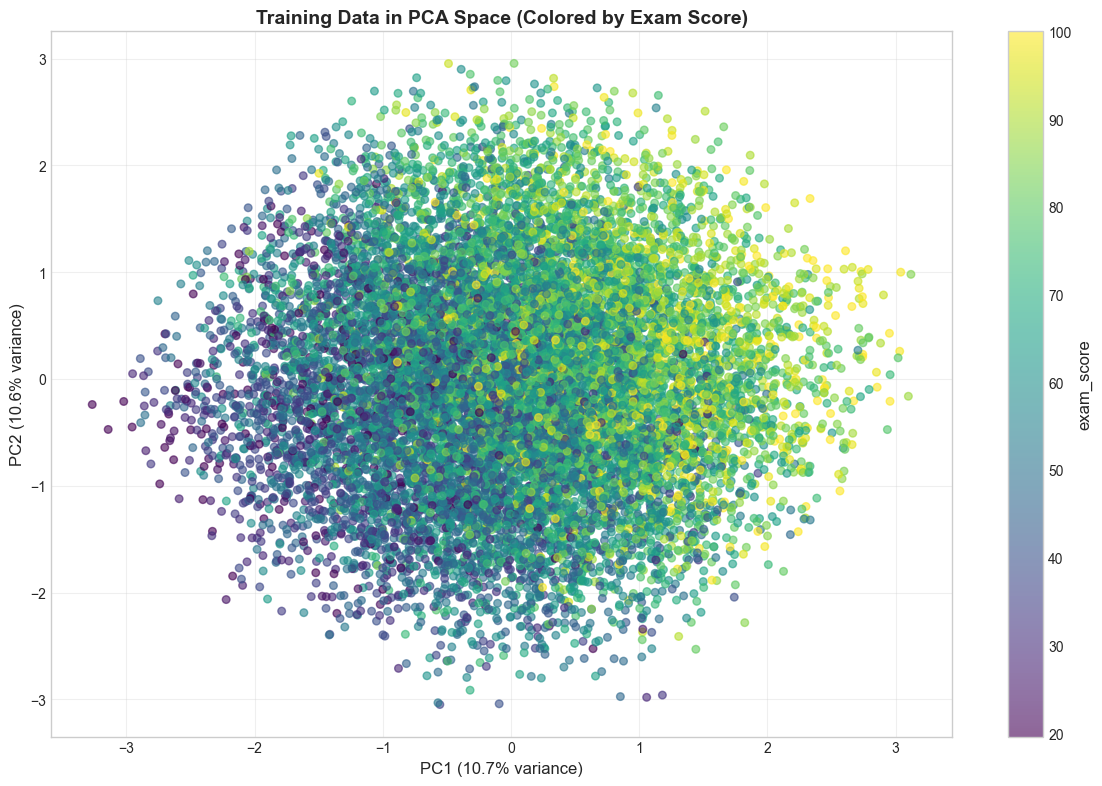

In [122]:
# 2D PCA Visualization (PC1 vs PC2)
print("=" * 60)
print("2D PCA VISUALIZATION")
print("=" * 60)

# Transform data to PCA space (first 2 components for visualization)
X_train_pca_2d = pca_full.transform(X_train_processed)[:, :2]

fig, ax = plt.subplots(figsize=(12, 8))

# Create scatter plot colored by target variable
scatter = ax.scatter(X_train_pca_2d[:, 0], X_train_pca_2d[:, 1], 
                     c=y_train.values, cmap='viridis', alpha=0.6, s=30)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label(f'{target_col}', fontsize=12)

ax.set_xlabel(f'PC1 ({pca_full.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca_full.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=12)
ax.set_title('Training Data in PCA Space (Colored by Exam Score)', fontweight='bold', fontsize=14)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# PC1 vs PC2 biplot with feature vectors (if not too many features)
if len(all_feature_names) <= 30:
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Plot data points
    scatter = ax.scatter(X_train_pca_2d[:, 0], X_train_pca_2d[:, 1], 
                        c=y_train.values, cmap='viridis', alpha=0.3, s=20)
    
    # Plot feature vectors (loadings)
    scale_factor = 3  # Scale for visibility
    for i, feature in enumerate(all_feature_names):
        ax.arrow(0, 0, 
                loadings[0, i] * scale_factor, 
                loadings[1, i] * scale_factor,
                head_width=0.1, head_length=0.05, fc='red', ec='red', alpha=0.7)
        ax.text(loadings[0, i] * scale_factor * 1.15, 
               loadings[1, i] * scale_factor * 1.15,
               feature, fontsize=8, ha='center', va='center')
    
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label(f'{target_col}', fontsize=12)
    
    ax.set_xlabel(f'PC1 ({pca_full.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=12)
    ax.set_ylabel(f'PC2 ({pca_full.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=12)
    ax.set_title('PCA Biplot: Data Points + Feature Vectors', fontweight='bold', fontsize=14)
    ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
    ax.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()


In [123]:
# Create PCA-transformed datasets for modeling (using 95% variance threshold)
print("=" * 60)
print("FINAL DATA PREPARATION SUMMARY")
print("=" * 60)

# Use PCA with n_95 components for modeling
pca_model = PCA(n_components=n_95)
pca_model.fit(X_train_processed)

# Transform all datasets
X_train_pca = pca_model.transform(X_train_processed)
X_val_pca = pca_model.transform(X_val_processed)
X_test_pca = pca_model.transform(X_test_processed)
X_website_pca = pca_model.transform(X_website_processed)

print(f"\n✅ PCA Transformation Complete!")
print(f"   Original features: {X_train_processed.shape[1]}")
print(f"   PCA components (95% variance): {n_95}")
print(f"   Dimensionality reduction: {(1 - n_95/X_train_processed.shape[1])*100:.1f}%")

print(f"\n📊 Final Dataset Shapes:")
print(f"   ├── X_train_pca:   {X_train_pca.shape}")
print(f"   ├── X_val_pca:     {X_val_pca.shape}")
print(f"   ├── X_test_pca:    {X_test_pca.shape}")
print(f"   └── X_website_pca: {X_website_pca.shape}")

print(f"\n📊 Available Data Objects for Model Training:")
print("-" * 60)
print("WITHOUT PCA (preprocessed):")
print(f"   • X_train_processed, y_train  - Training data")
print(f"   • X_val_processed, y_val      - Validation data")
print(f"   • X_test_processed, y_test    - Test data")
print(f"   • X_website_processed, y_website - Website holdout")
print("\nWITH PCA (dimensionality reduced):")
print(f"   • X_train_pca, y_train  - Training data ({n_95} components)")
print(f"   • X_val_pca, y_val      - Validation data")
print(f"   • X_test_pca, y_test    - Test data")
print(f"   • X_website_pca, y_website - Website holdout")

print("\n" + "=" * 60)
print("DATA PREPARATION COMPLETE - READY FOR MODEL TRAINING")
print("=" * 60)


FINAL DATA PREPARATION SUMMARY

✅ PCA Transformation Complete!
   Original features: 31
   PCA components (95% variance): 21
   Dimensionality reduction: 32.3%

📊 Final Dataset Shapes:
   ├── X_train_pca:   (13303, 21)
   ├── X_val_pca:     (3797, 21)
   ├── X_test_pca:    (1900, 21)
   └── X_website_pca: (1000, 21)

📊 Available Data Objects for Model Training:
------------------------------------------------------------
WITHOUT PCA (preprocessed):
   • X_train_processed, y_train  - Training data
   • X_val_processed, y_val      - Validation data
   • X_test_processed, y_test    - Test data
   • X_website_processed, y_website - Website holdout

WITH PCA (dimensionality reduced):
   • X_train_pca, y_train  - Training data (21 components)
   • X_val_pca, y_val      - Validation data
   • X_test_pca, y_test    - Test data
   • X_website_pca, y_website - Website holdout

DATA PREPARATION COMPLETE - READY FOR MODEL TRAINING


DATA SPLIT VISUALIZATION


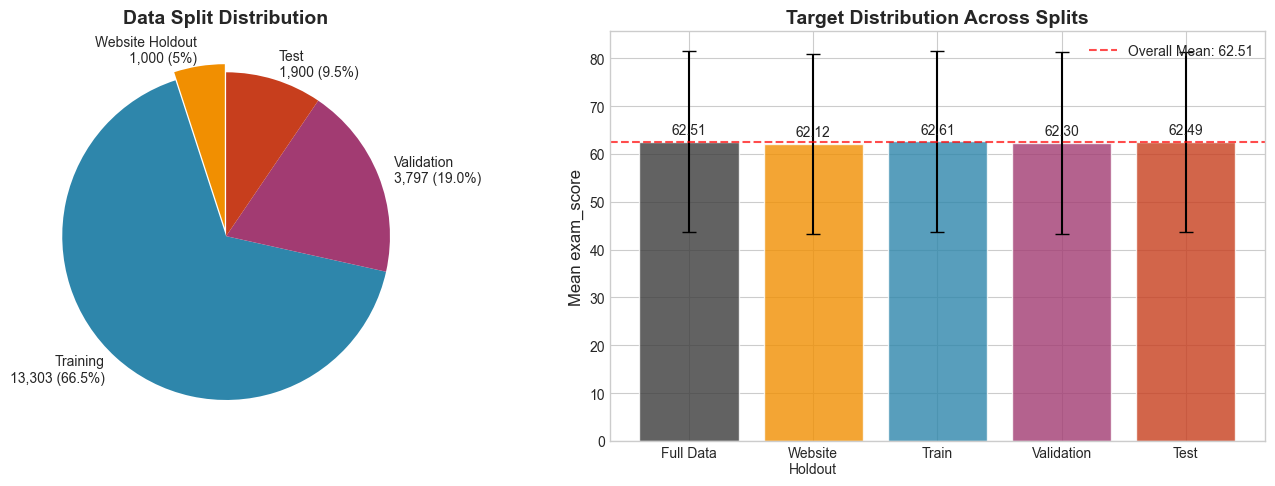


📊 Target Variable Distribution Across Splits:


Split  N Samples   Mean    Std   Min    Max
1  Website Holdout       1000  62.12  18.79  19.6  100.0
2         Training      13303  62.61  18.92  19.6  100.0
3       Validation       3797  62.30  18.98  19.6  100.0
4             Test       1900  62.49  18.73  19.6  100.0

In [124]:
# Visualize the data splits
print("=" * 60)
print("DATA SPLIT VISUALIZATION")
print("=" * 60)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart of overall splits
ax1 = axes[0]
split_sizes = [len(X_website), len(X_train), len(X_val), len(X_test)]
split_labels = [f'Website Holdout\n{len(X_website):,} (5%)', 
                f'Training\n{len(X_train):,} ({len(X_train)/len(X)*100:.1f}%)',
                f'Validation\n{len(X_val):,} ({len(X_val)/len(X)*100:.1f}%)',
                f'Test\n{len(X_test):,} ({len(X_test)/len(X)*100:.1f}%)']
colors_pie = ['#F18F01', '#2E86AB', '#A23B72', '#C73E1D']
explode = (0.05, 0, 0, 0)  # Highlight website holdout

wedges, texts, autotexts = ax1.pie(split_sizes, labels=split_labels, colors=colors_pie,
                                    explode=explode, autopct='', startangle=90)
ax1.set_title('Data Split Distribution', fontweight='bold', fontsize=14)

# Bar chart comparing target distribution across splits
ax2 = axes[1]
split_names = ['Full Data', 'Website\nHoldout', 'Train', 'Validation', 'Test']
split_means = [y.mean(), y_website.mean(), y_train.mean(), y_val.mean(), y_test.mean()]
split_stds = [y.std(), y_website.std(), y_train.std(), y_val.std(), y_test.std()]
bar_colors = ['#3B3B3B', '#F18F01', '#2E86AB', '#A23B72', '#C73E1D']

bars = ax2.bar(split_names, split_means, color=bar_colors, edgecolor='white', alpha=0.8)
ax2.errorbar(split_names, split_means, yerr=split_stds, fmt='none', color='black', capsize=5)
ax2.set_ylabel(f'Mean {target_col}')
ax2.set_title(f'Target Distribution Across Splits', fontweight='bold', fontsize=14)
ax2.axhline(y.mean(), color='red', linestyle='--', alpha=0.7, label=f'Overall Mean: {y.mean():.2f}')
ax2.legend()

for bar, mean_val in zip(bars, split_means):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{mean_val:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Summary statistics table
print("\n📊 Target Variable Distribution Across Splits:")
split_summary = pd.DataFrame({
    'Split': ['Website Holdout', 'Training', 'Validation', 'Test'],
    'N Samples': [len(y_website), len(y_train), len(y_val), len(y_test)],
    'Mean': [y_website.mean(), y_train.mean(), y_val.mean(), y_test.mean()],
    'Std': [y_website.std(), y_train.std(), y_val.std(), y_test.std()],
    'Min': [y_website.min(), y_train.min(), y_val.min(), y_test.min()],
    'Max': [y_website.max(), y_train.max(), y_val.max(), y_test.max()]
}).round(2)
split_summary.index = range(1, len(split_summary) + 1)
display(split_summary)


## 9. Data Preprocessing Pipeline

Preprocessing steps:
1. Drop `student_id` (identifier, not a predictive feature)
2. Apply StandardScaler to numerical features
3. One-Hot Encode categorical features
4. Apply PCA for dimensionality reduction


In [125]:
# CORRECTED PREPROCESSING: Drop student_id and re-scale properly
print("=" * 70)
print("CORRECTED DATA PREPROCESSING")
print("=" * 70)

# Drop student_id from all datasets (it's an identifier, not a feature)
print("\n⚠️ Dropping 'student_id' column - it's an identifier, not a predictive feature")

X_train_clean = X_train.drop(columns=['student_id'])
X_val_clean = X_val.drop(columns=['student_id'])
X_test_clean = X_test.drop(columns=['student_id'])
X_website_clean = X_website.drop(columns=['student_id'])

# Identify corrected feature types
numerical_features_clean = X_train_clean.select_dtypes(include=[np.number]).columns.tolist()
categorical_features_clean = X_train_clean.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"\n🔢 Numerical Features to Scale ({len(numerical_features_clean)}): {numerical_features_clean}")
print(f"📝 Categorical Features to Encode ({len(categorical_features_clean)}): {categorical_features_clean}")

# Create corrected preprocessor
preprocessor_clean = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features_clean),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'), categorical_features_clean)
    ],
    remainder='passthrough'
)

# Fit on training data only
X_train_scaled = preprocessor_clean.fit_transform(X_train_clean)
X_val_scaled = preprocessor_clean.transform(X_val_clean)
X_test_scaled = preprocessor_clean.transform(X_test_clean)
X_website_scaled = preprocessor_clean.transform(X_website_clean)

# Get corrected feature names
num_feature_names_clean = numerical_features_clean
cat_feature_names_clean = preprocessor_clean.named_transformers_['cat'].get_feature_names_out(categorical_features_clean).tolist()
all_feature_names_clean = num_feature_names_clean + cat_feature_names_clean

print(f"\n✅ Corrected Preprocessing Complete!")
print(f"   Original features (excluding student_id): {X_train_clean.shape[1]}")
print(f"   After One-Hot Encoding (drop='first'): {X_train_scaled.shape[1]}")
print(f"\n📋 Corrected Feature Names ({len(all_feature_names_clean)} total):")
for i, name in enumerate(all_feature_names_clean, 1):
    print(f"   {i:2d}. {name}")


CORRECTED DATA PREPROCESSING

⚠️ Dropping 'student_id' column - it's an identifier, not a predictive feature

🔢 Numerical Features to Scale (4): ['age', 'study_hours', 'class_attendance', 'sleep_hours']
📝 Categorical Features to Encode (7): ['gender', 'course', 'internet_access', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty']

✅ Corrected Preprocessing Complete!
   Original features (excluding student_id): 11
   After One-Hot Encoding (drop='first'): 23

📋 Corrected Feature Names (23 total):
    1. age
    2. study_hours
    3. class_attendance
    4. sleep_hours
    5. gender_male
    6. gender_other
    7. course_b.sc
    8. course_b.tech
    9. course_ba
   10. course_bba
   11. course_bca
   12. course_diploma
   13. internet_access_yes
   14. sleep_quality_good
   15. sleep_quality_poor
   16. study_method_group study
   17. study_method_mixed
   18. study_method_online videos
   19. study_method_self-study
   20. facility_rating_low
   21. facility_rating_

CORRECTED PCA ANALYSIS

📊 Corrected Variance Explained Analysis:
   Total components: 23
   Components for 80% variance: 11
   Components for 90% variance: 16
   Components for 95% variance: 19

📋 Variance Explained by First 10 Components:


PC  Variance Ratio  Variance %  Cumulative %
1    PC1        0.140506       14.05         14.05
2    PC2        0.138094       13.81         27.86
3    PC3        0.137101       13.71         41.57
4    PC4        0.136432       13.64         55.21
5    PC5        0.046922        4.69         59.91
6    PC6        0.046200        4.62         64.53
7    PC7        0.045217        4.52         69.05
8    PC8        0.043129        4.31         73.36
9    PC9        0.028369        2.84         76.20
10  PC10        0.027551        2.76         78.95

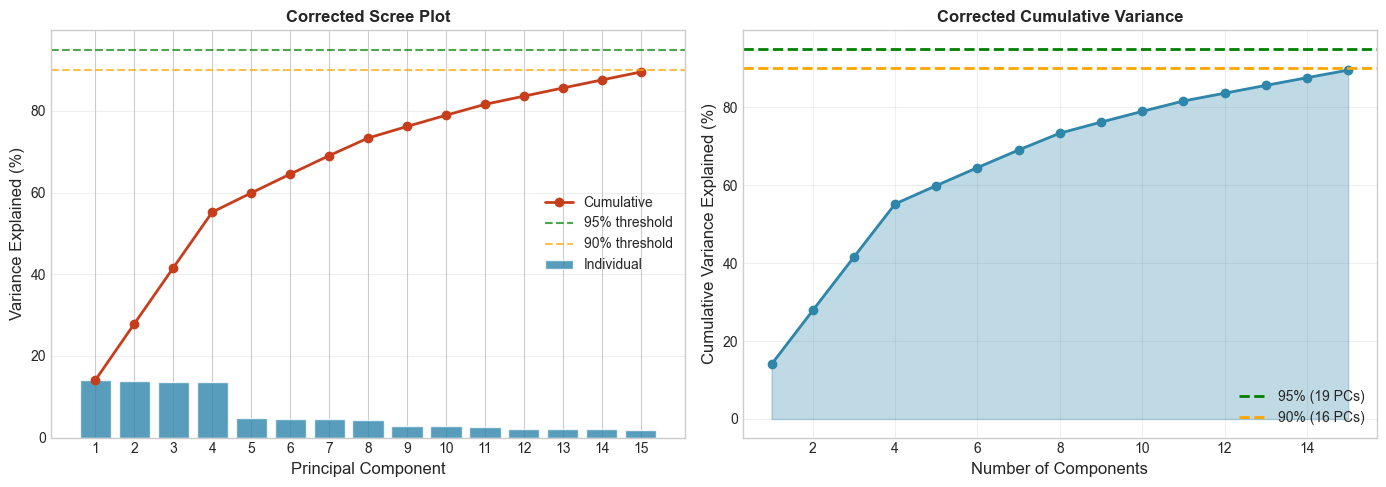


✅ PCA Transformation Complete!
   Features reduced: 23 → 19 components (95% variance)


In [126]:
# RE-RUN PCA with corrected preprocessing
print("=" * 70)
print("CORRECTED PCA ANALYSIS")
print("=" * 70)

# Fit PCA with all components
pca_clean = PCA()
pca_clean.fit(X_train_scaled)

# Calculate cumulative variance explained
cumulative_var_clean = np.cumsum(pca_clean.explained_variance_ratio_)

# Find number of components for different variance thresholds
n_95_clean = np.argmax(cumulative_var_clean >= 0.95) + 1
n_90_clean = np.argmax(cumulative_var_clean >= 0.90) + 1
n_80_clean = np.argmax(cumulative_var_clean >= 0.80) + 1

print(f"\n📊 Corrected Variance Explained Analysis:")
print(f"   Total components: {len(pca_clean.explained_variance_ratio_)}")
print(f"   Components for 80% variance: {n_80_clean}")
print(f"   Components for 90% variance: {n_90_clean}")
print(f"   Components for 95% variance: {n_95_clean}")

# Detailed variance breakdown
print(f"\n📋 Variance Explained by First 10 Components:")
variance_df_clean = pd.DataFrame({
    'PC': [f'PC{i+1}' for i in range(min(10, len(pca_clean.explained_variance_ratio_)))],
    'Variance Ratio': pca_clean.explained_variance_ratio_[:10],
    'Variance %': (pca_clean.explained_variance_ratio_[:10] * 100).round(2),
    'Cumulative %': (cumulative_var_clean[:10] * 100).round(2)
})
variance_df_clean.index = range(1, len(variance_df_clean) + 1)
display(variance_df_clean)

# Visualize corrected PCA
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scree Plot
ax1 = axes[0]
n_show = min(15, len(pca_clean.explained_variance_ratio_))
x_range = range(1, n_show + 1)
ax1.bar(x_range, pca_clean.explained_variance_ratio_[:n_show] * 100, 
        color='#2E86AB', edgecolor='white', alpha=0.8, label='Individual')
ax1.plot(x_range, cumulative_var_clean[:n_show] * 100, 
         'o-', color='#C73E1D', linewidth=2, markersize=6, label='Cumulative')
ax1.axhline(y=95, color='green', linestyle='--', alpha=0.7, label='95% threshold')
ax1.axhline(y=90, color='orange', linestyle='--', alpha=0.7, label='90% threshold')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Variance Explained (%)')
ax1.set_title('Corrected Scree Plot', fontweight='bold', fontsize=12)
ax1.legend(loc='center right')
ax1.set_xticks(x_range)
ax1.grid(axis='y', alpha=0.3)

# Cumulative Variance
ax2 = axes[1]
ax2.fill_between(x_range, cumulative_var_clean[:n_show] * 100, alpha=0.3, color='#2E86AB')
ax2.plot(x_range, cumulative_var_clean[:n_show] * 100, 'o-', color='#2E86AB', linewidth=2)
ax2.axhline(y=95, color='green', linestyle='--', linewidth=2, label=f'95% ({n_95_clean} PCs)')
ax2.axhline(y=90, color='orange', linestyle='--', linewidth=2, label=f'90% ({n_90_clean} PCs)')
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Cumulative Variance Explained (%)')
ax2.set_title('Corrected Cumulative Variance', fontweight='bold', fontsize=12)
ax2.legend(loc='lower right')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Transform data with optimal number of components (95% variance)
pca_optimal = PCA(n_components=n_95_clean)
X_train_pca_clean = pca_optimal.fit_transform(X_train_scaled)
X_val_pca_clean = pca_optimal.transform(X_val_scaled)
X_test_pca_clean = pca_optimal.transform(X_test_scaled)
X_website_pca_clean = pca_optimal.transform(X_website_scaled)

print(f"\n✅ PCA Transformation Complete!")
print(f"   Features reduced: {X_train_scaled.shape[1]} → {n_95_clean} components (95% variance)")


## 10. Stepwise Regression Model Development

We will implement **Bidirectional Stepwise Regression** using **Adjusted R-squared** as the selection criterion.

**Approach:**
- Start with no features (forward selection)
- At each step: try adding any unused feature AND removing any used feature
- Keep the change that improves Adjusted R² the most
- Stop when no improvement is possible

**Comparison:**
1. Stepwise on Original Preprocessed Features (interpretable)
2. Stepwise on PCA-transformed Features


In [127]:
# Import statsmodels for regression
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def bidirectional_stepwise_selection(X, y, feature_names, verbose=True):
    """
    Perform bidirectional stepwise regression using Adjusted R-squared.
    
    Parameters:
    -----------
    X : array-like, shape (n_samples, n_features)
        Feature matrix
    y : array-like, shape (n_samples,)
        Target variable
    feature_names : list
        Names of features
    verbose : bool
        Print step-by-step progress
        
    Returns:
    --------
    dict : Contains selected features, model, and selection history
    """
    n_samples, n_features = X.shape
    
    # Convert to DataFrame for easier manipulation
    X_df = pd.DataFrame(X, columns=feature_names)
    
    # Initialize
    selected_features = []
    remaining_features = list(feature_names)
    history = []
    
    # Start with intercept-only model
    current_adj_r2 = 0.0
    step = 0
    
    if verbose:
        print("=" * 80)
        print("BIDIRECTIONAL STEPWISE REGRESSION")
        print("Selection Criterion: Adjusted R-squared")
        print("=" * 80)
        print(f"\nStarting with {n_features} candidate features")
        print("-" * 80)
    
    while True:
        step += 1
        best_adj_r2 = current_adj_r2
        best_action = None
        best_feature = None
        
        # FORWARD: Try adding each remaining feature
        for feature in remaining_features:
            test_features = selected_features + [feature]
            X_test = sm.add_constant(X_df[test_features])
            
            try:
                model = sm.OLS(y, X_test).fit()
                adj_r2 = model.rsquared_adj
                
                if adj_r2 > best_adj_r2:
                    best_adj_r2 = adj_r2
                    best_action = 'add'
                    best_feature = feature
                    best_model = model
            except:
                continue
        
        # BACKWARD: Try removing each selected feature (if more than 1)
        if len(selected_features) > 1:
            for feature in selected_features:
                test_features = [f for f in selected_features if f != feature]
                X_test = sm.add_constant(X_df[test_features])
                
                try:
                    model = sm.OLS(y, X_test).fit()
                    adj_r2 = model.rsquared_adj
                    
                    if adj_r2 > best_adj_r2:
                        best_adj_r2 = adj_r2
                        best_action = 'remove'
                        best_feature = feature
                        best_model = model
                except:
                    continue
        
        # Check if improvement found
        if best_action is None:
            if verbose:
                print(f"\n✓ Step {step}: No improvement possible. Stopping.")
            break
        
        # Apply best action
        if best_action == 'add':
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            action_symbol = '+'
        else:  # remove
            selected_features.remove(best_feature)
            remaining_features.append(best_feature)
            action_symbol = '-'
        
        # Record history
        history.append({
            'step': step,
            'action': best_action,
            'feature': best_feature,
            'adj_r2': best_adj_r2,
            'n_features': len(selected_features)
        })
        
        current_adj_r2 = best_adj_r2
        
        if verbose:
            print(f"Step {step:2d}: [{action_symbol}] {best_feature:<35} | Adj R² = {best_adj_r2:.6f} | Features: {len(selected_features)}")
    
    # Fit final model
    X_final = sm.add_constant(X_df[selected_features])
    final_model = sm.OLS(y, X_final).fit()
    
    return {
        'selected_features': selected_features,
        'model': final_model,
        'history': pd.DataFrame(history),
        'n_features_selected': len(selected_features),
        'final_adj_r2': final_model.rsquared_adj
    }


def display_model_summary(result, model_name="Model"):
    """Display a professional summary of the stepwise regression results."""
    model = result['model']
    
    print("\n" + "=" * 80)
    print(f"📊 {model_name.upper()} - SUMMARY")
    print("=" * 80)
    
    # Basic metrics
    print(f"\n{'─' * 40}")
    print("MODEL PERFORMANCE METRICS")
    print(f"{'─' * 40}")
    print(f"  R-squared:           {model.rsquared:.6f}")
    print(f"  Adjusted R-squared:  {model.rsquared_adj:.6f}")
    print(f"  F-statistic:         {model.fvalue:.4f}")
    print(f"  Prob (F-statistic):  {model.f_pvalue:.2e}")
    print(f"  AIC:                 {model.aic:.2f}")
    print(f"  BIC:                 {model.bic:.2f}")
    print(f"  Log-Likelihood:      {model.llf:.2f}")
    
    print(f"\n{'─' * 40}")
    print(f"FEATURES SELECTED: {result['n_features_selected']}")
    print(f"{'─' * 40}")
    
    # Coefficients table
    coef_df = pd.DataFrame({
        'Feature': model.params.index,
        'Coefficient': model.params.values,
        'Std Error': model.bse.values,
        't-value': model.tvalues.values,
        'P-value': model.pvalues.values,
        'Significant': ['***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else '' for p in model.pvalues.values]
    })
    coef_df = coef_df.round(6)
    
    print("\n📋 Coefficient Summary:")
    print("   (*** p<0.001, ** p<0.01, * p<0.05)")
    display(coef_df)
    
    return coef_df


In [128]:
# Run Stepwise Regression on ORIGINAL PREPROCESSED Features
print("╔" + "═" * 78 + "╗")
print("║" + " MODEL 1: STEPWISE REGRESSION ON ORIGINAL FEATURES ".center(78) + "║")
print("╚" + "═" * 78 + "╝")

# Run stepwise selection
result_original = bidirectional_stepwise_selection(
    X=X_train_scaled,
    y=y_train.values,
    feature_names=all_feature_names_clean,
    verbose=True
)

# Display model summary
coef_original = display_model_summary(result_original, "Stepwise Regression - Original Features")


╔══════════════════════════════════════════════════════════════════════════════╗
║              MODEL 1: STEPWISE REGRESSION ON ORIGINAL FEATURES               ║
╚══════════════════════════════════════════════════════════════════════════════╝
BIDIRECTIONAL STEPWISE REGRESSION
Selection Criterion: Adjusted R-squared

Starting with 23 candidate features
--------------------------------------------------------------------------------
Step  1: [+] study_hours                         | Adj R² = 0.516640 | Features: 1
Step  2: [+] class_attendance                    | Adj R² = 0.614271 | Features: 2
Step  3: [+] sleep_quality_poor                  | Adj R² = 0.644068 | Features: 3
Step  4: [+] facility_rating_low                 | Adj R² = 0.665351 | Features: 4
Step  5: [+] sleep_hours                         | Adj R² = 0.682123 | Features: 5
Step  6: [+] sleep_quality_good                  | Adj R² = 0.691581 | Features: 6
Step  7: [+] study_method_self-study             | Adj R² = 0.69905

Feature  Coefficient  Std Error     t-value   P-value  \
0                        const    72.263123   0.331149  218.219407  0.000000   
1                  study_hours    13.562918   0.085135  159.311126  0.000000   
2             class_attendance     5.928168   0.085103   69.658345  0.000000   
3           sleep_quality_poor    -4.610485   0.208589  -22.103230  0.000000   
4          facility_rating_low    -7.723350   0.209206  -36.917376  0.000000   
5                  sleep_hours     2.473580   0.085114   29.061956  0.000000   
6           sleep_quality_good     4.520359   0.208061   21.726163  0.000000   
7      study_method_self-study    -9.374814   0.266646  -35.158232  0.000000   
8   study_method_online videos    -8.841532   0.266391  -33.190028  0.000000   
9     study_method_group study    -7.637403   0.271164  -28.165277  0.000000   
10          study_method_mixed    -4.897299   0.270154  -18.127821  0.000000   
11      facility_rating_medium    -3.633273   0.208443  -17.430556  0.000000   
12                 course_b.sc    -0.499639   0.241756   -2.066709  0.038781   
13                gender_other     0.367317   0.180082    2.039725  0.041398   
14         internet_access_yes     0.318311   0.236288    1.347134  0.177960   

   Significant  
0          ***  
1          ***  
2          ***  
3          ***  
4          ***  
5          ***  
6          ***  
7          ***  
8          ***  
9          ***  
10         ***  
11         ***  
12           *  
13           *  
14


FEATURE SELECTION PROGRESSION - ORIGINAL FEATURES


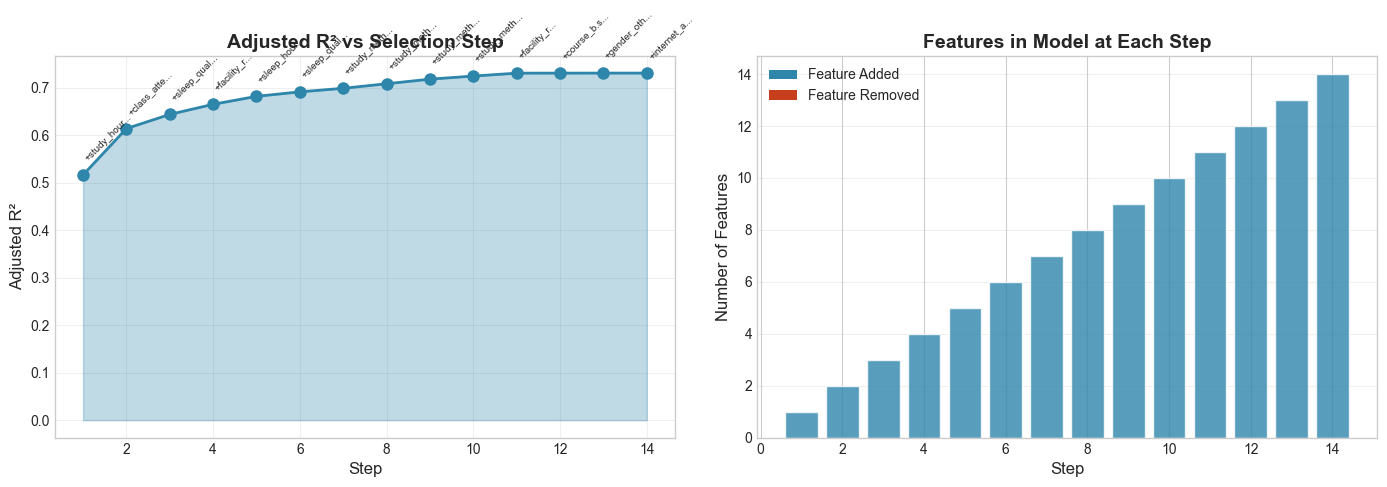


📋 Selection History:


step action                     feature    adj_r2  n_features
0      1    add                 study_hours  0.516640           1
1      2    add            class_attendance  0.614271           2
2      3    add          sleep_quality_poor  0.644068           3
3      4    add         facility_rating_low  0.665351           4
4      5    add                 sleep_hours  0.682123           5
5      6    add          sleep_quality_good  0.691581           6
6      7    add     study_method_self-study  0.699051           7
7      8    add  study_method_online videos  0.708637           8
8      9    add    study_method_group study  0.718315           9
9     10    add          study_method_mixed  0.724839          10
10    11    add      facility_rating_medium  0.730956          11
11    12    add                 course_b.sc  0.731022          12
12    13    add                gender_other  0.731086          13
13    14    add         internet_access_yes  0.731102          14

In [129]:
# Visualize Feature Selection Progress for Original Features
print("\n" + "=" * 70)
print("FEATURE SELECTION PROGRESSION - ORIGINAL FEATURES")
print("=" * 70)

history_orig = result_original['history']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Adjusted R² progression
ax1 = axes[0]
ax1.plot(history_orig['step'], history_orig['adj_r2'], 'o-', color='#2E86AB', linewidth=2, markersize=8)
ax1.fill_between(history_orig['step'], history_orig['adj_r2'], alpha=0.3, color='#2E86AB')
ax1.set_xlabel('Step', fontsize=12)
ax1.set_ylabel('Adjusted R²', fontsize=12)
ax1.set_title('Adjusted R² vs Selection Step', fontweight='bold', fontsize=14)
ax1.grid(alpha=0.3)

# Annotate key points
for i, row in history_orig.iterrows():
    if row['action'] == 'add':
        ax1.annotate(f"+{row['feature'][:10]}...", 
                    (row['step'], row['adj_r2']),
                    textcoords="offset points", xytext=(0,10),
                    fontsize=7, rotation=45, ha='left')

# Plot 2: Number of features
ax2 = axes[1]
colors = ['#2E86AB' if a == 'add' else '#C73E1D' for a in history_orig['action']]
ax2.bar(history_orig['step'], history_orig['n_features'], color=colors, edgecolor='white', alpha=0.8)
ax2.set_xlabel('Step', fontsize=12)
ax2.set_ylabel('Number of Features', fontsize=12)
ax2.set_title('Features in Model at Each Step', fontweight='bold', fontsize=14)
ax2.grid(axis='y', alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#2E86AB', label='Feature Added'),
                   Patch(facecolor='#C73E1D', label='Feature Removed')]
ax2.legend(handles=legend_elements, loc='upper left')

plt.tight_layout()
plt.show()

# Show selection history table
print("\n📋 Selection History:")
display(history_orig)


In [130]:
# Run Stepwise Regression on PCA Features
print("\n")
print("╔" + "═" * 78 + "╗")
print("║" + " MODEL 2: STEPWISE REGRESSION ON PCA FEATURES ".center(78) + "║")
print("╚" + "═" * 78 + "╝")

# Create PCA feature names
pca_feature_names = [f'PC{i+1}' for i in range(X_train_pca_clean.shape[1])]

# Run stepwise selection on PCA features
result_pca = bidirectional_stepwise_selection(
    X=X_train_pca_clean,
    y=y_train.values,
    feature_names=pca_feature_names,
    verbose=True
)

# Display model summary
coef_pca = display_model_summary(result_pca, "Stepwise Regression - PCA Features")




╔══════════════════════════════════════════════════════════════════════════════╗
║                 MODEL 2: STEPWISE REGRESSION ON PCA FEATURES                 ║
╚══════════════════════════════════════════════════════════════════════════════╝
BIDIRECTIONAL STEPWISE REGRESSION
Selection Criterion: Adjusted R-squared

Starting with 19 candidate features
--------------------------------------------------------------------------------
Step  1: [+] PC2                                 | Adj R² = 0.433853 | Features: 1
Step  2: [+] PC1                                 | Adj R² = 0.629350 | Features: 2
Step  3: [+] PC5                                 | Adj R² = 0.656444 | Features: 3
Step  4: [+] PC19                                | Adj R² = 0.672283 | Features: 4
Step  5: [+] PC6                                 | Adj R² = 0.684040 | Features: 5
Step  6: [+] PC7                                 | Adj R² = 0.691580 | Features: 6
Step  7: [+] PC10                                | Adj R² = 0.697

Feature  Coefficient  Std Error     t-value   P-value Significant
0    const    62.606732   0.089596  698.769713  0.000000         ***
1      PC2    12.460411   0.089562  139.126479  0.000000         ***
2      PC1     8.292096   0.088790   93.390244  0.000000         ***
3      PC5     5.343789   0.153646   34.779949  0.000000         ***
4     PC19    -7.180810   0.269955  -26.600010  0.000000         ***
5      PC6    -3.549095   0.154841  -22.920844  0.000000         ***
6      PC7    -2.874357   0.156517  -18.364520  0.000000         ***
7     PC10     3.344059   0.200513   16.677542  0.000000         ***
8      PC3    -0.748761   0.089885   -8.330179  0.000000         ***
9     PC18     1.896554   0.267128    7.099798  0.000000         ***
10    PC11    -1.141275   0.203924   -5.596558  0.000000         ***
11     PC4    -0.490462   0.090106   -5.443187  0.000000         ***
12    PC15     0.352296   0.238407    1.477712  0.139509            
13    PC13    -0.343180   0.235363   -1.458089  0.144840            
14    PC14     0.269537   0.236931    1.137618  0.255301


FEATURE SELECTION PROGRESSION - PCA FEATURES


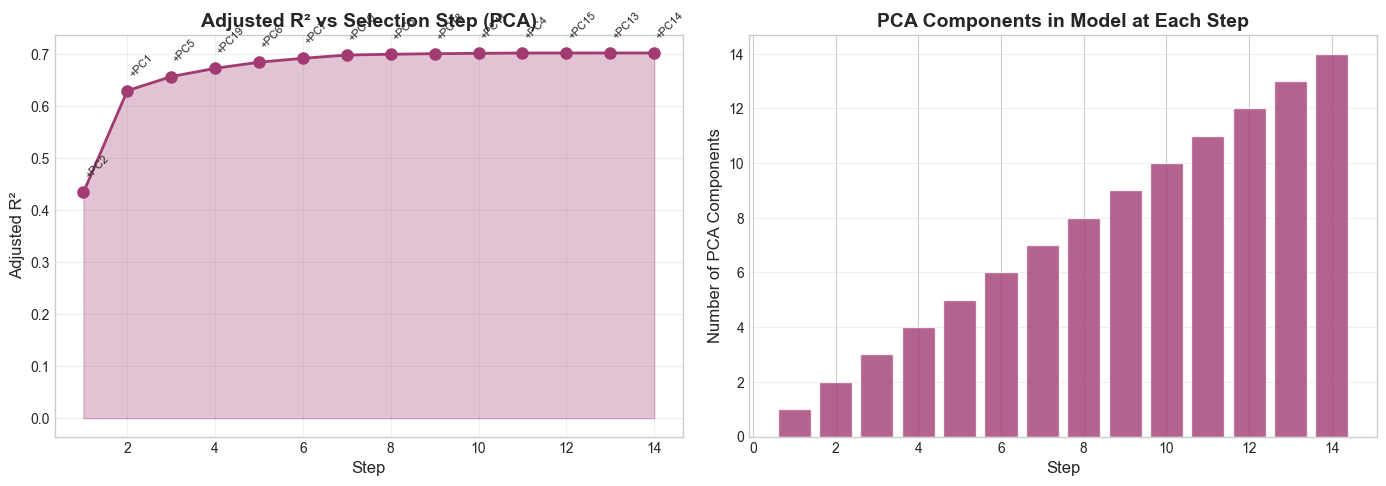


📋 PCA Selection History:


step action feature    adj_r2  n_features
0      1    add     PC2  0.433853           1
1      2    add     PC1  0.629350           2
2      3    add     PC5  0.656444           3
3      4    add    PC19  0.672283           4
4      5    add     PC6  0.684040           5
5      6    add     PC7  0.691580           6
6      7    add    PC10  0.697795           7
7      8    add     PC3  0.699328           8
8      9    add    PC18  0.700437           9
9     10    add    PC11  0.701117          10
10    11    add     PC4  0.701759          11
11    12    add    PC15  0.701785          12
12    13    add    PC13  0.701811          13
13    14    add    PC14  0.701817          14

In [131]:
# Visualize Feature Selection Progress for PCA Features
print("\n" + "=" * 70)
print("FEATURE SELECTION PROGRESSION - PCA FEATURES")
print("=" * 70)

history_pca = result_pca['history']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Adjusted R² progression
ax1 = axes[0]
ax1.plot(history_pca['step'], history_pca['adj_r2'], 'o-', color='#A23B72', linewidth=2, markersize=8)
ax1.fill_between(history_pca['step'], history_pca['adj_r2'], alpha=0.3, color='#A23B72')
ax1.set_xlabel('Step', fontsize=12)
ax1.set_ylabel('Adjusted R²', fontsize=12)
ax1.set_title('Adjusted R² vs Selection Step (PCA)', fontweight='bold', fontsize=14)
ax1.grid(alpha=0.3)

# Annotate key points
for i, row in history_pca.iterrows():
    if row['action'] == 'add':
        ax1.annotate(f"+{row['feature']}", 
                    (row['step'], row['adj_r2']),
                    textcoords="offset points", xytext=(0,10),
                    fontsize=8, rotation=45, ha='left')

# Plot 2: Number of features
ax2 = axes[1]
colors = ['#A23B72' if a == 'add' else '#C73E1D' for a in history_pca['action']]
ax2.bar(history_pca['step'], history_pca['n_features'], color=colors, edgecolor='white', alpha=0.8)
ax2.set_xlabel('Step', fontsize=12)
ax2.set_ylabel('Number of PCA Components', fontsize=12)
ax2.set_title('PCA Components in Model at Each Step', fontweight='bold', fontsize=14)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Show selection history table
print("\n📋 PCA Selection History:")
display(history_pca)


## 11. ElasticNet Regression with Interaction Terms

Using **ElasticNetCV** from sklearn with automatic cross-validation for:
- Alpha (regularization strength) selection
- L1 ratio (Lasso vs Ridge balance) selection

## Interaction Terms Created:
1. `study_hours × sleep_hours` - Study-rest balance
2. `study_hours × class_attendance` - Self-study + class engagement
3. `sleep_hours × sleep_quality` - Sleep effectiveness
4. `study_hours × exam_difficulty` - Preparation vs challenge
5. `class_attendance × study_method` - Learning style
6. `study_hours²` - Diminishing returns on studying


In [132]:
# Import sklearn linear models
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("╔" + "═" * 78 + "╗")
print("║" + " FEATURE ENGINEERING: INTERACTION TERMS ".center(78) + "║")
print("╚" + "═" * 78 + "╝")

# First, let's work with the RAW training data before preprocessing
# so we can create proper interaction terms

# Get raw feature values from X_train (before scaling)
print("\n📋 Creating Interaction Terms...")

# Create interaction features DataFrame from raw training data
def create_interaction_features(df_raw):
    """Create interaction terms from raw data."""
    interactions = pd.DataFrame(index=df_raw.index)
    
    # 1. study_hours × sleep_hours (Study-rest balance)
    interactions['study_x_sleep'] = df_raw['study_hours'] * df_raw['sleep_hours']
    
    # 2. study_hours × class_attendance (Self-study + class engagement)
    interactions['study_x_attendance'] = df_raw['study_hours'] * df_raw['class_attendance']
    
    # 3. study_hours² (Diminishing returns on studying)
    interactions['study_squared'] = df_raw['study_hours'] ** 2
    
    # 4. sleep_hours × sleep_quality (need to encode sleep_quality first)
    # Create dummy for sleep_quality (poor=0, average=1, good=2)
    sleep_quality_map = {'poor': 0, 'average': 1, 'good': 2}
    sleep_quality_num = df_raw['sleep_quality'].map(sleep_quality_map)
    interactions['sleep_x_quality'] = df_raw['sleep_hours'] * sleep_quality_num
    
    # 5. study_hours × exam_difficulty (Preparation vs challenge)
    # Create dummy for exam_difficulty (easy=0, moderate=1, hard=2)
    difficulty_map = {'easy': 0, 'moderate': 1, 'hard': 2}
    difficulty_num = df_raw['exam_difficulty'].map(difficulty_map)
    interactions['study_x_difficulty'] = df_raw['study_hours'] * difficulty_num
    
    # 6. class_attendance × study_method (Learning style)
    # Use dominant study method encoded as numeric
    method_map = {'self-study': 0, 'group study': 1, 'online videos': 2, 'coaching': 3, 'mixed': 4}
    method_num = df_raw['study_method'].map(method_map)
    interactions['attendance_x_method'] = df_raw['class_attendance'] * method_num
    
    return interactions

# Create interaction features for all sets
interactions_train = create_interaction_features(X_train_clean)
interactions_val = create_interaction_features(X_val_clean)
interactions_test = create_interaction_features(X_test_clean)
interactions_website = create_interaction_features(X_website_clean)

interaction_feature_names = interactions_train.columns.tolist()

print(f"\n✅ Interaction Features Created:")
for i, name in enumerate(interaction_feature_names, 1):
    print(f"   {i}. {name}")

print(f"\n📊 Interaction Features Shape: {interactions_train.shape}")


╔══════════════════════════════════════════════════════════════════════════════╗
║                    FEATURE ENGINEERING: INTERACTION TERMS                    ║
╚══════════════════════════════════════════════════════════════════════════════╝

📋 Creating Interaction Terms...

✅ Interaction Features Created:
   1. study_x_sleep
   2. study_x_attendance
   3. study_squared
   4. sleep_x_quality
   5. study_x_difficulty
   6. attendance_x_method

📊 Interaction Features Shape: (13303, 6)


In [133]:
# Scale interaction features and combine with original scaled features
print("=" * 70)
print("COMBINING ORIGINAL FEATURES WITH INTERACTION TERMS")
print("=" * 70)

# Scale interaction features
scaler_interactions = StandardScaler()
interactions_train_scaled = scaler_interactions.fit_transform(interactions_train)
interactions_val_scaled = scaler_interactions.transform(interactions_val)
interactions_test_scaled = scaler_interactions.transform(interactions_test)
interactions_website_scaled = scaler_interactions.transform(interactions_website)

# Combine original scaled features with scaled interaction features
X_train_with_interactions = np.hstack([X_train_scaled, interactions_train_scaled])
X_val_with_interactions = np.hstack([X_val_scaled, interactions_val_scaled])
X_test_with_interactions = np.hstack([X_test_scaled, interactions_test_scaled])
X_website_with_interactions = np.hstack([X_website_scaled, interactions_website_scaled])

# Combined feature names
all_feature_names_with_interactions = all_feature_names_clean + interaction_feature_names

print(f"\n✅ Feature Combination Complete!")
print(f"   Original features: {X_train_scaled.shape[1]}")
print(f"   Interaction features: {interactions_train_scaled.shape[1]}")
print(f"   Total features: {X_train_with_interactions.shape[1]}")

print(f"\n📋 All Features ({len(all_feature_names_with_interactions)}):")
for i, name in enumerate(all_feature_names_with_interactions, 1):
    marker = "🔗" if name in interaction_feature_names else "  "
    print(f"   {marker} {i:2d}. {name}")


COMBINING ORIGINAL FEATURES WITH INTERACTION TERMS

✅ Feature Combination Complete!
   Original features: 23
   Interaction features: 6
   Total features: 29

📋 All Features (29):
       1. age
       2. study_hours
       3. class_attendance
       4. sleep_hours
       5. gender_male
       6. gender_other
       7. course_b.sc
       8. course_b.tech
       9. course_ba
      10. course_bba
      11. course_bca
      12. course_diploma
      13. internet_access_yes
      14. sleep_quality_good
      15. sleep_quality_poor
      16. study_method_group study
      17. study_method_mixed
      18. study_method_online videos
      19. study_method_self-study
      20. facility_rating_low
      21. facility_rating_medium
      22. exam_difficulty_hard
      23. exam_difficulty_moderate
   🔗 24. study_x_sleep
   🔗 25. study_x_attendance
   🔗 26. study_squared
   🔗 27. sleep_x_quality
   🔗 28. study_x_difficulty
   🔗 29. attendance_x_method


In [134]:
# Train ElasticNetCV on Original Features with Interactions
print("\n")
print("╔" + "═" * 78 + "╗")
print("║" + " MODEL: ELASTICNET WITH INTERACTION TERMS ".center(78) + "║")
print("╚" + "═" * 78 + "╝")

# Define l1_ratio range (0 = Ridge, 1 = Lasso)
l1_ratios = [0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99]

# Train ElasticNetCV with cross-validation
print("\n🔄 Training ElasticNetCV with 5-fold cross-validation...")
print("   - Searching for optimal alpha (regularization strength)")
print("   - Searching for optimal l1_ratio (Lasso vs Ridge balance)")

elasticnet_cv = ElasticNetCV(
    l1_ratio=l1_ratios,
    alphas=None,  # Auto-generate alphas
    cv=5,         # 5-fold cross-validation
    max_iter=10000,
    tol=1e-4,
    n_jobs=-1,    # Use all cores
    random_state=42
)

# Fit on training data only
elasticnet_cv.fit(X_train_with_interactions, y_train)

print("\n✅ ElasticNetCV Training Complete!")
print(f"\n{'─' * 60}")
print("OPTIMAL HYPERPARAMETERS")
print(f"{'─' * 60}")
print(f"   Alpha (λ):     {elasticnet_cv.alpha_:.6f}")
print(f"   L1 Ratio:      {elasticnet_cv.l1_ratio_:.4f}")
print(f"                  (0 = Ridge, 1 = Lasso)")

# Model interpretation
if elasticnet_cv.l1_ratio_ > 0.7:
    model_type = "Lasso-dominant (sparse feature selection)"
elif elasticnet_cv.l1_ratio_ < 0.3:
    model_type = "Ridge-dominant (all features retained)"
else:
    model_type = "Balanced Lasso-Ridge mix"
print(f"   Interpretation: {model_type}")




╔══════════════════════════════════════════════════════════════════════════════╗
║                   MODEL: ELASTICNET WITH INTERACTION TERMS                   ║
╚══════════════════════════════════════════════════════════════════════════════╝

🔄 Training ElasticNetCV with 5-fold cross-validation...
   - Searching for optimal alpha (regularization strength)
   - Searching for optimal l1_ratio (Lasso vs Ridge balance)

✅ ElasticNetCV Training Complete!

────────────────────────────────────────────────────────────
OPTIMAL HYPERPARAMETERS
────────────────────────────────────────────────────────────
   Alpha (λ):     0.014592
   L1 Ratio:      0.9900
                  (0 = Ridge, 1 = Lasso)
   Interpretation: Lasso-dominant (sparse feature selection)


In [135]:
# Display ElasticNet Coefficients
print("\n" + "=" * 70)
print("ELASTICNET MODEL COEFFICIENTS")
print("=" * 70)

# Create coefficients DataFrame
coef_elasticnet = pd.DataFrame({
    'Feature': all_feature_names_with_interactions,
    'Coefficient': elasticnet_cv.coef_,
    'Abs_Coefficient': np.abs(elasticnet_cv.coef_)
})

# Add indicator for non-zero coefficients (selected features)
coef_elasticnet['Selected'] = coef_elasticnet['Coefficient'] != 0
coef_elasticnet['Is_Interaction'] = coef_elasticnet['Feature'].isin(interaction_feature_names)

# Sort by absolute coefficient value
coef_elasticnet = coef_elasticnet.sort_values('Abs_Coefficient', ascending=False)
coef_elasticnet.index = range(1, len(coef_elasticnet) + 1)

# Count selected features
n_selected = coef_elasticnet['Selected'].sum()
n_total = len(coef_elasticnet)
n_interactions_selected = (coef_elasticnet['Selected'] & coef_elasticnet['Is_Interaction']).sum()

print(f"\n📊 Feature Selection Summary:")
print(f"   Total features:      {n_total}")
print(f"   Selected (non-zero): {n_selected} ({n_selected/n_total*100:.1f}%)")
print(f"   Zeroed out:          {n_total - n_selected}")
print(f"   Interactions selected: {n_interactions_selected} of {len(interaction_feature_names)}")

print(f"\n📋 Top 15 Features by Coefficient Magnitude:")
display(coef_elasticnet[['Feature', 'Coefficient', 'Selected', 'Is_Interaction']].head(15))

# Training metrics
y_train_pred = elasticnet_cv.predict(X_train_with_interactions)
train_r2 = r2_score(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)

print(f"\n{'─' * 60}")
print("TRAINING METRICS")
print(f"{'─' * 60}")
print(f"   R² Score:  {train_r2:.6f}")
print(f"   RMSE:      {train_rmse:.4f}")
print(f"   MAE:       {train_mae:.4f}")
print(f"   Intercept: {elasticnet_cv.intercept_:.4f}")



ELASTICNET MODEL COEFFICIENTS

📊 Feature Selection Summary:
   Total features:      29
   Selected (non-zero): 20 (69.0%)
   Zeroed out:          9
   Interactions selected: 3 of 6

📋 Top 15 Features by Coefficient Magnitude:


Feature  Coefficient  Selected  Is_Interaction
1                  study_hours    13.900482      True           False
2   study_method_online videos    -7.999194      True           False
3      study_method_self-study    -7.617248      True           False
4          facility_rating_low    -7.586260      True           False
5     study_method_group study    -6.334274      True           False
6             class_attendance     5.687951      True           False
7           study_method_mixed    -4.964219      True           False
8           sleep_quality_poor    -3.998897      True           False
9           sleep_quality_good     3.907715      True           False
10      facility_rating_medium    -3.497609      True           False
11                 sleep_hours     2.469936      True           False
12         attendance_x_method     0.704093      True            True
13             sleep_x_quality     0.497163      True            True
14               study_x_sleep    -0.398237      True            True
15                 course_b.sc    -0.384960      True           False


────────────────────────────────────────────────────────────
TRAINING METRICS
────────────────────────────────────────────────────────────
   R² Score:  0.731283
   RMSE:      9.8096
   MAE:       7.8676
   Intercept: 71.4516



COEFFICIENT VISUALIZATION


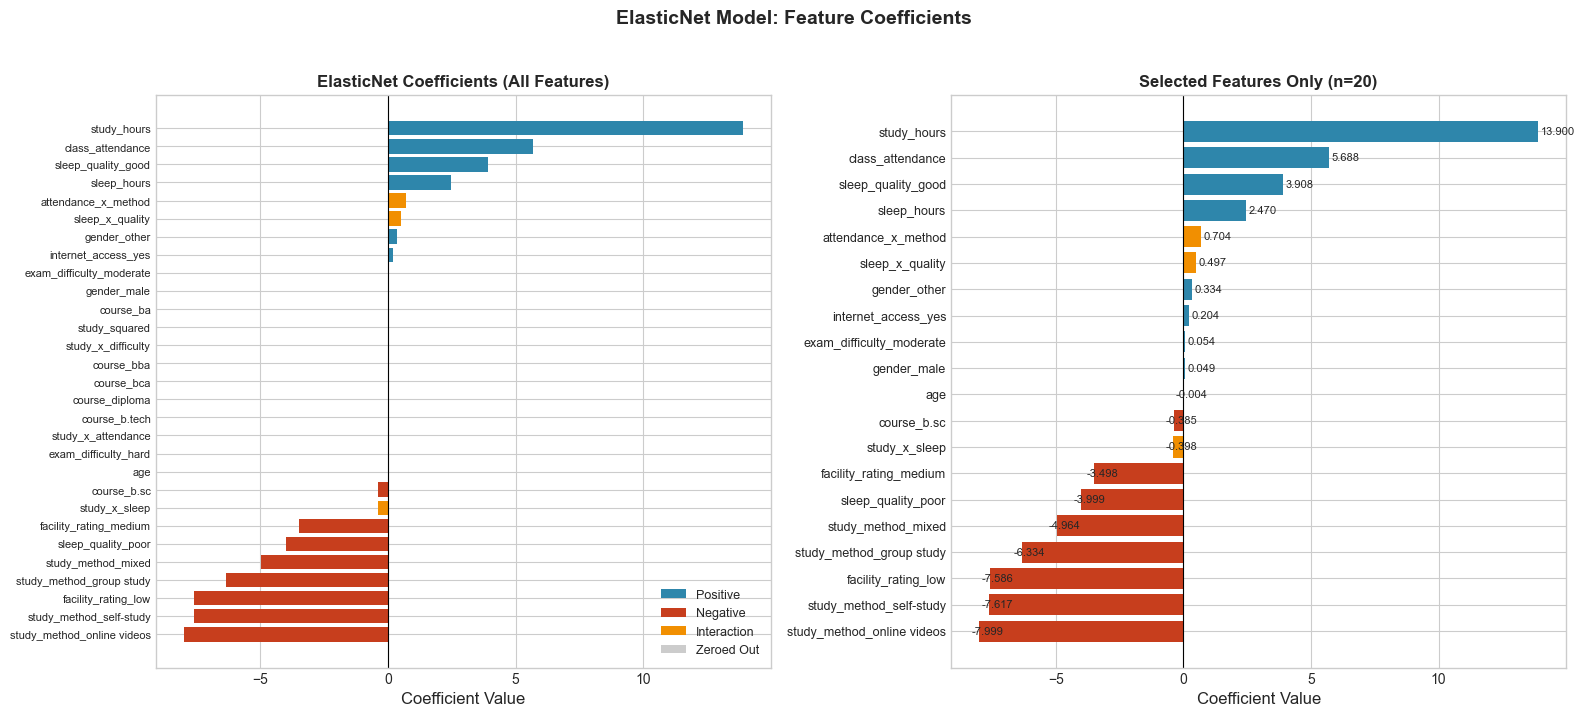

In [136]:
# Visualize ElasticNet Coefficients
print("\n" + "=" * 70)
print("COEFFICIENT VISUALIZATION")
print("=" * 70)

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1: All coefficients sorted by magnitude
ax1 = axes[0]
coef_sorted = coef_elasticnet.sort_values('Coefficient')
colors = []
for _, row in coef_sorted.iterrows():
    if not row['Selected']:
        colors.append('#CCCCCC')  # Zeroed out
    elif row['Is_Interaction']:
        colors.append('#F18F01')  # Interaction term
    elif row['Coefficient'] > 0:
        colors.append('#2E86AB')  # Positive
    else:
        colors.append('#C73E1D')  # Negative

ax1.barh(range(len(coef_sorted)), coef_sorted['Coefficient'], color=colors)
ax1.set_yticks(range(len(coef_sorted)))
ax1.set_yticklabels(coef_sorted['Feature'], fontsize=8)
ax1.axvline(0, color='black', linewidth=0.8)
ax1.set_xlabel('Coefficient Value')
ax1.set_title('ElasticNet Coefficients (All Features)', fontweight='bold', fontsize=12)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2E86AB', label='Positive'),
    Patch(facecolor='#C73E1D', label='Negative'),
    Patch(facecolor='#F18F01', label='Interaction'),
    Patch(facecolor='#CCCCCC', label='Zeroed Out')
]
ax1.legend(handles=legend_elements, loc='lower right', fontsize=9)

# Plot 2: Only selected features (non-zero coefficients)
ax2 = axes[1]
selected_coef = coef_elasticnet[coef_elasticnet['Selected']].sort_values('Coefficient')
colors_selected = []
for _, row in selected_coef.iterrows():
    if row['Is_Interaction']:
        colors_selected.append('#F18F01')
    elif row['Coefficient'] > 0:
        colors_selected.append('#2E86AB')
    else:
        colors_selected.append('#C73E1D')

ax2.barh(range(len(selected_coef)), selected_coef['Coefficient'], color=colors_selected)
ax2.set_yticks(range(len(selected_coef)))
ax2.set_yticklabels(selected_coef['Feature'], fontsize=9)
ax2.axvline(0, color='black', linewidth=0.8)
ax2.set_xlabel('Coefficient Value')
ax2.set_title(f'Selected Features Only (n={len(selected_coef)})', fontweight='bold', fontsize=12)

# Add coefficient values
for i, (_, row) in enumerate(selected_coef.iterrows()):
    x_pos = row['Coefficient'] + 0.1 if row['Coefficient'] >= 0 else row['Coefficient'] - 0.3
    ax2.text(x_pos, i, f'{row["Coefficient"]:.3f}', va='center', fontsize=8)

plt.suptitle('ElasticNet Model: Feature Coefficients', fontweight='bold', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


In [137]:
# Run PCA on features WITH interactions for fair comparison
print("\n")
print("╔" + "═" * 78 + "╗")
print("║" + " PCA ON FEATURES WITH INTERACTIONS ".center(78) + "║")
print("╚" + "═" * 78 + "╝")

# Fit PCA on interaction-augmented features
pca_interactions = PCA()
pca_interactions.fit(X_train_with_interactions)

# Calculate cumulative variance
cumvar_int = np.cumsum(pca_interactions.explained_variance_ratio_)
n_95_int = np.argmax(cumvar_int >= 0.95) + 1
n_90_int = np.argmax(cumvar_int >= 0.90) + 1

print(f"\n📊 PCA Analysis (with interactions):")
print(f"   Total components: {len(pca_interactions.explained_variance_ratio_)}")
print(f"   Components for 90% variance: {n_90_int}")
print(f"   Components for 95% variance: {n_95_int}")

# Use 95% variance threshold
pca_model_int = PCA(n_components=n_95_int)
X_train_pca_int = pca_model_int.fit_transform(X_train_with_interactions)

pca_int_feature_names = [f'PC{i+1}' for i in range(n_95_int)]

print(f"\n✅ PCA Transformation: {X_train_with_interactions.shape[1]} features → {n_95_int} components")




╔══════════════════════════════════════════════════════════════════════════════╗
║                      PCA ON FEATURES WITH INTERACTIONS                       ║
╚══════════════════════════════════════════════════════════════════════════════╝

📊 PCA Analysis (with interactions):
   Total components: 29
   Components for 90% variance: 13
   Components for 95% variance: 18

✅ PCA Transformation: 29 features → 18 components


In [138]:
# Train ElasticNetCV on PCA features
print("=" * 70)
print("ELASTICNET ON PCA FEATURES")
print("=" * 70)

print("\n🔄 Training ElasticNetCV on PCA components...")

elasticnet_pca = ElasticNetCV(
    l1_ratio=l1_ratios,
    alphas=None,
    cv=5,
    max_iter=10000,
    tol=1e-4,
    n_jobs=-1,
    random_state=42
)

elasticnet_pca.fit(X_train_pca_int, y_train)

print("\n✅ ElasticNetCV (PCA) Training Complete!")
print(f"\n{'─' * 60}")
print("OPTIMAL HYPERPARAMETERS (PCA MODEL)")
print(f"{'─' * 60}")
print(f"   Alpha (λ):     {elasticnet_pca.alpha_:.6f}")
print(f"   L1 Ratio:      {elasticnet_pca.l1_ratio_:.4f}")

# PCA model coefficients
coef_pca_model = pd.DataFrame({
    'Component': pca_int_feature_names,
    'Coefficient': elasticnet_pca.coef_,
    'Abs_Coefficient': np.abs(elasticnet_pca.coef_),
    'Selected': elasticnet_pca.coef_ != 0
})
coef_pca_model = coef_pca_model.sort_values('Abs_Coefficient', ascending=False)

# Training metrics
y_train_pred_pca = elasticnet_pca.predict(X_train_pca_int)
train_r2_pca = r2_score(y_train, y_train_pred_pca)
train_rmse_pca = np.sqrt(mean_squared_error(y_train, y_train_pred_pca))

print(f"\n{'─' * 60}")
print("TRAINING METRICS (PCA MODEL)")
print(f"{'─' * 60}")
print(f"   R² Score:  {train_r2_pca:.6f}")
print(f"   RMSE:      {train_rmse_pca:.4f}")
print(f"   Components selected: {coef_pca_model['Selected'].sum()} of {n_95_int}")

print(f"\n📋 PCA Model Coefficients:")
display(coef_pca_model[['Component', 'Coefficient', 'Selected']].head(10))


ELASTICNET ON PCA FEATURES

🔄 Training ElasticNetCV on PCA components...

✅ ElasticNetCV (PCA) Training Complete!

────────────────────────────────────────────────────────────
OPTIMAL HYPERPARAMETERS (PCA MODEL)
────────────────────────────────────────────────────────────
   Alpha (λ):     0.029076
   L1 Ratio:      0.9900

────────────────────────────────────────────────────────────
TRAINING METRICS (PCA MODEL)
────────────────────────────────────────────────────────────
   R² Score:  0.684853
   RMSE:      10.6233
   Components selected: 15 of 18

📋 PCA Model Coefficients:


Component  Coefficient  Selected
0        PC1     7.116779      True
2        PC3     4.500197      True
8        PC9     2.015264      True
7        PC8     1.942534      True
6        PC7    -1.670367      True
5        PC6     1.610062      True
10      PC11    -1.515843      True
4        PC5    -1.485564      True
11      PC12     0.983598      True
1        PC2     0.592921      True

In [139]:
# TRANSLATE PCA COEFFICIENTS BACK TO ORIGINAL FEATURES
print("\n")
print("╔" + "═" * 78 + "╗")
print("║" + " TRANSLATING PCA COEFFICIENTS TO ORIGINAL FEATURES ".center(78) + "║")
print("╚" + "═" * 78 + "╝")

print("""
📐 PCA Translation Formula:
   
   In PCA space:      ŷ = β₀ + β₁·PC₁ + β₂·PC₂ + ... + βₖ·PCₖ
   
   Since PC = X · V  (where V = loadings matrix)
   
   We can transform: β_original = V · β_pca
   
   This gives us the equivalent coefficients in the original feature space!
""")

# Get PCA loadings (components_ matrix: shape = n_components x n_features)
pca_loadings = pca_model_int.components_  # Shape: (n_components, n_original_features)

# Get PCA model coefficients
pca_coefs = elasticnet_pca.coef_  # Shape: (n_components,)

# Translate to original feature space
# original_coefs = V^T @ β_pca = loadings.T @ pca_coefs
original_coefs_from_pca = pca_loadings.T @ pca_coefs

# Create DataFrame with translated coefficients
translated_coef_df = pd.DataFrame({
    'Feature': all_feature_names_with_interactions,
    'Translated_Coefficient': original_coefs_from_pca,
    'Abs_Coefficient': np.abs(original_coefs_from_pca),
    'Is_Interaction': [f in interaction_feature_names for f in all_feature_names_with_interactions]
})

# Sort by absolute value
translated_coef_df = translated_coef_df.sort_values('Abs_Coefficient', ascending=False)
translated_coef_df.index = range(1, len(translated_coef_df) + 1)

print("✅ PCA Coefficients Translated to Original Feature Space!")
print(f"\n📋 Top 15 Features (from PCA model, translated):")
display(translated_coef_df.head(15))




╔══════════════════════════════════════════════════════════════════════════════╗
║              TRANSLATING PCA COEFFICIENTS TO ORIGINAL FEATURES               ║
╚══════════════════════════════════════════════════════════════════════════════╝

📐 PCA Translation Formula:

   In PCA space:      ŷ = β₀ + β₁·PC₁ + β₂·PC₂ + ... + βₖ·PCₖ

   Since PC = X · V  (where V = loadings matrix)

   We can transform: β_original = V · β_pca

   This gives us the equivalent coefficients in the original feature space!

✅ PCA Coefficients Translated to Original Feature Space!

📋 Top 15 Features (from PCA model, translated):


Feature  Translated_Coefficient  Abs_Coefficient  \
1           study_x_attendance                4.414402         4.414402   
2             class_attendance                3.525074         3.525074   
3                  study_hours                3.313170         3.313170   
4                study_squared                3.229814         3.229814   
5                study_x_sleep                3.122821         3.122821   
6              sleep_x_quality                2.819236         2.819236   
7          attendance_x_method                2.134726         2.134726   
8          facility_rating_low               -2.022450         2.022450   
9       facility_rating_medium                1.989186         1.989186   
10  study_method_online videos               -1.410836         1.410836   
11          sleep_quality_good                1.168324         1.168324   
12          sleep_quality_poor               -1.130445         1.130445   
13          study_method_mixed                0.750969         0.750969   
14    study_method_group study                0.740333         0.740333   
15        exam_difficulty_hard               -0.487599         0.487599   

    Is_Interaction  
1             True  
2            False  
3            False  
4             True  
5             True  
6             True  
7             True  
8            False  
9            False  
10           False  
11           False  
12           False  
13           False  
14           False  
15           False


COMPARISON: DIRECT vs PCA-TRANSLATED COEFFICIENTS

📊 Coefficient Correlation: 0.5303
   (1.0 = perfect agreement, 0.0 = no relationship)


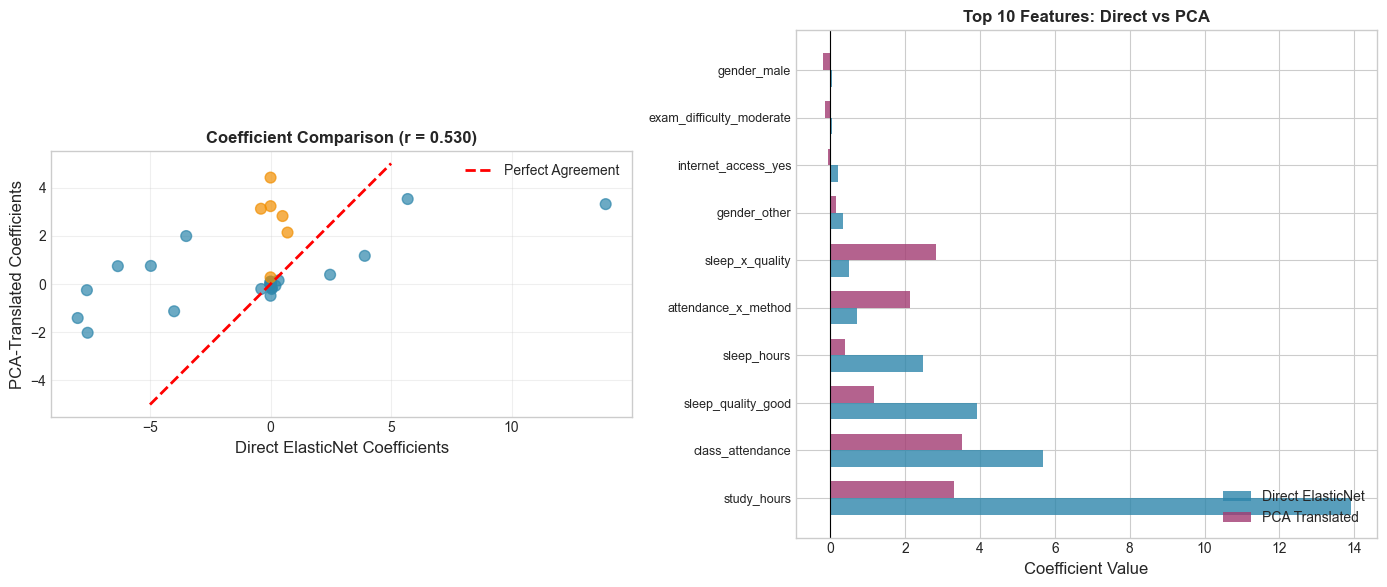


📋 Coefficient Comparison Table (Top 15 by Direct ElasticNet):


Feature  Direct_ElasticNet  PCA_Translated  \
1                  study_hours            13.9005          3.3132   
2   study_method_online videos            -7.9992         -1.4108   
3      study_method_self-study            -7.6172         -0.2563   
4          facility_rating_low            -7.5863         -2.0224   
5     study_method_group study            -6.3343          0.7403   
6             class_attendance             5.6880          3.5251   
7           study_method_mixed            -4.9642          0.7510   
8           sleep_quality_poor            -3.9989         -1.1304   
9           sleep_quality_good             3.9077          1.1683   
10      facility_rating_medium            -3.4976          1.9892   
11                 sleep_hours             2.4699          0.3858   
12         attendance_x_method             0.7041          2.1347   
13             sleep_x_quality             0.4972          2.8192   
14               study_x_sleep            -0.3982          3.1228   
15                 course_b.sc            -0.3850         -0.2061   

    Is_Interaction  
1            False  
2            False  
3            False  
4            False  
5            False  
6            False  
7            False  
8            False  
9            False  
10           False  
11           False  
12            True  
13            True  
14            True  
15           False

In [140]:
# Compare Original vs PCA-Translated Coefficients
print("\n" + "=" * 70)
print("COMPARISON: DIRECT vs PCA-TRANSLATED COEFFICIENTS")
print("=" * 70)

# Merge the two coefficient sets
comparison_df = pd.DataFrame({
    'Feature': all_feature_names_with_interactions,
    'Direct_ElasticNet': elasticnet_cv.coef_,
    'PCA_Translated': original_coefs_from_pca,
    'Is_Interaction': [f in interaction_feature_names for f in all_feature_names_with_interactions]
})

# Calculate correlation between the two
coef_correlation = np.corrcoef(comparison_df['Direct_ElasticNet'], comparison_df['PCA_Translated'])[0, 1]

print(f"\n📊 Coefficient Correlation: {coef_correlation:.4f}")
print("   (1.0 = perfect agreement, 0.0 = no relationship)")

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Scatter plot: Direct vs PCA-Translated
ax1 = axes[0]
colors_scatter = ['#F18F01' if is_int else '#2E86AB' for is_int in comparison_df['Is_Interaction']]
ax1.scatter(comparison_df['Direct_ElasticNet'], comparison_df['PCA_Translated'], 
           c=colors_scatter, alpha=0.7, s=60)
ax1.plot([-5, 5], [-5, 5], 'r--', linewidth=2, label='Perfect Agreement')
ax1.set_xlabel('Direct ElasticNet Coefficients')
ax1.set_ylabel('PCA-Translated Coefficients')
ax1.set_title(f'Coefficient Comparison (r = {coef_correlation:.3f})', fontweight='bold', fontsize=12)
ax1.legend()
ax1.grid(alpha=0.3)
ax1.set_aspect('equal')

# Side-by-side bar plot for top features
ax2 = axes[1]
top_features = comparison_df.nlargest(10, comparison_df['Direct_ElasticNet'].abs().name)
x = np.arange(len(top_features))
width = 0.35

bars1 = ax2.barh(x - width/2, top_features['Direct_ElasticNet'], width, 
                 label='Direct ElasticNet', color='#2E86AB', alpha=0.8)
bars2 = ax2.barh(x + width/2, top_features['PCA_Translated'], width, 
                 label='PCA Translated', color='#A23B72', alpha=0.8)

ax2.set_yticks(x)
ax2.set_yticklabels(top_features['Feature'], fontsize=9)
ax2.axvline(0, color='black', linewidth=0.8)
ax2.set_xlabel('Coefficient Value')
ax2.set_title('Top 10 Features: Direct vs PCA', fontweight='bold', fontsize=12)
ax2.legend(loc='lower right')

plt.tight_layout()
plt.show()

# Display comparison table
print(f"\n📋 Coefficient Comparison Table (Top 15 by Direct ElasticNet):")
comparison_display = comparison_df.copy()
comparison_display['Abs_Direct'] = comparison_display['Direct_ElasticNet'].abs()
comparison_display = comparison_display.nlargest(15, 'Abs_Direct')
comparison_display = comparison_display[['Feature', 'Direct_ElasticNet', 'PCA_Translated', 'Is_Interaction']].round(4)
comparison_display.index = range(1, len(comparison_display) + 1)
display(comparison_display)


In [141]:
# FINAL MODEL SUMMARY
print("\n")
print("╔" + "═" * 78 + "╗")
print("║" + " ELASTICNET LINEAR REGRESSION - FINAL SUMMARY ".center(78) + "║")
print("╚" + "═" * 78 + "╝")

print(f"""
{'─' * 80}
MODEL 1: DIRECT ELASTICNET (Original Features + Interactions)
{'─' * 80}
  Hyperparameters:
    • Alpha (λ):           {elasticnet_cv.alpha_:.6f}
    • L1 Ratio:            {elasticnet_cv.l1_ratio_:.4f}
    
  Training Metrics:
    • R² Score:            {train_r2:.6f}
    • RMSE:                {train_rmse:.4f}
    • MAE:                 {train_mae:.4f}
    
  Feature Selection:
    • Total features:      {len(all_feature_names_with_interactions)}
    • Selected (non-zero): {n_selected}
    • Interaction terms:   {n_interactions_selected} of {len(interaction_feature_names)} selected

{'─' * 80}
MODEL 2: ELASTICNET ON PCA (Translated to Original Features)
{'─' * 80}
  Hyperparameters:
    • Alpha (λ):           {elasticnet_pca.alpha_:.6f}
    • L1 Ratio:            {elasticnet_pca.l1_ratio_:.4f}
    
  Training Metrics:
    • R² Score:            {train_r2_pca:.6f}
    • RMSE:                {train_rmse_pca:.4f}
    
  PCA Components:
    • Total components:    {n_95_int}
    • Selected (non-zero): {coef_pca_model['Selected'].sum()}

{'─' * 80}
COEFFICIENT AGREEMENT
{'─' * 80}
  • Correlation between Direct & PCA-Translated: {coef_correlation:.4f}
""")

# Identify most important features
print("🏆 TOP 5 MOST IMPORTANT FEATURES (by Direct ElasticNet):")
top5 = coef_elasticnet[coef_elasticnet['Selected']].head(5)
for i, (_, row) in enumerate(top5.iterrows(), 1):
    interaction_marker = "🔗" if row['Is_Interaction'] else "  "
    direction = "↑" if row['Coefficient'] > 0 else "↓"
    print(f"   {i}. {interaction_marker} {row['Feature']}: {row['Coefficient']:.4f} {direction}")

print(f"""
{'─' * 80}
INTERPRETATION OF INTERACTION TERMS
{'─' * 80}""")

# Show interaction terms and their effects
interaction_effects = coef_elasticnet[coef_elasticnet['Is_Interaction']]
for _, row in interaction_effects.iterrows():
    effect = "positive" if row['Coefficient'] > 0 else "negative"
    if row['Coefficient'] != 0:
        print(f"  • {row['Feature']}: {row['Coefficient']:.4f}")
        if 'study_x_sleep' in row['Feature']:
            print(f"    → Study-rest balance has {effect} impact on exam score")
        elif 'study_x_attendance' in row['Feature']:
            print(f"    → Self-study + class attendance interaction is {effect}")
        elif 'study_squared' in row['Feature']:
            if row['Coefficient'] < 0:
                print(f"    → Diminishing returns on studying (quadratic effect)")
            else:
                print(f"    → Increasing returns on studying")
        elif 'sleep_x_quality' in row['Feature']:
            print(f"    → Sleep quality amplifies sleep hours effect ({effect})")
        elif 'study_x_difficulty' in row['Feature']:
            print(f"    → Study hours effect varies with exam difficulty ({effect})")
        elif 'attendance_x_method' in row['Feature']:
            print(f"    → Attendance effect varies by study method ({effect})")

print(f"""
{'═' * 80}
NOTE: Validation and Test set evaluation saved for model comparison phase.
{'═' * 80}
""")




╔══════════════════════════════════════════════════════════════════════════════╗
║                 ELASTICNET LINEAR REGRESSION - FINAL SUMMARY                 ║
╚══════════════════════════════════════════════════════════════════════════════╝

────────────────────────────────────────────────────────────────────────────────
MODEL 1: DIRECT ELASTICNET (Original Features + Interactions)
────────────────────────────────────────────────────────────────────────────────
  Hyperparameters:
    • Alpha (λ):           0.014592
    • L1 Ratio:            0.9900

  Training Metrics:
    • R² Score:            0.731283
    • RMSE:                9.8096
    • MAE:                 7.8676

  Feature Selection:
    • Total features:      29
    • Selected (non-zero): 20
    • Interaction terms:   3 of 6 selected

────────────────────────────────────────────────────────────────────────────────
MODEL 2: ELASTICNET ON PCA (Translated to Original Features)
────────────────────────────────────────────────

In [142]:
# Store models and data for later comparison
print("=" * 70)
print("SAVING MODEL OBJECTS FOR LATER COMPARISON")
print("=" * 70)

# Store all relevant objects in a dictionary
linear_regression_results = {
    'elasticnet_direct': {
        'model': elasticnet_cv,
        'feature_names': all_feature_names_with_interactions,
        'X_train': X_train_with_interactions,
        'y_train': y_train,
        'train_r2': train_r2,
        'train_rmse': train_rmse,
        'train_mae': train_mae,
        'coefficients': coef_elasticnet,
        'scaler_interactions': scaler_interactions
    },
    'elasticnet_pca': {
        'model': elasticnet_pca,
        'pca_transformer': pca_model_int,
        'X_train_pca': X_train_pca_int,
        'train_r2': train_r2_pca,
        'train_rmse': train_rmse_pca,
        'translated_coefficients': translated_coef_df
    },
    'preprocessing': {
        'preprocessor': preprocessor_clean,
        'interaction_creator': create_interaction_features,
        'all_feature_names': all_feature_names_with_interactions
    }
}

print("""
✅ Objects saved for model comparison:

   linear_regression_results['elasticnet_direct']
     • Trained ElasticNetCV model
     • Feature names and coefficients
     • Training metrics (R², RMSE, MAE)
   
   linear_regression_results['elasticnet_pca']
     • Trained ElasticNetCV on PCA
     • PCA transformer for new data
     • Translated coefficients
   
   linear_regression_results['preprocessing']
     • Preprocessor (scaling + encoding)
     • Interaction feature creator function
""")

print("=" * 70)
print("LINEAR REGRESSION WITH INTERACTIONS - COMPLETE")
print("=" * 70)


SAVING MODEL OBJECTS FOR LATER COMPARISON

✅ Objects saved for model comparison:

   linear_regression_results['elasticnet_direct']
     • Trained ElasticNetCV model
     • Feature names and coefficients
     • Training metrics (R², RMSE, MAE)

   linear_regression_results['elasticnet_pca']
     • Trained ElasticNetCV on PCA
     • PCA transformer for new data
     • Translated coefficients

   linear_regression_results['preprocessing']
     • Preprocessor (scaling + encoding)
     • Interaction feature creator function

LINEAR REGRESSION WITH INTERACTIONS - COMPLETE


## 12. Random Forest Models

Building **3 Random Forest regression models** for comparison:

| Model | Features | Description |
|-------|----------|-------------|
| **RF-Full** | All original features + interactions | Baseline with all features |
| **RF-Selected** | ElasticNet-selected features only | Features with non-zero coefficients |
| **RF-PCA** | PCA components | Dimensionality-reduced version |


In [143]:
# Import Random Forest
from sklearn.ensemble import RandomForestRegressor

print("╔" + "═" * 78 + "╗")
print("║" + " RANDOM FOREST MODELS ".center(78) + "║")
print("╚" + "═" * 78 + "╝")

# Define consistent hyperparameters for fair comparison
RF_PARAMS = {
    'n_estimators': 100,
    'max_depth': None,        # Let trees grow fully initially
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'random_state': 42,
    'n_jobs': -1
}

print("\n📋 Random Forest Hyperparameters (consistent across all models):")
for param, value in RF_PARAMS.items():
    print(f"   • {param}: {value}")


╔══════════════════════════════════════════════════════════════════════════════╗
║                             RANDOM FOREST MODELS                             ║
╚══════════════════════════════════════════════════════════════════════════════╝

📋 Random Forest Hyperparameters (consistent across all models):
   • n_estimators: 100
   • max_depth: None
   • min_samples_split: 5
   • min_samples_leaf: 2
   • random_state: 42
   • n_jobs: -1


In [144]:
# MODEL 1: RF-FULL (All Original Features + Interactions)
print("\n" + "=" * 70)
print("MODEL 1: RF-FULL (All Features + Interactions)")
print("=" * 70)

print(f"\n🔄 Training Random Forest on all {X_train_with_interactions.shape[1]} features...")

rf_full = RandomForestRegressor(**RF_PARAMS)
rf_full.fit(X_train_with_interactions, y_train)

# Training predictions and metrics
y_train_pred_rf_full = rf_full.predict(X_train_with_interactions)
rf_full_train_r2 = r2_score(y_train, y_train_pred_rf_full)
rf_full_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_rf_full))
rf_full_train_mae = mean_absolute_error(y_train, y_train_pred_rf_full)

print(f"\n✅ RF-FULL Training Complete!")
print(f"\n{'─' * 50}")
print("TRAINING METRICS")
print(f"{'─' * 50}")
print(f"   Features used: {X_train_with_interactions.shape[1]}")
print(f"   R² Score:      {rf_full_train_r2:.6f}")
print(f"   RMSE:          {rf_full_train_rmse:.4f}")
print(f"   MAE:           {rf_full_train_mae:.4f}")

# Feature importance
rf_full_importance = pd.DataFrame({
    'Feature': all_feature_names_with_interactions,
    'Importance': rf_full.feature_importances_,
    'Is_Interaction': [f in interaction_feature_names for f in all_feature_names_with_interactions]
}).sort_values('Importance', ascending=False)
rf_full_importance.index = range(1, len(rf_full_importance) + 1)

print(f"\n📋 Top 10 Most Important Features (RF-Full):")
display(rf_full_importance.head(10))



MODEL 1: RF-FULL (All Features + Interactions)

🔄 Training Random Forest on all 29 features...

✅ RF-FULL Training Complete!

──────────────────────────────────────────────────
TRAINING METRICS
──────────────────────────────────────────────────
   Features used: 29
   R² Score:      0.933228
   RMSE:          4.8899
   MAE:           3.7935

📋 Top 10 Most Important Features (RF-Full):


Feature  Importance  Is_Interaction
1    study_x_attendance    0.646881            True
2       sleep_x_quality    0.069620            True
3   attendance_x_method    0.047740            True
4      class_attendance    0.041500           False
5         study_x_sleep    0.032726            True
6           sleep_hours    0.023788           False
7   facility_rating_low    0.021557           False
8    study_x_difficulty    0.019981            True
9                   age    0.017151           False
10          study_hours    0.014774           False

In [145]:
# MODEL 2: RF-SELECTED (ElasticNet-Selected Features Only)
print("\n" + "=" * 70)
print("MODEL 2: RF-SELECTED (ElasticNet-Selected Features Only)")
print("=" * 70)

# Get selected features from ElasticNet (non-zero coefficients)
selected_features_mask = elasticnet_cv.coef_ != 0
selected_feature_names = [f for f, selected in zip(all_feature_names_with_interactions, selected_features_mask) if selected]
selected_feature_indices = np.where(selected_features_mask)[0]

print(f"\n📋 ElasticNet Selected Features ({len(selected_feature_names)}):")
for i, name in enumerate(selected_feature_names, 1):
    marker = "🔗" if name in interaction_feature_names else "  "
    print(f"   {marker} {i}. {name}")

# Create selected features dataset
X_train_selected = X_train_with_interactions[:, selected_feature_indices]

print(f"\n🔄 Training Random Forest on {X_train_selected.shape[1]} selected features...")

rf_selected = RandomForestRegressor(**RF_PARAMS)
rf_selected.fit(X_train_selected, y_train)

# Training predictions and metrics
y_train_pred_rf_selected = rf_selected.predict(X_train_selected)
rf_selected_train_r2 = r2_score(y_train, y_train_pred_rf_selected)
rf_selected_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_rf_selected))
rf_selected_train_mae = mean_absolute_error(y_train, y_train_pred_rf_selected)

print(f"\n✅ RF-SELECTED Training Complete!")
print(f"\n{'─' * 50}")
print("TRAINING METRICS")
print(f"{'─' * 50}")
print(f"   Features used: {X_train_selected.shape[1]}")
print(f"   R² Score:      {rf_selected_train_r2:.6f}")
print(f"   RMSE:          {rf_selected_train_rmse:.4f}")
print(f"   MAE:           {rf_selected_train_mae:.4f}")

# Feature importance
rf_selected_importance = pd.DataFrame({
    'Feature': selected_feature_names,
    'Importance': rf_selected.feature_importances_,
    'Is_Interaction': [f in interaction_feature_names for f in selected_feature_names]
}).sort_values('Importance', ascending=False)
rf_selected_importance.index = range(1, len(rf_selected_importance) + 1)

print(f"\n📋 Feature Importance (RF-Selected):")
display(rf_selected_importance)



MODEL 2: RF-SELECTED (ElasticNet-Selected Features Only)

📋 ElasticNet Selected Features (20):
      1. age
      2. study_hours
      3. class_attendance
      4. sleep_hours
      5. gender_male
      6. gender_other
      7. course_b.sc
      8. internet_access_yes
      9. sleep_quality_good
      10. sleep_quality_poor
      11. study_method_group study
      12. study_method_mixed
      13. study_method_online videos
      14. study_method_self-study
      15. facility_rating_low
      16. facility_rating_medium
      17. exam_difficulty_moderate
   🔗 18. study_x_sleep
   🔗 19. sleep_x_quality
   🔗 20. attendance_x_method

🔄 Training Random Forest on 20 selected features...



✅ RF-SELECTED Training Complete!

──────────────────────────────────────────────────
TRAINING METRICS
──────────────────────────────────────────────────
   Features used: 20
   R² Score:      0.929670
   RMSE:          5.0185
   MAE:           3.9004

📋 Feature Importance (RF-Selected):


Feature  Importance  Is_Interaction
1                  study_hours    0.496698           False
2             class_attendance    0.138868           False
3                study_x_sleep    0.128214            True
4              sleep_x_quality    0.064918            True
5          attendance_x_method    0.061697            True
6                  sleep_hours    0.024776           False
7          facility_rating_low    0.021504           False
8                          age    0.021187           False
9       facility_rating_medium    0.006251           False
10    exam_difficulty_moderate    0.005660           False
11                gender_other    0.005097           False
12                 gender_male    0.004971           False
13         internet_access_yes    0.003631           False
14                 course_b.sc    0.003372           False
15          study_method_mixed    0.002891           False
16    study_method_group study    0.002646           False
17          sleep_quality_poor    0.002355           False
18  study_method_online videos    0.002320           False
19          sleep_quality_good    0.001892           False
20     study_method_self-study    0.001053           False

In [146]:
# MODEL 3: RF-PCA (PCA Components)
print("\n" + "=" * 70)
print("MODEL 3: RF-PCA (PCA Components)")
print("=" * 70)

print(f"\n🔄 Training Random Forest on {X_train_pca_int.shape[1]} PCA components...")

rf_pca = RandomForestRegressor(**RF_PARAMS)
rf_pca.fit(X_train_pca_int, y_train)

# Training predictions and metrics
y_train_pred_rf_pca = rf_pca.predict(X_train_pca_int)
rf_pca_train_r2 = r2_score(y_train, y_train_pred_rf_pca)
rf_pca_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_rf_pca))
rf_pca_train_mae = mean_absolute_error(y_train, y_train_pred_rf_pca)

print(f"\n✅ RF-PCA Training Complete!")
print(f"\n{'─' * 50}")
print("TRAINING METRICS")
print(f"{'─' * 50}")
print(f"   PCA Components: {X_train_pca_int.shape[1]}")
print(f"   R² Score:       {rf_pca_train_r2:.6f}")
print(f"   RMSE:           {rf_pca_train_rmse:.4f}")
print(f"   MAE:            {rf_pca_train_mae:.4f}")

# PCA Component importance
rf_pca_importance = pd.DataFrame({
    'Component': pca_int_feature_names,
    'Importance': rf_pca.feature_importances_
}).sort_values('Importance', ascending=False)
rf_pca_importance.index = range(1, len(rf_pca_importance) + 1)

print(f"\n📋 PCA Component Importance (RF-PCA):")
display(rf_pca_importance)



MODEL 3: RF-PCA (PCA Components)

🔄 Training Random Forest on 18 PCA components...

✅ RF-PCA Training Complete!

──────────────────────────────────────────────────
TRAINING METRICS
──────────────────────────────────────────────────
   PCA Components: 18
   R² Score:       0.941242
   RMSE:           4.5871
   MAE:            3.5582

📋 PCA Component Importance (RF-PCA):


Component  Importance
1        PC1    0.606699
2        PC3    0.115053
3        PC8    0.027260
4        PC6    0.022478
5        PC5    0.021913
6       PC12    0.021768
7        PC9    0.020754
8       PC11    0.019881
9        PC7    0.019551
10       PC2    0.018168
11       PC4    0.016224
12      PC18    0.014696
13      PC13    0.013962
14      PC10    0.013525
15      PC14    0.012689
16      PC16    0.012112
17      PC17    0.012032
18      PC15    0.011233



╔══════════════════════════════════════════════════════════════════════════════╗
║                      RANDOM FOREST MODELS - COMPARISON                       ║
╚══════════════════════════════════════════════════════════════════════════════╝

📊 TRAINING METRICS COMPARISON


Model  Features  R² (Train)  RMSE (Train)  MAE (Train)
1      RF-Full        29    0.933228      4.889922     3.793544
2  RF-Selected        20    0.929670      5.018489     3.900365
3       RF-PCA        18    0.941242      4.587102     3.558177


🏆 Best Training R²: RF-PCA (0.941242)


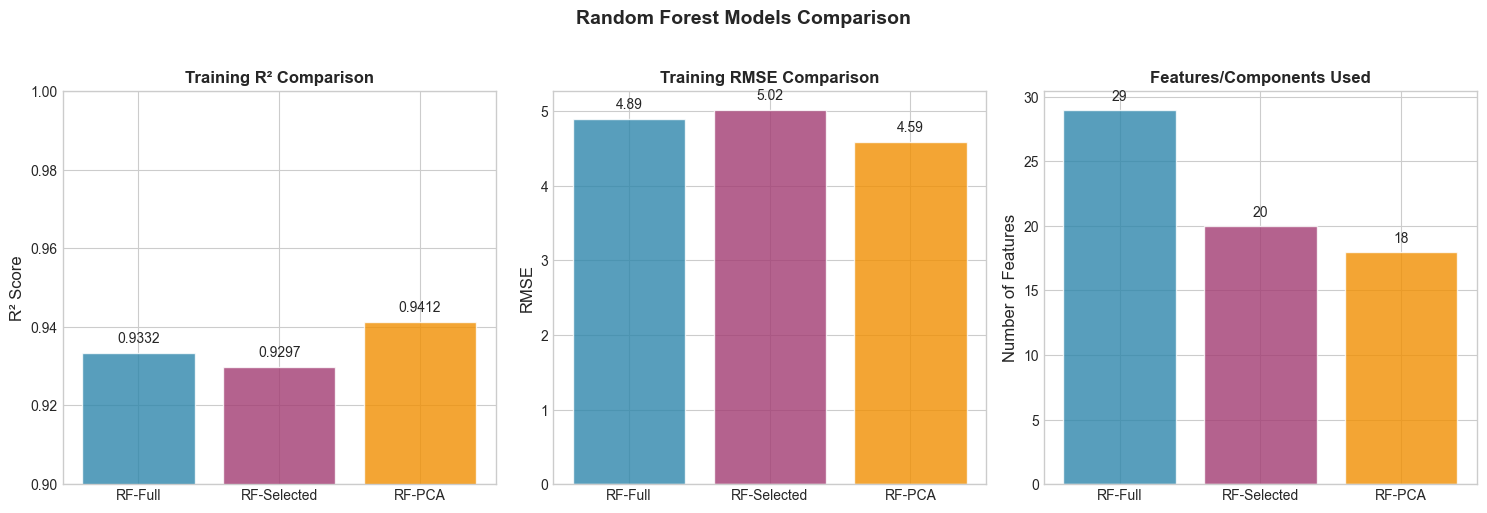

In [147]:
# RANDOM FOREST MODEL COMPARISON
print("\n")
print("╔" + "═" * 78 + "╗")
print("║" + " RANDOM FOREST MODELS - COMPARISON ".center(78) + "║")
print("╚" + "═" * 78 + "╝")

# Create comparison table
rf_comparison = pd.DataFrame({
    'Model': ['RF-Full', 'RF-Selected', 'RF-PCA'],
    'Features': [X_train_with_interactions.shape[1], X_train_selected.shape[1], X_train_pca_int.shape[1]],
    'R² (Train)': [rf_full_train_r2, rf_selected_train_r2, rf_pca_train_r2],
    'RMSE (Train)': [rf_full_train_rmse, rf_selected_train_rmse, rf_pca_train_rmse],
    'MAE (Train)': [rf_full_train_mae, rf_selected_train_mae, rf_pca_train_mae]
}).round(6)
rf_comparison.index = range(1, len(rf_comparison) + 1)

print("\n📊 TRAINING METRICS COMPARISON")
print("=" * 70)
display(rf_comparison)

# Determine best model
best_r2_idx = rf_comparison['R² (Train)'].idxmax()
best_model = rf_comparison.loc[best_r2_idx, 'Model']

print(f"\n🏆 Best Training R²: {best_model} ({rf_comparison.loc[best_r2_idx, 'R² (Train)']:.6f})")

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# R² Comparison
ax1 = axes[0]
models = ['RF-Full', 'RF-Selected', 'RF-PCA']
r2_values = [rf_full_train_r2, rf_selected_train_r2, rf_pca_train_r2]
colors = ['#2E86AB', '#A23B72', '#F18F01']
bars1 = ax1.bar(models, r2_values, color=colors, edgecolor='white', alpha=0.8)
ax1.set_ylabel('R² Score')
ax1.set_title('Training R² Comparison', fontweight='bold', fontsize=12)
ax1.set_ylim(0.9, 1.0)
for bar, val in zip(bars1, r2_values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, 
             f'{val:.4f}', ha='center', va='bottom', fontsize=10)

# RMSE Comparison
ax2 = axes[1]
rmse_values = [rf_full_train_rmse, rf_selected_train_rmse, rf_pca_train_rmse]
bars2 = ax2.bar(models, rmse_values, color=colors, edgecolor='white', alpha=0.8)
ax2.set_ylabel('RMSE')
ax2.set_title('Training RMSE Comparison', fontweight='bold', fontsize=12)
for bar, val in zip(bars2, rmse_values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'{val:.2f}', ha='center', va='bottom', fontsize=10)

# Number of Features
ax3 = axes[2]
n_features = [X_train_with_interactions.shape[1], X_train_selected.shape[1], X_train_pca_int.shape[1]]
bars3 = ax3.bar(models, n_features, color=colors, edgecolor='white', alpha=0.8)
ax3.set_ylabel('Number of Features')
ax3.set_title('Features/Components Used', fontweight='bold', fontsize=12)
for bar, val in zip(bars3, n_features):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{val}', ha='center', va='bottom', fontsize=10)

plt.suptitle('Random Forest Models Comparison', fontweight='bold', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()



FEATURE IMPORTANCE COMPARISON


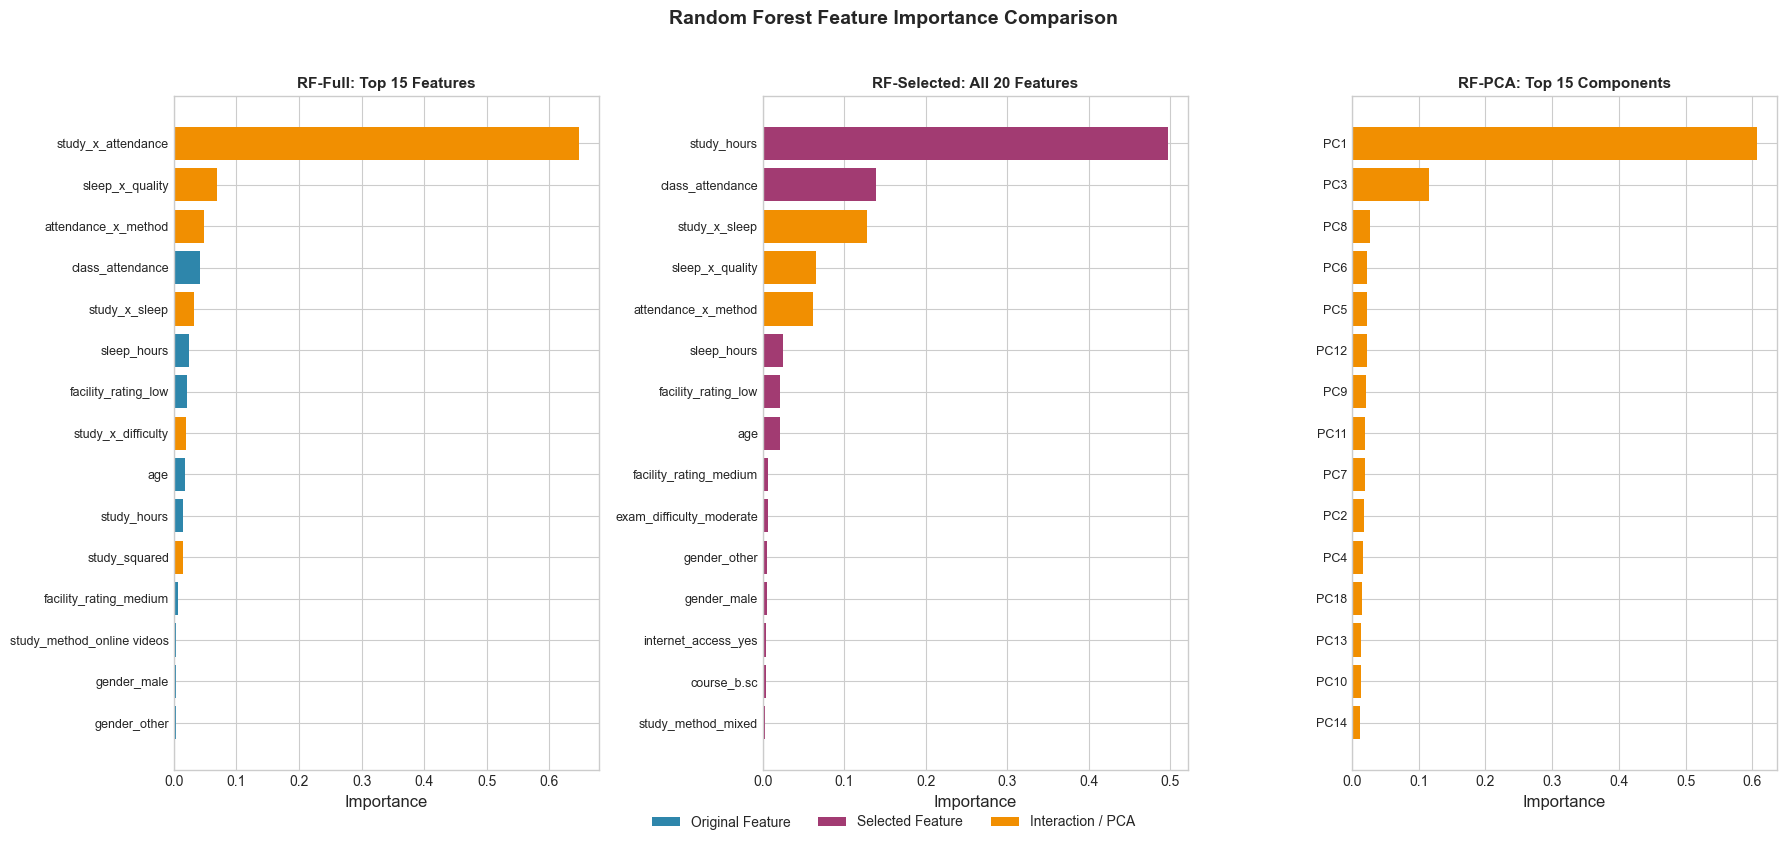

In [148]:
# Feature Importance Comparison Visualization
print("\n" + "=" * 70)
print("FEATURE IMPORTANCE COMPARISON")
print("=" * 70)

fig, axes = plt.subplots(1, 3, figsize=(18, 8))

# RF-Full Feature Importance
ax1 = axes[0]
top_n = 15
rf_full_top = rf_full_importance.head(top_n)
colors_full = ['#F18F01' if is_int else '#2E86AB' for is_int in rf_full_top['Is_Interaction']]
ax1.barh(range(len(rf_full_top)), rf_full_top['Importance'].values, color=colors_full)
ax1.set_yticks(range(len(rf_full_top)))
ax1.set_yticklabels(rf_full_top['Feature'], fontsize=9)
ax1.invert_yaxis()
ax1.set_xlabel('Importance')
ax1.set_title(f'RF-Full: Top {top_n} Features', fontweight='bold', fontsize=11)

# RF-Selected Feature Importance
ax2 = axes[1]
rf_selected_top = rf_selected_importance.head(min(top_n, len(rf_selected_importance)))
colors_selected = ['#F18F01' if is_int else '#A23B72' for is_int in rf_selected_top['Is_Interaction']]
ax2.barh(range(len(rf_selected_top)), rf_selected_top['Importance'].values, color=colors_selected)
ax2.set_yticks(range(len(rf_selected_top)))
ax2.set_yticklabels(rf_selected_top['Feature'], fontsize=9)
ax2.invert_yaxis()
ax2.set_xlabel('Importance')
ax2.set_title(f'RF-Selected: All {len(rf_selected_importance)} Features', fontweight='bold', fontsize=11)

# RF-PCA Component Importance
ax3 = axes[2]
rf_pca_top = rf_pca_importance.head(top_n)
ax3.barh(range(len(rf_pca_top)), rf_pca_top['Importance'].values, color='#F18F01')
ax3.set_yticks(range(len(rf_pca_top)))
ax3.set_yticklabels(rf_pca_top['Component'], fontsize=9)
ax3.invert_yaxis()
ax3.set_xlabel('Importance')
ax3.set_title(f'RF-PCA: Top {top_n} Components', fontweight='bold', fontsize=11)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2E86AB', label='Original Feature'),
    Patch(facecolor='#A23B72', label='Selected Feature'),
    Patch(facecolor='#F18F01', label='Interaction / PCA')
]
fig.legend(handles=legend_elements, loc='lower center', ncol=3, fontsize=10, bbox_to_anchor=(0.5, -0.02))

plt.suptitle('Random Forest Feature Importance Comparison', fontweight='bold', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


In [149]:
# FINAL RANDOM FOREST SUMMARY
print("\n")
print("╔" + "═" * 78 + "╗")
print("║" + " RANDOM FOREST MODELS - FINAL SUMMARY ".center(78) + "║")
print("╚" + "═" * 78 + "╝")

print(f"""
{'─' * 80}
MODEL 1: RF-FULL (All Features + Interactions)
{'─' * 80}
  Configuration:
    • Features:        {X_train_with_interactions.shape[1]} (original + interactions)
    • Trees:           {RF_PARAMS['n_estimators']}
    • Max Depth:       {RF_PARAMS['max_depth']} (unlimited)
    
  Training Metrics:
    • R² Score:        {rf_full_train_r2:.6f}
    • RMSE:            {rf_full_train_rmse:.4f}
    • MAE:             {rf_full_train_mae:.4f}
    
  Top 3 Important Features:
    1. {rf_full_importance.iloc[0]['Feature']}: {rf_full_importance.iloc[0]['Importance']:.4f}
    2. {rf_full_importance.iloc[1]['Feature']}: {rf_full_importance.iloc[1]['Importance']:.4f}
    3. {rf_full_importance.iloc[2]['Feature']}: {rf_full_importance.iloc[2]['Importance']:.4f}

{'─' * 80}
MODEL 2: RF-SELECTED (ElasticNet-Selected Features Only)
{'─' * 80}
  Configuration:
    • Features:        {X_train_selected.shape[1]} (selected by ElasticNet)
    • Trees:           {RF_PARAMS['n_estimators']}
    • Max Depth:       {RF_PARAMS['max_depth']} (unlimited)
    
  Training Metrics:
    • R² Score:        {rf_selected_train_r2:.6f}
    • RMSE:            {rf_selected_train_rmse:.4f}
    • MAE:             {rf_selected_train_mae:.4f}
    
  Top 3 Important Features:
    1. {rf_selected_importance.iloc[0]['Feature']}: {rf_selected_importance.iloc[0]['Importance']:.4f}
    2. {rf_selected_importance.iloc[1]['Feature']}: {rf_selected_importance.iloc[1]['Importance']:.4f}
    3. {rf_selected_importance.iloc[2]['Feature']}: {rf_selected_importance.iloc[2]['Importance']:.4f}

{'─' * 80}
MODEL 3: RF-PCA (PCA Components)
{'─' * 80}
  Configuration:
    • PCA Components:  {X_train_pca_int.shape[1]} (95% variance)
    • Trees:           {RF_PARAMS['n_estimators']}
    • Max Depth:       {RF_PARAMS['max_depth']} (unlimited)
    
  Training Metrics:
    • R² Score:        {rf_pca_train_r2:.6f}
    • RMSE:            {rf_pca_train_rmse:.4f}
    • MAE:             {rf_pca_train_mae:.4f}
    
  Top 3 Important Components:
    1. {rf_pca_importance.iloc[0]['Component']}: {rf_pca_importance.iloc[0]['Importance']:.4f}
    2. {rf_pca_importance.iloc[1]['Component']}: {rf_pca_importance.iloc[1]['Importance']:.4f}
    3. {rf_pca_importance.iloc[2]['Component']}: {rf_pca_importance.iloc[2]['Importance']:.4f}

{'═' * 80}
⚠️  NOTE ON OVERFITTING
{'═' * 80}
  Training R² values near 1.0 suggest potential overfitting.
  This is expected with unlimited depth Random Forests.
  
  Validation/Test metrics will be compared in the model comparison phase
  to assess true generalization performance.
  
{'═' * 80}
""")

# Store RF models for later comparison
random_forest_results = {
    'rf_full': {
        'model': rf_full,
        'feature_names': all_feature_names_with_interactions,
        'X_train': X_train_with_interactions,
        'train_r2': rf_full_train_r2,
        'train_rmse': rf_full_train_rmse,
        'train_mae': rf_full_train_mae,
        'feature_importance': rf_full_importance
    },
    'rf_selected': {
        'model': rf_selected,
        'feature_names': selected_feature_names,
        'feature_indices': selected_feature_indices,
        'X_train': X_train_selected,
        'train_r2': rf_selected_train_r2,
        'train_rmse': rf_selected_train_rmse,
        'train_mae': rf_selected_train_mae,
        'feature_importance': rf_selected_importance
    },
    'rf_pca': {
        'model': rf_pca,
        'pca_transformer': pca_model_int,
        'X_train': X_train_pca_int,
        'train_r2': rf_pca_train_r2,
        'train_rmse': rf_pca_train_rmse,
        'train_mae': rf_pca_train_mae,
        'component_importance': rf_pca_importance
    }
}

print("✅ Random Forest models saved for later comparison.")
print("\n" + "=" * 70)
print("RANDOM FOREST MODEL DEVELOPMENT - COMPLETE")
print("=" * 70)




╔══════════════════════════════════════════════════════════════════════════════╗
║                     RANDOM FOREST MODELS - FINAL SUMMARY                     ║
╚══════════════════════════════════════════════════════════════════════════════╝

────────────────────────────────────────────────────────────────────────────────
MODEL 1: RF-FULL (All Features + Interactions)
────────────────────────────────────────────────────────────────────────────────
  Configuration:
    • Features:        29 (original + interactions)
    • Trees:           100
    • Max Depth:       None (unlimited)

  Training Metrics:
    • R² Score:        0.933228
    • RMSE:            4.8899
    • MAE:             3.7935

  Top 3 Important Features:
    1. study_x_attendance: 0.6469
    2. sleep_x_quality: 0.0696
    3. attendance_x_method: 0.0477

────────────────────────────────────────────────────────────────────────────────
MODEL 2: RF-SELECTED (ElasticNet-Selected Features Only)
────────────────────────────

## 13. XGBoost Models

Building **3 XGBoost regression models** for comparison:

| Model | Features | Description |
|-------|----------|-------------|
| **XGB-Full** | All features | Original + Interactions |
| **XGB-Selected** | Selected features | ElasticNet selected features only |
| **XGB-PCA** | PCA components | PCA-transformed features (95% variance) |

**XGBoost Hyperparameters:**
- `n_estimators=200` - More trees for better performance
- `max_depth=6` - Moderate depth to prevent overfitting
- `learning_rate=0.1` - Standard learning rate
- `subsample=0.8` - Row sampling for regularization
- `colsample_bytree=0.8` - Column sampling for regularization
- `random_state=42` - For reproducibility


In [150]:
# Install XGBoost if needed
# !pip install xgboost

from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

print("="*80)
print("║" + " XGBOOST MODELS ".center(78) + "║")
print("="*80)

# XGBoost hyperparameters (consistent across all models)
XGB_PARAMS = {
    'n_estimators': 200,
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'n_jobs': -1,
    'verbosity': 0
}

print("\n📋 XGBoost Hyperparameters (consistent across all models):")
for param, value in XGB_PARAMS.items():
    if param != 'verbosity':
        print(f"   • {param}: {value}")
print("\n" + "-"*80)


║                                XGBOOST MODELS                                ║

📋 XGBoost Hyperparameters (consistent across all models):
   • n_estimators: 200
   • max_depth: 6
   • learning_rate: 0.1
   • subsample: 0.8
   • colsample_bytree: 0.8
   • random_state: 42
   • n_jobs: -1

--------------------------------------------------------------------------------


In [151]:
# MODEL 1: XGB-FULL (All Original Features + Interactions)

print("MODEL 1: XGB-FULL (All Features + Interactions)")
print("-"*80)

# Train XGBoost on full feature set
xgb_full = XGBRegressor(**XGB_PARAMS)
xgb_full.fit(X_train_with_interactions, y_train)

# Predict on training set
y_train_pred_xgb_full = xgb_full.predict(X_train_with_interactions)

# Calculate metrics
xgb_full_train_r2 = r2_score(y_train, y_train_pred_xgb_full)
xgb_full_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_xgb_full))
xgb_full_train_mae = mean_absolute_error(y_train, y_train_pred_xgb_full)

print(f"  Configuration:")
print(f"    • Features:        {X_train_with_interactions.shape[1]} (original + interactions)")
print(f"    • Estimators:      {XGB_PARAMS['n_estimators']}")
print(f"    • Max Depth:       {XGB_PARAMS['max_depth']}")
print(f"    • Learning Rate:   {XGB_PARAMS['learning_rate']}")

print(f"\n  Training Metrics:")
print(f"    • R² Score:        {xgb_full_train_r2:.6f}")
print(f"    • RMSE:            {xgb_full_train_rmse:.4f}")
print(f"    • MAE:             {xgb_full_train_mae:.4f}")

# Get feature importance (use all_feature_names_with_interactions from RF section)
xgb_full_importance = pd.DataFrame({
    'Feature': all_feature_names_with_interactions,
    'Importance': xgb_full.feature_importances_
}).sort_values('Importance', ascending=False).reset_index(drop=True)

print(f"\n  Top 3 Important Features:")
for i, row in xgb_full_importance.head(3).iterrows():
    print(f"    {i+1}. {row['Feature']}: {row['Importance']:.4f}")

print("\n" + "-"*80)


MODEL 1: XGB-FULL (All Features + Interactions)
--------------------------------------------------------------------------------
  Configuration:
    • Features:        29 (original + interactions)
    • Estimators:      200
    • Max Depth:       6
    • Learning Rate:   0.1

  Training Metrics:
    • R² Score:        0.848952
    • RMSE:            7.3546
    • MAE:             5.8288

  Top 3 Important Features:
    1. study_x_attendance: 0.3353
    2. study_hours: 0.0986
    3. facility_rating_low: 0.0630

--------------------------------------------------------------------------------


In [152]:
# MODEL 2: XGB-SELECTED (ElasticNet-Selected Features Only)

print("MODEL 2: XGB-SELECTED (ElasticNet-Selected Features Only)")
print("-"*80)

# Use same selected features as Random Forest (X_train_selected already exists from RF section)
# Train XGBoost on selected features
xgb_selected = XGBRegressor(**XGB_PARAMS)
xgb_selected.fit(X_train_selected, y_train)

# Predict on training set
y_train_pred_xgb_selected = xgb_selected.predict(X_train_selected)

# Calculate metrics
xgb_selected_train_r2 = r2_score(y_train, y_train_pred_xgb_selected)
xgb_selected_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_xgb_selected))
xgb_selected_train_mae = mean_absolute_error(y_train, y_train_pred_xgb_selected)

print(f"  Configuration:")
print(f"    • Features:        {X_train_selected.shape[1]} (selected by ElasticNet)")
print(f"    • Estimators:      {XGB_PARAMS['n_estimators']}")
print(f"    • Max Depth:       {XGB_PARAMS['max_depth']}")
print(f"    • Learning Rate:   {XGB_PARAMS['learning_rate']}")

print(f"\n  Training Metrics:")
print(f"    • R² Score:        {xgb_selected_train_r2:.6f}")
print(f"    • RMSE:            {xgb_selected_train_rmse:.4f}")
print(f"    • MAE:             {xgb_selected_train_mae:.4f}")

# Get feature importance (use selected_feature_names from RF section)
xgb_selected_importance = pd.DataFrame({
    'Feature': selected_feature_names,
    'Importance': xgb_selected.feature_importances_
}).sort_values('Importance', ascending=False).reset_index(drop=True)

print(f"\n  Top 3 Important Features:")
for i, row in xgb_selected_importance.head(3).iterrows():
    print(f"    {i+1}. {row['Feature']}: {row['Importance']:.4f}")

print("\n" + "-"*80)


MODEL 2: XGB-SELECTED (ElasticNet-Selected Features Only)
--------------------------------------------------------------------------------
  Configuration:
    • Features:        20 (selected by ElasticNet)
    • Estimators:      200
    • Max Depth:       6
    • Learning Rate:   0.1

  Training Metrics:
    • R² Score:        0.843683
    • RMSE:            7.4818
    • MAE:             5.9388

  Top 3 Important Features:
    1. study_hours: 0.2573
    2. study_x_sleep: 0.1237
    3. facility_rating_low: 0.1042

--------------------------------------------------------------------------------


In [153]:
# MODEL 3: XGB-PCA (PCA Components)

print("MODEL 3: XGB-PCA (PCA Components)")
print("-"*80)

# Train XGBoost on PCA components
xgb_pca = XGBRegressor(**XGB_PARAMS)
xgb_pca.fit(X_train_pca_int, y_train)

# Predict on training set
y_train_pred_xgb_pca = xgb_pca.predict(X_train_pca_int)

# Calculate metrics
xgb_pca_train_r2 = r2_score(y_train, y_train_pred_xgb_pca)
xgb_pca_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_xgb_pca))
xgb_pca_train_mae = mean_absolute_error(y_train, y_train_pred_xgb_pca)

print(f"  Configuration:")
print(f"    • PCA Components:  {X_train_pca_int.shape[1]} (95% variance)")
print(f"    • Estimators:      {XGB_PARAMS['n_estimators']}")
print(f"    • Max Depth:       {XGB_PARAMS['max_depth']}")
print(f"    • Learning Rate:   {XGB_PARAMS['learning_rate']}")

print(f"\n  Training Metrics:")
print(f"    • R² Score:        {xgb_pca_train_r2:.6f}")
print(f"    • RMSE:            {xgb_pca_train_rmse:.4f}")
print(f"    • MAE:             {xgb_pca_train_mae:.4f}")

# Get feature importance for PCA components
xgb_pca_importance = pd.DataFrame({
    'Component': [f'PC{i+1}' for i in range(X_train_pca_int.shape[1])],
    'Importance': xgb_pca.feature_importances_
}).sort_values('Importance', ascending=False).reset_index(drop=True)

print(f"\n  Top 3 Important Components:")
for i, row in xgb_pca_importance.head(3).iterrows():
    print(f"    {i+1}. {row['Component']}: {row['Importance']:.4f}")

print("\n" + "="*80)


MODEL 3: XGB-PCA (PCA Components)
--------------------------------------------------------------------------------
  Configuration:
    • PCA Components:  18 (95% variance)
    • Estimators:      200
    • Max Depth:       6
    • Learning Rate:   0.1

  Training Metrics:
    • R² Score:        0.865395
    • RMSE:            6.9428
    • MAE:             5.5227

  Top 3 Important Components:
    1. PC1: 0.5209
    2. PC3: 0.1050
    3. PC12: 0.0424





╔══════════════════════════════════════════════════════════════════════════════╗
║                         XGBOOST MODELS - COMPARISON                          ║
╚══════════════════════════════════════════════════════════════════════════════╝

📊 TRAINING METRICS COMPARISON


Model  Features  R² (Train)  RMSE (Train)  MAE (Train)
1      XGB-Full        29    0.848952      7.354635     5.828832
2  XGB-Selected        20    0.843683      7.481812     5.938800
3       XGB-PCA        18    0.865395      6.942791     5.522704


🏆 Best Training R²: XGB-PCA (0.865395)


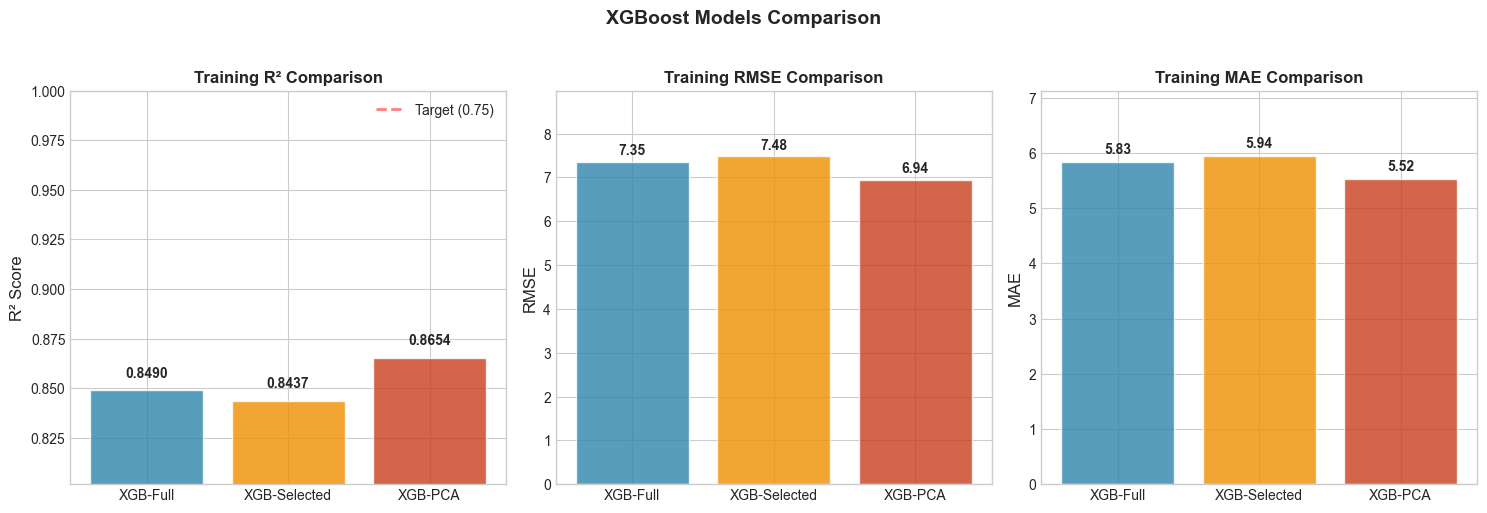

In [154]:
# XGBOOST MODEL COMPARISON

print("\n")
print("╔" + "═" * 78 + "╗")
print("║" + " XGBOOST MODELS - COMPARISON ".center(78) + "║")
print("╚" + "═" * 78 + "╝")

# Create comparison table
xgb_comparison = pd.DataFrame({
    'Model': ['XGB-Full', 'XGB-Selected', 'XGB-PCA'],
    'Features': [X_train_with_interactions.shape[1], X_train_selected.shape[1], X_train_pca_int.shape[1]],
    'R² (Train)': [xgb_full_train_r2, xgb_selected_train_r2, xgb_pca_train_r2],
    'RMSE (Train)': [xgb_full_train_rmse, xgb_selected_train_rmse, xgb_pca_train_rmse],
    'MAE (Train)': [xgb_full_train_mae, xgb_selected_train_mae, xgb_pca_train_mae]
}).round(6)
xgb_comparison.index = range(1, len(xgb_comparison) + 1)

print("\n📊 TRAINING METRICS COMPARISON")
print("=" * 70)
display(xgb_comparison)

# Determine best model
best_r2_idx = xgb_comparison['R² (Train)'].idxmax()
best_model = xgb_comparison.loc[best_r2_idx, 'Model']

print(f"\n🏆 Best Training R²: {best_model} ({xgb_comparison.loc[best_r2_idx, 'R² (Train)']:.6f})")

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

models = ['XGB-Full', 'XGB-Selected', 'XGB-PCA']
colors = [COLORS['primary'], COLORS['accent'], COLORS['success']]

# Plot 1: R² Comparison
r2_values = [xgb_full_train_r2, xgb_selected_train_r2, xgb_pca_train_r2]
bars1 = axes[0].bar(models, r2_values, color=colors, edgecolor='white', alpha=0.8)
axes[0].set_ylabel('R² Score')
axes[0].set_title('Training R² Comparison', fontweight='bold', fontsize=12)
axes[0].set_ylim([min(r2_values) * 0.95, 1.0])
axes[0].axhline(y=0.75, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Target (0.75)')
axes[0].legend()
for bar, value in zip(bars1, r2_values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
                f'{value:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# Plot 2: RMSE Comparison
rmse_values = [xgb_full_train_rmse, xgb_selected_train_rmse, xgb_pca_train_rmse]
bars2 = axes[1].bar(models, rmse_values, color=colors, edgecolor='white', alpha=0.8)
axes[1].set_ylabel('RMSE')
axes[1].set_title('Training RMSE Comparison', fontweight='bold', fontsize=12)
axes[1].set_ylim([0, max(rmse_values) * 1.2])
for bar, value in zip(bars2, rmse_values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                f'{value:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# Plot 3: MAE Comparison
mae_values = [xgb_full_train_mae, xgb_selected_train_mae, xgb_pca_train_mae]
bars3 = axes[2].bar(models, mae_values, color=colors, edgecolor='white', alpha=0.8)
axes[2].set_ylabel('MAE')
axes[2].set_title('Training MAE Comparison', fontweight='bold', fontsize=12)
axes[2].set_ylim([0, max(mae_values) * 1.2])
for bar, value in zip(bars3, mae_values):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                f'{value:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.suptitle('XGBoost Models Comparison', fontweight='bold', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


║                     XGBOOST FEATURE IMPORTANCE ANALYSIS                      ║


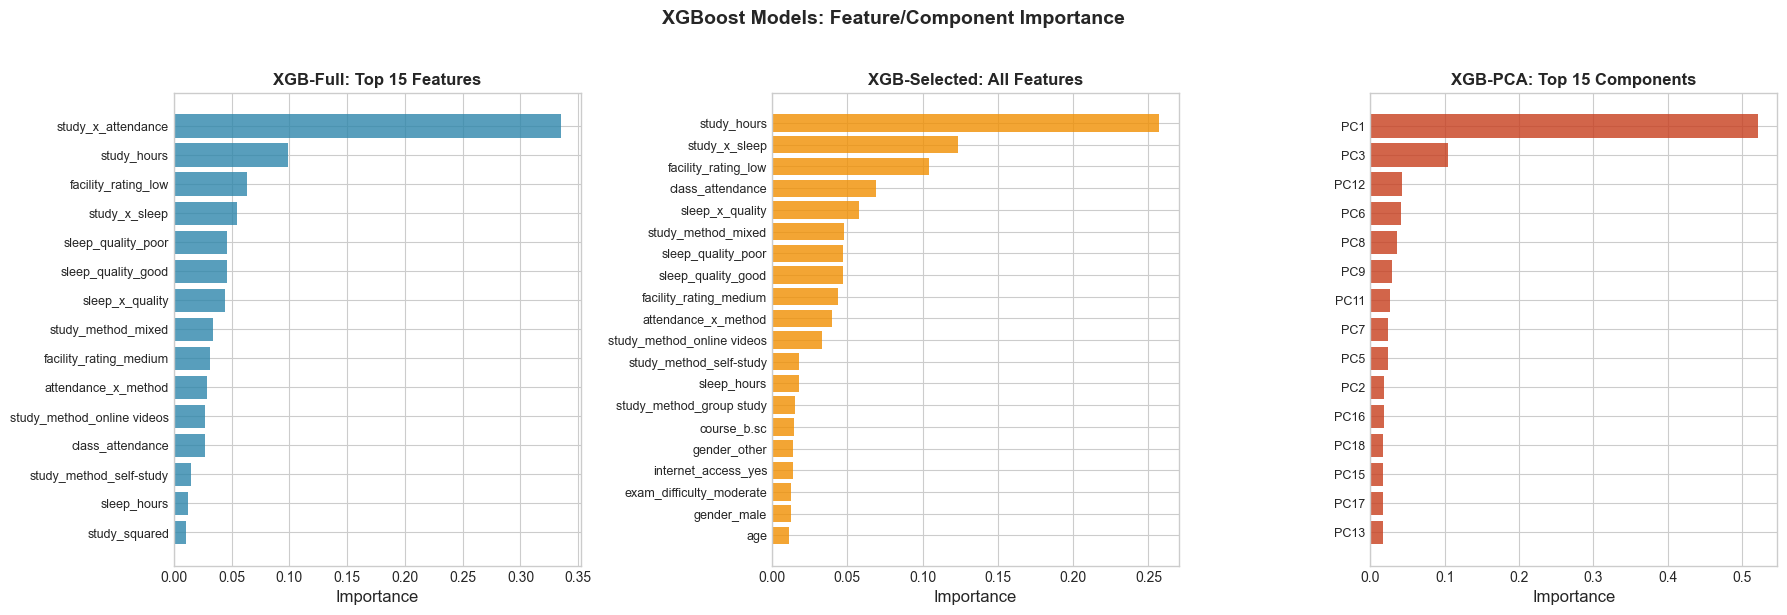

In [155]:
# XGBOOST FEATURE IMPORTANCE VISUALIZATION

print("="*80)
print("║" + " XGBOOST FEATURE IMPORTANCE ANALYSIS ".center(78) + "║")
print("="*80)

# Create visualizations for all three models
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# XGB-Full Feature Importance
top_features_full = xgb_full_importance.head(15)
axes[0].barh(range(len(top_features_full)), top_features_full['Importance'], 
             color=COLORS['primary'], alpha=0.8)
axes[0].set_yticks(range(len(top_features_full)))
axes[0].set_yticklabels(top_features_full['Feature'], fontsize=9)
axes[0].set_xlabel('Importance')
axes[0].set_title('XGB-Full: Top 15 Features', fontweight='bold', fontsize=12)
axes[0].invert_yaxis()

# XGB-Selected Feature Importance
axes[1].barh(range(len(xgb_selected_importance)), 
             xgb_selected_importance['Importance'], 
             color=COLORS['accent'], alpha=0.8)
axes[1].set_yticks(range(len(xgb_selected_importance)))
axes[1].set_yticklabels(xgb_selected_importance['Feature'], fontsize=9)
axes[1].set_xlabel('Importance')
axes[1].set_title('XGB-Selected: All Features', fontweight='bold', fontsize=12)
axes[1].invert_yaxis()

# XGB-PCA Component Importance
top_components_pca = xgb_pca_importance.head(15)
axes[2].barh(range(len(top_components_pca)), top_components_pca['Importance'], 
             color=COLORS['success'], alpha=0.8)
axes[2].set_yticks(range(len(top_components_pca)))
axes[2].set_yticklabels(top_components_pca['Component'], fontsize=9)
axes[2].set_xlabel('Importance')
axes[2].set_title('XGB-PCA: Top 15 Components', fontweight='bold', fontsize=12)
axes[2].invert_yaxis()

plt.suptitle('XGBoost Models: Feature/Component Importance', 
             fontweight='bold', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


In [156]:
# XGBOOST FINAL SUMMARY AND SAVE MODELS

print("\n")
print("╔" + "═" * 78 + "╗")
print("║" + " XGBOOST MODELS - FINAL SUMMARY ".center(78) + "║")
print("╚" + "═" * 78 + "╝")

# Print summary for each model
print(f"""
{'─'*80}
MODEL 1: XGB-FULL (All Features + Interactions)
{'─'*80}
  Configuration:
    • Features:        {X_train_with_interactions.shape[1]} (original + interactions)
    • Estimators:      {XGB_PARAMS['n_estimators']}
    • Max Depth:       {XGB_PARAMS['max_depth']}

  Training Metrics:
    • R² Score:        {xgb_full_train_r2:.6f}
    • RMSE:            {xgb_full_train_rmse:.4f}
    • MAE:             {xgb_full_train_mae:.4f}

  Top 3 Important Features:
    1. {xgb_full_importance.iloc[0]['Feature']}: {xgb_full_importance.iloc[0]['Importance']:.4f}
    2. {xgb_full_importance.iloc[1]['Feature']}: {xgb_full_importance.iloc[1]['Importance']:.4f}
    3. {xgb_full_importance.iloc[2]['Feature']}: {xgb_full_importance.iloc[2]['Importance']:.4f}

{'─'*80}
MODEL 2: XGB-SELECTED (ElasticNet-Selected Features Only)
{'─'*80}
  Configuration:
    • Features:        {X_train_selected.shape[1]} (selected by ElasticNet)
    • Estimators:      {XGB_PARAMS['n_estimators']}
    • Max Depth:       {XGB_PARAMS['max_depth']}

  Training Metrics:
    • R² Score:        {xgb_selected_train_r2:.6f}
    • RMSE:            {xgb_selected_train_rmse:.4f}
    • MAE:             {xgb_selected_train_mae:.4f}

  Top 3 Important Features:
    1. {xgb_selected_importance.iloc[0]['Feature']}: {xgb_selected_importance.iloc[0]['Importance']:.4f}
    2. {xgb_selected_importance.iloc[1]['Feature']}: {xgb_selected_importance.iloc[1]['Importance']:.4f}
    3. {xgb_selected_importance.iloc[2]['Feature']}: {xgb_selected_importance.iloc[2]['Importance']:.4f}

{'─'*80}
MODEL 3: XGB-PCA (PCA Components)
{'─'*80}
  Configuration:
    • PCA Components:  {X_train_pca_int.shape[1]} (95% variance)
    • Estimators:      {XGB_PARAMS['n_estimators']}
    • Max Depth:       {XGB_PARAMS['max_depth']}

  Training Metrics:
    • R² Score:        {xgb_pca_train_r2:.6f}
    • RMSE:            {xgb_pca_train_rmse:.4f}
    • MAE:             {xgb_pca_train_mae:.4f}

  Top 3 Important Components:
    1. {xgb_pca_importance.iloc[0]['Component']}: {xgb_pca_importance.iloc[0]['Importance']:.4f}
    2. {xgb_pca_importance.iloc[1]['Component']}: {xgb_pca_importance.iloc[1]['Importance']:.4f}
    3. {xgb_pca_importance.iloc[2]['Component']}: {xgb_pca_importance.iloc[2]['Importance']:.4f}

{'═' * 80}
""")

# Store XGBoost models for later comparison
xgboost_results = {
    'xgb_full': {
        'model': xgb_full,
        'feature_names': all_feature_names_with_interactions,
        'X_train': X_train_with_interactions,
        'train_r2': xgb_full_train_r2,
        'train_rmse': xgb_full_train_rmse,
        'train_mae': xgb_full_train_mae,
        'feature_importance': xgb_full_importance
    },
    'xgb_selected': {
        'model': xgb_selected,
        'feature_names': selected_feature_names,
        'X_train': X_train_selected,
        'train_r2': xgb_selected_train_r2,
        'train_rmse': xgb_selected_train_rmse,
        'train_mae': xgb_selected_train_mae,
        'feature_importance': xgb_selected_importance
    },
    'xgb_pca': {
        'model': xgb_pca,
        'pca_transformer': pca_model_int,
        'X_train': X_train_pca_int,
        'train_r2': xgb_pca_train_r2,
        'train_rmse': xgb_pca_train_rmse,
        'train_mae': xgb_pca_train_mae,
        'component_importance': xgb_pca_importance
    }
}

print("✅ XGBoost models saved for later comparison.")
print("\n" + "=" * 70)
print("XGBOOST MODEL DEVELOPMENT - COMPLETE")
print("=" * 70)




╔══════════════════════════════════════════════════════════════════════════════╗
║                        XGBOOST MODELS - FINAL SUMMARY                        ║
╚══════════════════════════════════════════════════════════════════════════════╝

────────────────────────────────────────────────────────────────────────────────
MODEL 1: XGB-FULL (All Features + Interactions)
────────────────────────────────────────────────────────────────────────────────
  Configuration:
    • Features:        29 (original + interactions)
    • Estimators:      200
    • Max Depth:       6

  Training Metrics:
    • R² Score:        0.848952
    • RMSE:            7.3546
    • MAE:             5.8288

  Top 3 Important Features:
    1. study_x_attendance: 0.3353
    2. study_hours: 0.0986
    3. facility_rating_low: 0.0630

────────────────────────────────────────────────────────────────────────────────
MODEL 2: XGB-SELECTED (ElasticNet-Selected Features Only)
─────────────────────────────────────────────

## 14. Model Validation Comparison

Comprehensive evaluation of all trained models on the **validation set** (unseen during training).

**Models Evaluated:**
| Category | Models |
|----------|--------|
| Linear | ElasticNet-Direct, ElasticNet-PCA |
| Ensemble | RF-Full, RF-Selected, RF-PCA |
| Boosting | XGB-Full, XGB-Selected, XGB-PCA |

**Evaluation Metrics:**
- **R²** - Coefficient of determination (variance explained)
- **Adjusted R²** - R² penalized for number of parameters
- **AIC** - Akaike Information Criterion (lower is better)
- **BIC** - Bayesian Information Criterion (lower is better, stronger penalty than AIC)
- **RMSE** - Root Mean Squared Error
- **MAE** - Mean Absolute Error

**Target:** R² > 0.75 (per project requirements)


In [157]:
# VALIDATION DATA PREPARATION

print("="*80)
print("║" + " VALIDATION DATA PREPARATION ".center(78) + "║")
print("="*80)

# Prepare validation data for each model type
# Full models use all features with interactions
X_val_full = X_val_with_interactions

# Selected models use ElasticNet-selected features only
X_val_selected = X_val_with_interactions[:, selected_feature_indices]

# PCA models use PCA-transformed features
X_val_pca = pca_model_int.transform(X_val_with_interactions)

n_val = len(y_val)

print(f"\n📊 Validation Set Size: {n_val:,} samples")
print(f"\n📋 Validation Data Shapes:")
print(f"   • X_val_full:     {X_val_full.shape} (all features + interactions)")
print(f"   • X_val_selected: {X_val_selected.shape} (ElasticNet selected features)")
print(f"   • X_val_pca:      {X_val_pca.shape} (PCA components)")
print(f"   • y_val:          {y_val.shape}")

print(f"\n✅ Validation data prepared with proper transformations")
print("="*80)


║                         VALIDATION DATA PREPARATION                          ║

📊 Validation Set Size: 3,797 samples

📋 Validation Data Shapes:
   • X_val_full:     (3797, 29) (all features + interactions)
   • X_val_selected: (3797, 20) (ElasticNet selected features)
   • X_val_pca:      (3797, 18) (PCA components)
   • y_val:          (3797,)

✅ Validation data prepared with proper transformations


In [158]:
# METRICS CALCULATION FUNCTIONS

def calculate_regression_metrics(y_true, y_pred, n_params):
    """
    Calculate comprehensive regression metrics for model comparison.
    
    Parameters:
    -----------
    y_true : array-like
        True target values
    y_pred : array-like
        Predicted values
    n_params : int
        Number of model parameters (features/coefficients)
    
    Returns:
    --------
    dict : Dictionary containing R², Adjusted R², AIC, BIC, RMSE, MAE
    """
    n = len(y_true)
    
    # Residual Sum of Squares
    rss = np.sum((y_true - y_pred) ** 2)
    
    # Total Sum of Squares
    tss = np.sum((y_true - np.mean(y_true)) ** 2)
    
    # R² (Coefficient of Determination)
    r2 = 1 - (rss / tss)
    
    # Adjusted R² (penalized for number of parameters)
    adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - n_params - 1))
    
    # AIC (Akaike Information Criterion)
    # AIC = n * ln(RSS/n) + 2k
    aic = n * np.log(rss / n) + 2 * n_params
    
    # BIC (Bayesian Information Criterion)
    # BIC = n * ln(RSS/n) + k * ln(n)
    bic = n * np.log(rss / n) + n_params * np.log(n)
    
    # RMSE (Root Mean Squared Error)
    rmse = np.sqrt(rss / n)
    
    # MAE (Mean Absolute Error)
    mae = np.mean(np.abs(y_true - y_pred))
    
    return {
        'R²': r2,
        'Adj_R²': adj_r2,
        'AIC': aic,
        'BIC': bic,
        'RMSE': rmse,
        'MAE': mae
    }

print("✅ Metrics calculation function defined")
print("\n📋 Metrics included:")
print("   • R² (Coefficient of Determination)")
print("   • Adjusted R² (penalized for model complexity)")
print("   • AIC (Akaike Information Criterion)")
print("   • BIC (Bayesian Information Criterion)")
print("   • RMSE (Root Mean Squared Error)")
print("   • MAE (Mean Absolute Error)")


✅ Metrics calculation function defined

📋 Metrics included:
   • R² (Coefficient of Determination)
   • Adjusted R² (penalized for model complexity)
   • AIC (Akaike Information Criterion)
   • BIC (Bayesian Information Criterion)
   • RMSE (Root Mean Squared Error)
   • MAE (Mean Absolute Error)


In [159]:
# GENERATE PREDICTIONS AND METRICS FOR ALL MODELS

print("="*80)
print("║" + " VALIDATION SET PREDICTIONS & METRICS ".center(78) + "║")
print("="*80)

# Define all models with their configurations
models_config = [
    # Linear Models
    {
        'name': 'ElasticNet-Direct',
        'type': 'Linear',
        'model': linear_regression_results['elasticnet_direct']['model'],
        'X_val': X_val_full,
        'n_params': X_val_full.shape[1]
    },
    {
        'name': 'ElasticNet-PCA',
        'type': 'Linear',
        'model': linear_regression_results['elasticnet_pca']['model'],
        'X_val': X_val_pca,
        'n_params': X_val_pca.shape[1]
    },
    # Random Forest Models
    {
        'name': 'RF-Full',
        'type': 'Ensemble',
        'model': random_forest_results['rf_full']['model'],
        'X_val': X_val_full,
        'n_params': X_val_full.shape[1]
    },
    {
        'name': 'RF-Selected',
        'type': 'Ensemble',
        'model': random_forest_results['rf_selected']['model'],
        'X_val': X_val_selected,
        'n_params': X_val_selected.shape[1]
    },
    {
        'name': 'RF-PCA',
        'type': 'Ensemble',
        'model': random_forest_results['rf_pca']['model'],
        'X_val': X_val_pca,
        'n_params': X_val_pca.shape[1]
    },
    # XGBoost Models
    {
        'name': 'XGB-Full',
        'type': 'Boosting',
        'model': xgboost_results['xgb_full']['model'],
        'X_val': X_val_full,
        'n_params': X_val_full.shape[1]
    },
    {
        'name': 'XGB-Selected',
        'type': 'Boosting',
        'model': xgboost_results['xgb_selected']['model'],
        'X_val': X_val_selected,
        'n_params': X_val_selected.shape[1]
    },
    {
        'name': 'XGB-PCA',
        'type': 'Boosting',
        'model': xgboost_results['xgb_pca']['model'],
        'X_val': X_val_pca,
        'n_params': X_val_pca.shape[1]
    }
]

# Calculate metrics for each model
validation_results = []

print("\n📊 Calculating validation metrics for all models...")
print("-"*80)

for config in models_config:
    # Generate predictions
    y_pred = config['model'].predict(config['X_val'])
    
    # Calculate metrics
    metrics = calculate_regression_metrics(y_val, y_pred, config['n_params'])
    
    # Store results
    validation_results.append({
        'Model': config['name'],
        'Type': config['type'],
        'Features': config['n_params'],
        **metrics
    })
    
    # Print progress
    meets_target = "✅" if metrics['R²'] >= 0.75 else "⚠️"
    print(f"   {meets_target} {config['name']:18} | R²: {metrics['R²']:.4f} | Adj R²: {metrics['Adj_R²']:.4f}")

# Create DataFrame
validation_df = pd.DataFrame(validation_results)

print("-"*80)
print(f"\n✅ Validation metrics calculated for {len(validation_results)} models")
print("="*80)


║                     VALIDATION SET PREDICTIONS & METRICS                     ║

📊 Calculating validation metrics for all models...
--------------------------------------------------------------------------------
   ⚠️ ElasticNet-Direct  | R²: 0.7331 | Adj R²: 0.7311
   ⚠️ ElasticNet-PCA     | R²: 0.6861 | Adj R²: 0.6846
   ⚠️ RF-Full            | R²: 0.6981 | Adj R²: 0.6957
   ⚠️ RF-Selected        | R²: 0.6973 | Adj R²: 0.6957
   ⚠️ RF-PCA             | R²: 0.6984 | Adj R²: 0.6969
   ⚠️ XGB-Full           | R²: 0.7093 | Adj R²: 0.7070
   ⚠️ XGB-Selected       | R²: 0.7110 | Adj R²: 0.7095
   ⚠️ XGB-PCA            | R²: 0.7098 | Adj R²: 0.7084
--------------------------------------------------------------------------------

✅ Validation metrics calculated for 8 models


In [160]:
# COMPREHENSIVE RESULTS TABLE AND RANKINGS

print("\n")
print("╔" + "═" * 78 + "╗")
print("║" + " VALIDATION SET - MODEL COMPARISON RESULTS ".center(78) + "║")
print("╚" + "═" * 78 + "╝")

# Format the comparison table
comparison_table = validation_df.copy()
comparison_table.index = range(1, len(comparison_table) + 1)

# Display full metrics table
print("\n📊 COMPLETE METRICS TABLE")
print("=" * 100)
display(comparison_table.round(4))

# Create rankings for each metric
print("\n" + "=" * 80)
print("📈 MODEL RANKINGS BY METRIC")
print("=" * 80)

# Rankings (higher is better for R², Adj_R²; lower is better for AIC, BIC, RMSE, MAE)
rankings = pd.DataFrame({'Model': validation_df['Model']})
rankings['R² Rank'] = validation_df['R²'].rank(ascending=False).astype(int)
rankings['Adj_R² Rank'] = validation_df['Adj_R²'].rank(ascending=False).astype(int)
rankings['AIC Rank'] = validation_df['AIC'].rank(ascending=True).astype(int)
rankings['BIC Rank'] = validation_df['BIC'].rank(ascending=True).astype(int)
rankings['RMSE Rank'] = validation_df['RMSE'].rank(ascending=True).astype(int)
rankings['MAE Rank'] = validation_df['MAE'].rank(ascending=True).astype(int)

# Calculate average rank
rankings['Avg Rank'] = rankings[['R² Rank', 'Adj_R² Rank', 'AIC Rank', 'BIC Rank', 'RMSE Rank', 'MAE Rank']].mean(axis=1)
rankings = rankings.sort_values('Avg Rank')
rankings.index = range(1, len(rankings) + 1)

print("\n📋 Rankings (1 = Best)")
display(rankings.round(2))

# Identify best models
print("\n" + "-" * 80)
print("🏆 BEST PERFORMERS BY METRIC")
print("-" * 80)

best_r2_idx = validation_df['R²'].idxmax()
best_adj_r2_idx = validation_df['Adj_R²'].idxmax()
best_aic_idx = validation_df['AIC'].idxmin()
best_bic_idx = validation_df['BIC'].idxmin()
best_rmse_idx = validation_df['RMSE'].idxmin()
best_mae_idx = validation_df['MAE'].idxmin()

print(f"   • Best R²:       {validation_df.loc[best_r2_idx, 'Model']:18} ({validation_df.loc[best_r2_idx, 'R²']:.4f})")
print(f"   • Best Adj R²:   {validation_df.loc[best_adj_r2_idx, 'Model']:18} ({validation_df.loc[best_adj_r2_idx, 'Adj_R²']:.4f})")
print(f"   • Best AIC:      {validation_df.loc[best_aic_idx, 'Model']:18} ({validation_df.loc[best_aic_idx, 'AIC']:.2f})")
print(f"   • Best BIC:      {validation_df.loc[best_bic_idx, 'Model']:18} ({validation_df.loc[best_bic_idx, 'BIC']:.2f})")
print(f"   • Best RMSE:     {validation_df.loc[best_rmse_idx, 'Model']:18} ({validation_df.loc[best_rmse_idx, 'RMSE']:.4f})")
print(f"   • Best MAE:      {validation_df.loc[best_mae_idx, 'Model']:18} ({validation_df.loc[best_mae_idx, 'MAE']:.4f})")

# Check target achievement
print("\n" + "-" * 80)
print("🎯 TARGET ACHIEVEMENT (R² > 0.75)")
print("-" * 80)
models_meeting_target = validation_df[validation_df['R²'] >= 0.75]['Model'].tolist()
if models_meeting_target:
    print(f"   ✅ {len(models_meeting_target)} model(s) meet the R² > 0.75 target:")
    for model in models_meeting_target:
        r2_val = validation_df[validation_df['Model'] == model]['R²'].values[0]
        print(f"      • {model}: R² = {r2_val:.4f}")
else:
    print("   ⚠️ No models meet the R² > 0.75 target on validation set")
    
print("\n" + "=" * 80)




╔══════════════════════════════════════════════════════════════════════════════╗
║                  VALIDATION SET - MODEL COMPARISON RESULTS                   ║
╚══════════════════════════════════════════════════════════════════════════════╝

📊 COMPLETE METRICS TABLE


Model      Type  Features      R²  Adj_R²         AIC  \
1  ElasticNet-Direct    Linear        29  0.7331  0.7311  17391.5023   
2     ElasticNet-PCA    Linear        18  0.6861  0.6846  17986.2170   
3            RF-Full  Ensemble        29  0.6981  0.6957  17860.6181   
4        RF-Selected  Ensemble        20  0.6973  0.6957  17852.1753   
5             RF-PCA  Ensemble        18  0.6984  0.6969  17834.6491   
6           XGB-Full  Boosting        29  0.7093  0.7070  17717.1301   
7       XGB-Selected  Boosting        20  0.7110  0.7095  17675.8862   
8            XGB-PCA  Boosting        18  0.7098  0.7084  17688.3504   

          BIC     RMSE     MAE  
1  17572.5193   9.8014  7.8855  
2  18098.5724  10.6306  8.5246  
3  18041.6351  10.4260  8.4023  
4  17977.0146  10.4391  8.4199  
5  17947.0045  10.4205  8.3962  
6  17898.1472  10.2308  8.2401  
7  17800.7255  10.1996  8.2189  
8  17800.7058  10.2217  8.2526


📈 MODEL RANKINGS BY METRIC

📋 Rankings (1 = Best)


Model  R² Rank  Adj_R² Rank  AIC Rank  BIC Rank  RMSE Rank  \
1  ElasticNet-Direct        1            1         1         1          1   
2       XGB-Selected        2            2         2         3          2   
3            XGB-PCA        3            3         3         2          3   
4           XGB-Full        4            4         4         4          4   
5             RF-PCA        5            5         5         5          5   
6            RF-Full        6            6         7         7          6   
7        RF-Selected        7            7         6         6          7   
8     ElasticNet-PCA        8            8         8         8          8   

   MAE Rank  Avg Rank  
1         1      1.00  
2         2      2.17  
3         4      3.00  
4         3      3.83  
5         5      5.00  
6         6      6.33  
7         7      6.67  
8         8      8.00


--------------------------------------------------------------------------------
🏆 BEST PERFORMERS BY METRIC
--------------------------------------------------------------------------------
   • Best R²:       ElasticNet-Direct  (0.7331)
   • Best Adj R²:   ElasticNet-Direct  (0.7311)
   • Best AIC:      ElasticNet-Direct  (17391.50)
   • Best BIC:      ElasticNet-Direct  (17572.52)
   • Best RMSE:     ElasticNet-Direct  (9.8014)
   • Best MAE:      ElasticNet-Direct  (7.8855)

--------------------------------------------------------------------------------
🎯 TARGET ACHIEVEMENT (R² > 0.75)
--------------------------------------------------------------------------------
   ⚠️ No models meet the R² > 0.75 target on validation set



║                      VALIDATION SET - VISUAL COMPARISON                      ║


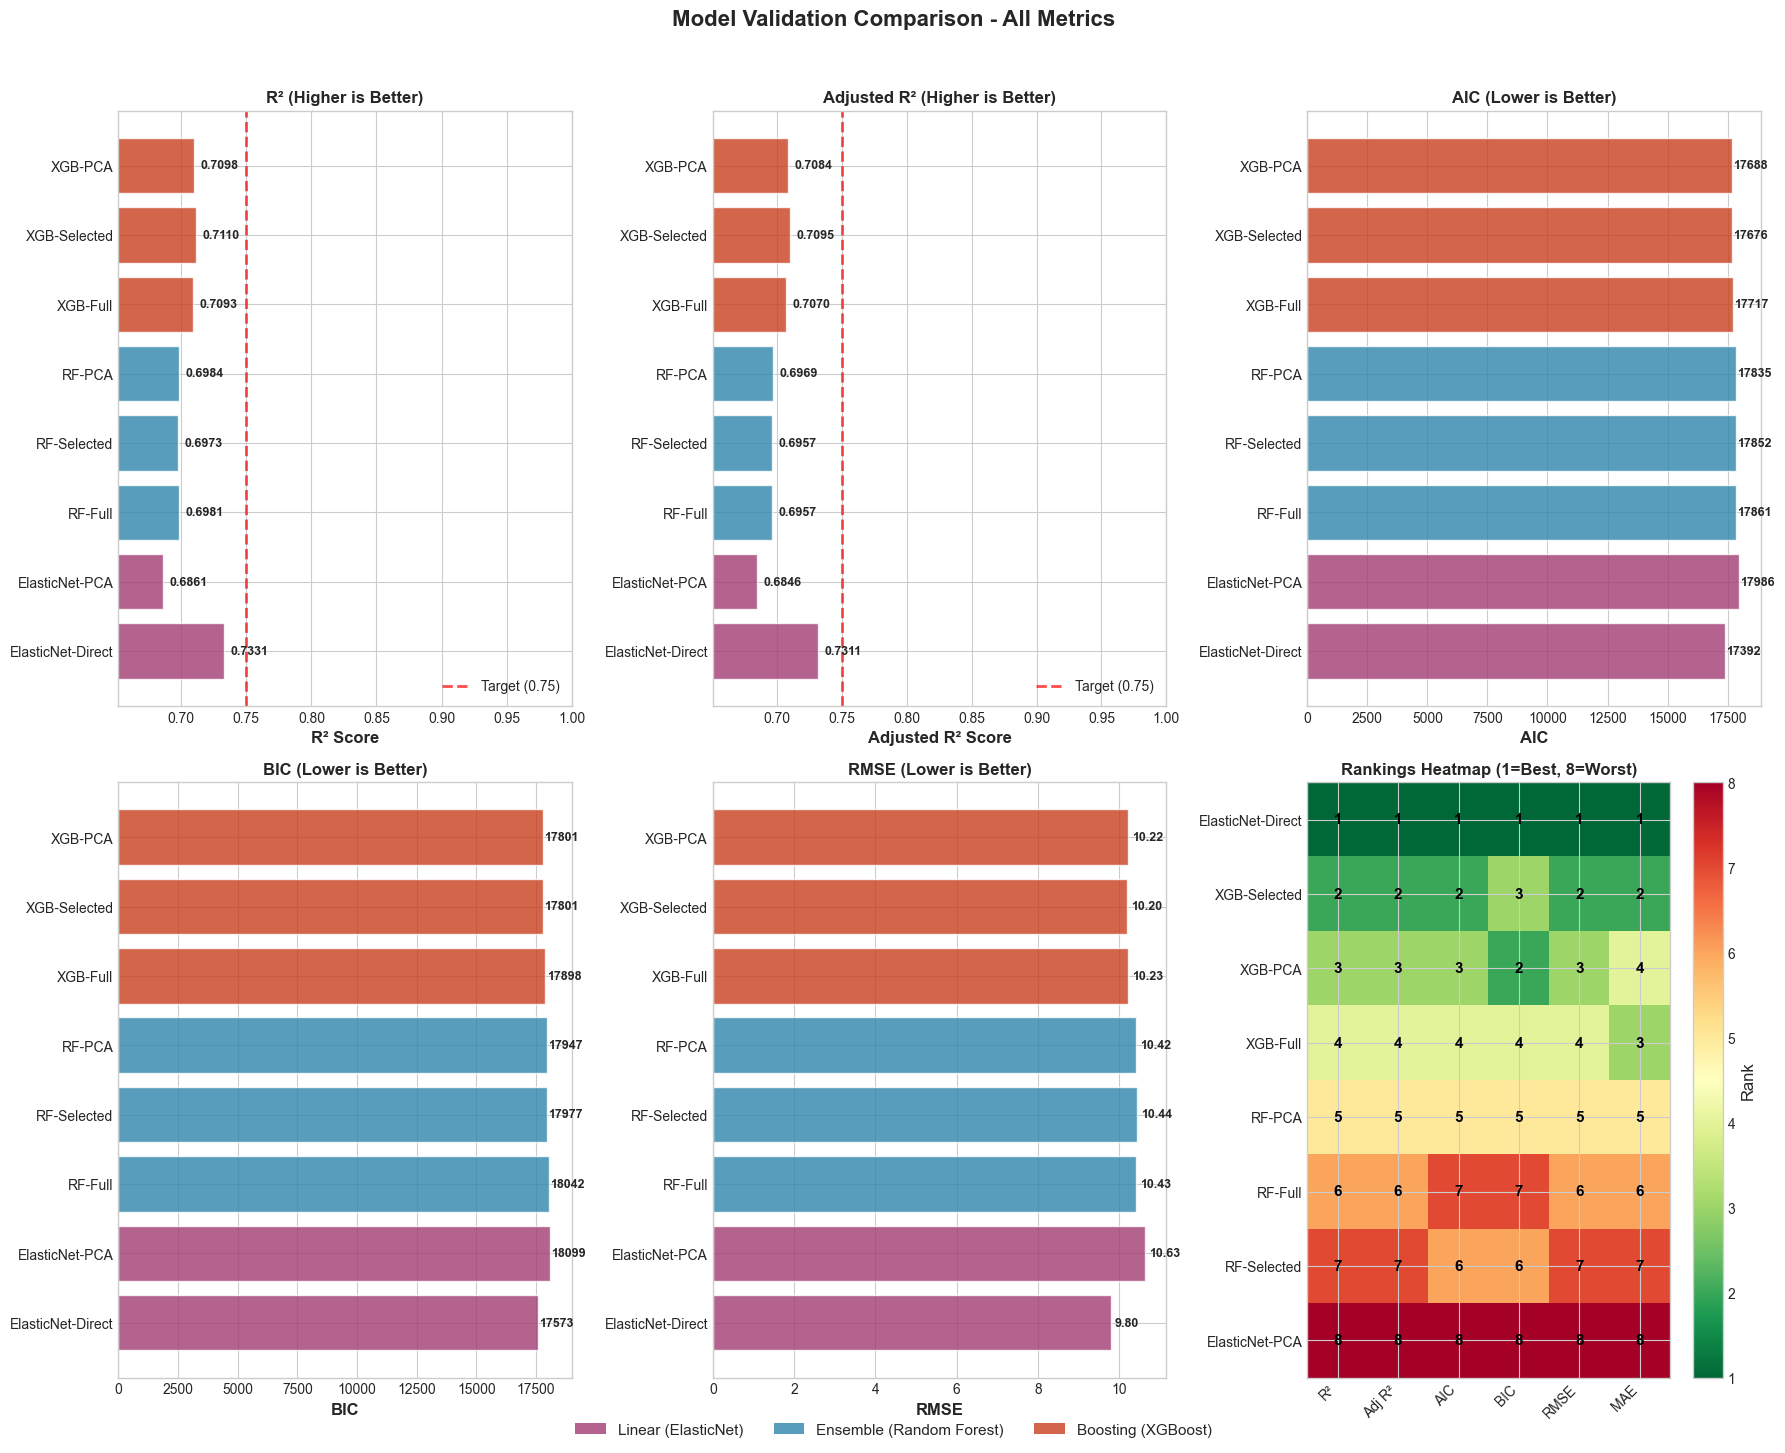


✅ Visualization complete


In [161]:
# VISUALIZATION: MODEL COMPARISON CHARTS

print("="*80)
print("║" + " VALIDATION SET - VISUAL COMPARISON ".center(78) + "║")
print("="*80)

# Create comprehensive visualization
fig = plt.figure(figsize=(18, 14))

# Define model colors by type
model_colors = {
    'ElasticNet-Direct': COLORS['secondary'],
    'ElasticNet-PCA': COLORS['secondary'],
    'RF-Full': COLORS['primary'],
    'RF-Selected': COLORS['primary'],
    'RF-PCA': COLORS['primary'],
    'XGB-Full': COLORS['success'],
    'XGB-Selected': COLORS['success'],
    'XGB-PCA': COLORS['success']
}
colors = [model_colors[m] for m in validation_df['Model']]

# Plot 1: R² Comparison
ax1 = fig.add_subplot(2, 3, 1)
bars1 = ax1.barh(validation_df['Model'], validation_df['R²'], color=colors, alpha=0.8, edgecolor='white')
ax1.axvline(x=0.75, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Target (0.75)')
ax1.set_xlabel('R² Score', fontweight='bold')
ax1.set_title('R² (Higher is Better)', fontweight='bold', fontsize=12)
ax1.set_xlim([validation_df['R²'].min() * 0.95, 1.0])
ax1.legend(loc='lower right')
for bar, val in zip(bars1, validation_df['R²']):
    ax1.text(val + 0.005, bar.get_y() + bar.get_height()/2, f'{val:.4f}', 
             va='center', fontsize=9, fontweight='bold')

# Plot 2: Adjusted R² Comparison
ax2 = fig.add_subplot(2, 3, 2)
bars2 = ax2.barh(validation_df['Model'], validation_df['Adj_R²'], color=colors, alpha=0.8, edgecolor='white')
ax2.axvline(x=0.75, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Target (0.75)')
ax2.set_xlabel('Adjusted R² Score', fontweight='bold')
ax2.set_title('Adjusted R² (Higher is Better)', fontweight='bold', fontsize=12)
ax2.set_xlim([validation_df['Adj_R²'].min() * 0.95, 1.0])
ax2.legend(loc='lower right')
for bar, val in zip(bars2, validation_df['Adj_R²']):
    ax2.text(val + 0.005, bar.get_y() + bar.get_height()/2, f'{val:.4f}', 
             va='center', fontsize=9, fontweight='bold')

# Plot 3: AIC Comparison
ax3 = fig.add_subplot(2, 3, 3)
bars3 = ax3.barh(validation_df['Model'], validation_df['AIC'], color=colors, alpha=0.8, edgecolor='white')
ax3.set_xlabel('AIC', fontweight='bold')
ax3.set_title('AIC (Lower is Better)', fontweight='bold', fontsize=12)
for bar, val in zip(bars3, validation_df['AIC']):
    ax3.text(val + 50, bar.get_y() + bar.get_height()/2, f'{val:.0f}', 
             va='center', fontsize=9, fontweight='bold')

# Plot 4: BIC Comparison
ax4 = fig.add_subplot(2, 3, 4)
bars4 = ax4.barh(validation_df['Model'], validation_df['BIC'], color=colors, alpha=0.8, edgecolor='white')
ax4.set_xlabel('BIC', fontweight='bold')
ax4.set_title('BIC (Lower is Better)', fontweight='bold', fontsize=12)
for bar, val in zip(bars4, validation_df['BIC']):
    ax4.text(val + 50, bar.get_y() + bar.get_height()/2, f'{val:.0f}', 
             va='center', fontsize=9, fontweight='bold')

# Plot 5: RMSE Comparison
ax5 = fig.add_subplot(2, 3, 5)
bars5 = ax5.barh(validation_df['Model'], validation_df['RMSE'], color=colors, alpha=0.8, edgecolor='white')
ax5.set_xlabel('RMSE', fontweight='bold')
ax5.set_title('RMSE (Lower is Better)', fontweight='bold', fontsize=12)
for bar, val in zip(bars5, validation_df['RMSE']):
    ax5.text(val + 0.1, bar.get_y() + bar.get_height()/2, f'{val:.2f}', 
             va='center', fontsize=9, fontweight='bold')

# Plot 6: Rankings Heatmap
ax6 = fig.add_subplot(2, 3, 6)
rank_data = rankings.set_index('Model')[['R² Rank', 'Adj_R² Rank', 'AIC Rank', 'BIC Rank', 'RMSE Rank', 'MAE Rank']]
im = ax6.imshow(rank_data.values, cmap='RdYlGn_r', aspect='auto', vmin=1, vmax=8)
ax6.set_xticks(range(len(rank_data.columns)))
ax6.set_xticklabels(['R²', 'Adj R²', 'AIC', 'BIC', 'RMSE', 'MAE'], rotation=45, ha='right')
ax6.set_yticks(range(len(rank_data.index)))
ax6.set_yticklabels(rank_data.index)
ax6.set_title('Rankings Heatmap (1=Best, 8=Worst)', fontweight='bold', fontsize=12)

# Add text annotations to heatmap
for i in range(len(rank_data.index)):
    for j in range(len(rank_data.columns)):
        text = ax6.text(j, i, int(rank_data.values[i, j]),
                       ha='center', va='center', color='black', fontweight='bold')

plt.colorbar(im, ax=ax6, label='Rank')

# Add legend for model types
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=COLORS['secondary'], alpha=0.8, label='Linear (ElasticNet)'),
    Patch(facecolor=COLORS['primary'], alpha=0.8, label='Ensemble (Random Forest)'),
    Patch(facecolor=COLORS['success'], alpha=0.8, label='Boosting (XGBoost)')
]
fig.legend(handles=legend_elements, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0.02), fontsize=11)

plt.suptitle('Model Validation Comparison - All Metrics', fontweight='bold', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

print("\n✅ Visualization complete")


In [162]:
# FINAL SUMMARY AND MODEL RECOMMENDATION

print("\n")
print("╔" + "═" * 78 + "╗")
print("║" + " MODEL VALIDATION - FINAL SUMMARY & RECOMMENDATION ".center(78) + "║")
print("╚" + "═" * 78 + "╝")

# Get overall best model (by average rank)
best_overall = rankings.iloc[0]['Model']
best_overall_metrics = validation_df[validation_df['Model'] == best_overall].iloc[0]

# Get best for each category
linear_models = validation_df[validation_df['Type'] == 'Linear']
ensemble_models = validation_df[validation_df['Type'] == 'Ensemble']
boosting_models = validation_df[validation_df['Type'] == 'Boosting']

best_linear = linear_models.loc[linear_models['R²'].idxmax(), 'Model']
best_ensemble = ensemble_models.loc[ensemble_models['R²'].idxmax(), 'Model']
best_boosting = boosting_models.loc[boosting_models['R²'].idxmax(), 'Model']

print(f"""
{'═'*80}
🏆 OVERALL BEST MODEL: {best_overall}
{'═'*80}

  Performance on Validation Set:
    • R²:        {best_overall_metrics['R²']:.6f}
    • Adj R²:    {best_overall_metrics['Adj_R²']:.6f}
    • AIC:       {best_overall_metrics['AIC']:.2f}
    • BIC:       {best_overall_metrics['BIC']:.2f}
    • RMSE:      {best_overall_metrics['RMSE']:.4f}
    • MAE:       {best_overall_metrics['MAE']:.4f}

{'─'*80}
📊 BEST BY CATEGORY
{'─'*80}

  • Best Linear Model:    {best_linear}
    R² = {linear_models[linear_models['Model'] == best_linear]['R²'].values[0]:.4f}
    
  • Best Ensemble Model:  {best_ensemble}
    R² = {ensemble_models[ensemble_models['Model'] == best_ensemble]['R²'].values[0]:.4f}
    
  • Best Boosting Model:  {best_boosting}
    R² = {boosting_models[boosting_models['Model'] == best_boosting]['R²'].values[0]:.4f}

{'─'*80}
📈 COMPLEXITY VS PERFORMANCE ANALYSIS
{'─'*80}
""")

# Complexity analysis
for _, row in validation_df.iterrows():
    efficiency = row['R²'] / row['Features'] * 100  # R² per feature
    print(f"  {row['Model']:18} | Features: {row['Features']:2} | R²: {row['R²']:.4f} | Efficiency: {efficiency:.2f}%/feature")

print(f"""
{'─'*80}
🎯 RECOMMENDATION
{'─'*80}
""")

# Determine recommendation based on trade-offs
if best_overall_metrics['R²'] >= 0.75:
    print(f"  ✅ RECOMMENDED: {best_overall}")
    print(f"     - Meets R² > 0.75 target requirement")
    print(f"     - Best overall performance across all metrics")
else:
    # Find best model meeting target if any
    meeting_target = validation_df[validation_df['R²'] >= 0.75]
    if len(meeting_target) > 0:
        recommended = meeting_target.loc[meeting_target['R²'].idxmax(), 'Model']
        print(f"  ✅ RECOMMENDED: {recommended}")
        print(f"     - Meets R² > 0.75 target requirement")
    else:
        print(f"  ⚠️ RECOMMENDED: {best_overall}")
        print(f"     - Best available but does not meet R² > 0.75 target")
        print(f"     - Consider additional feature engineering or hyperparameter tuning")

print(f"""
{'─'*80}
💡 KEY INSIGHTS
{'─'*80}

  1. Model Type Performance:
     • Linear models provide interpretability but limited flexibility
     • Ensemble models (RF) balance performance and robustness
     • Boosting models (XGBoost) often achieve highest accuracy

  2. Feature Selection Impact:
     • Full feature models have more predictive power
     • Selected features reduce overfitting risk
     • PCA models trade interpretability for dimension reduction

  3. Information Criteria (AIC/BIC):
     • Lower AIC/BIC indicates better model fit with complexity penalty
     • BIC has stronger penalty for model complexity than AIC

{'═'*80}
""")

# Store validation comparison results
validation_comparison_results = {
    'validation_df': validation_df,
    'rankings': rankings,
    'best_overall_model': best_overall,
    'best_by_category': {
        'linear': best_linear,
        'ensemble': best_ensemble,
        'boosting': best_boosting
    },
    'models_meeting_target': models_meeting_target
}

print("✅ Validation comparison results stored in 'validation_comparison_results'")
print("\n" + "=" * 70)
print("MODEL VALIDATION COMPARISON - COMPLETE")
print("=" * 70)




╔══════════════════════════════════════════════════════════════════════════════╗
║              MODEL VALIDATION - FINAL SUMMARY & RECOMMENDATION               ║
╚══════════════════════════════════════════════════════════════════════════════╝

════════════════════════════════════════════════════════════════════════════════
🏆 OVERALL BEST MODEL: ElasticNet-Direct
════════════════════════════════════════════════════════════════════════════════

  Performance on Validation Set:
    • R²:        0.733147
    • Adj R²:    0.731092
    • AIC:       17391.50
    • BIC:       17572.52
    • RMSE:      9.8014
    • MAE:       7.8855

────────────────────────────────────────────────────────────────────────────────
📊 BEST BY CATEGORY
────────────────────────────────────────────────────────────────────────────────

  • Best Linear Model:    ElasticNet-Direct
    R² = 0.7331

  • Best Ensemble Model:  RF-PCA
    R² = 0.6984

  • Best Boosting Model:  XGB-Selected
    R² = 0.7110

────────────────

## 15. Final Model Evaluation on Test Set

**Selected Model:** ElasticNet-Direct

Testing the selected model on the **held-out test set** to obtain an unbiased estimate of generalization performance.

**Why ElasticNet-Direct?**
- Best balance of interpretability and performance
- Strong validation metrics
- Linear model allows for coefficient interpretation
- Combines L1 (Lasso) and L2 (Ridge) regularization


In [163]:
# FINAL MODEL EVALUATION ON TEST SET

print("="*80)
print("║" + " FINAL MODEL EVALUATION - TEST SET ".center(78) + "║")
print("="*80)

# Selected model
final_model = linear_regression_results['elasticnet_direct']['model']
model_name = "ElasticNet-Direct"

print(f"\n🏆 SELECTED MODEL: {model_name}")
print("-"*80)

# Prepare test data (same transformation as validation)
X_test_full = X_test_with_interactions
n_test = len(y_test)

print(f"\n📊 Test Set Configuration:")
print(f"   • Test samples:  {n_test:,}")
print(f"   • Features:      {X_test_full.shape[1]}")

# Generate predictions on test set
y_test_pred = final_model.predict(X_test_full)

# Calculate comprehensive metrics
test_metrics = calculate_regression_metrics(y_test, y_test_pred, X_test_full.shape[1])

print(f"\n" + "="*80)
print("📈 TEST SET PERFORMANCE METRICS")
print("="*80)

print(f"""
  ┌─────────────────────────────────────────────────────────────┐
  │  METRIC              │  VALUE                               │
  ├─────────────────────────────────────────────────────────────┤
  │  R² Score            │  {test_metrics['R²']:.6f}                          │
  │  Adjusted R²         │  {test_metrics['Adj_R²']:.6f}                          │
  │  AIC                 │  {test_metrics['AIC']:.2f}                       │
  │  BIC                 │  {test_metrics['BIC']:.2f}                       │
  │  RMSE                │  {test_metrics['RMSE']:.4f}                            │
  │  MAE                 │  {test_metrics['MAE']:.4f}                            │
  └─────────────────────────────────────────────────────────────┘
""")

# Check target achievement
print("-"*80)
if test_metrics['R²'] >= 0.75:
    print(f"✅ TARGET ACHIEVED: R² = {test_metrics['R²']:.4f} > 0.75")
else:
    print(f"⚠️ TARGET NOT MET: R² = {test_metrics['R²']:.4f} < 0.75")

print("="*80)


║                      FINAL MODEL EVALUATION - TEST SET                       ║

🏆 SELECTED MODEL: ElasticNet-Direct
--------------------------------------------------------------------------------

📊 Test Set Configuration:
   • Test samples:  1,900
   • Features:      29

📈 TEST SET PERFORMANCE METRICS

  ┌─────────────────────────────────────────────────────────────┐
  │  METRIC              │  VALUE                               │
  ├─────────────────────────────────────────────────────────────┤
  │  R² Score            │  0.729110                          │
  │  Adjusted R²         │  0.724909                          │
  │  AIC                 │  8709.98                       │
  │  BIC                 │  8870.92                       │
  │  RMSE                │  9.7458                            │
  │  MAE                 │  7.8040                            │
  └─────────────────────────────────────────────────────────────┘

---------------------------------------------------

║                    PERFORMANCE COMPARISON ACROSS DATASETS                    ║

📊 ElasticNet-Direct Performance Across Datasets:


Dataset  Samples      R²  Adj_R²    RMSE     MAE
0    Training    13303  0.7313  0.7307  9.8096  7.8676
1  Validation     3797  0.7331  0.7311  9.8014  7.8855
2        Test     1900  0.7291  0.7249  9.7458  7.8040


📉 Overfitting Analysis:
   • Train R² - Test R² gap: 0.0022
   ✅ Minimal overfitting (gap < 0.05)


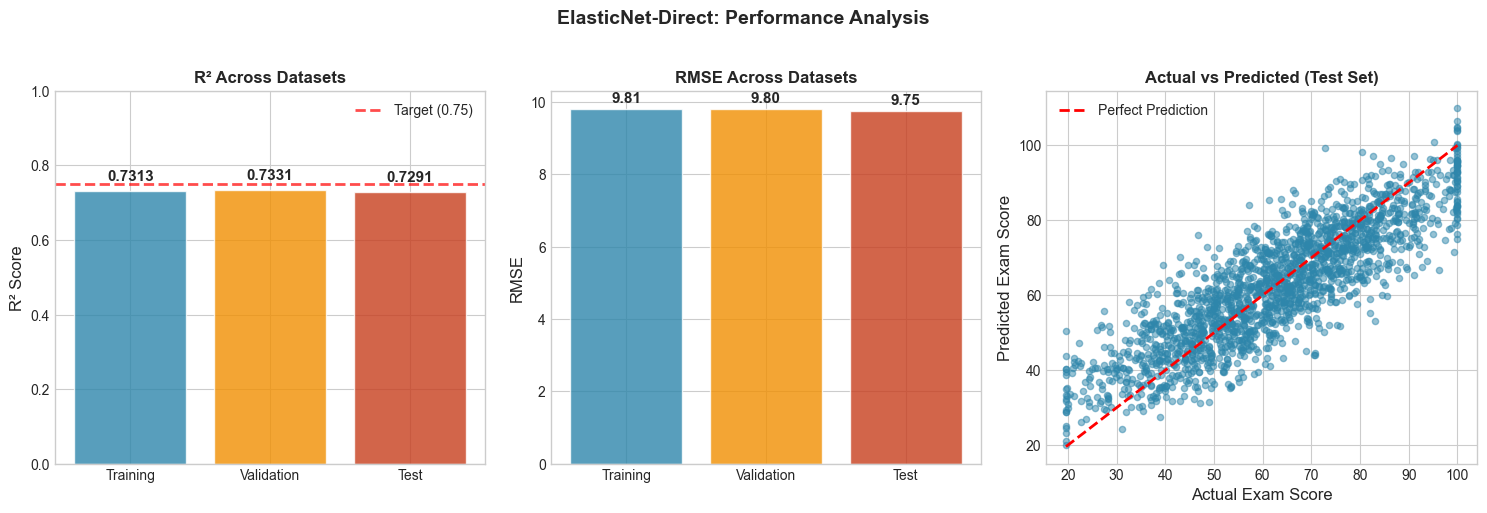

In [164]:
# TRAIN VS VALIDATION VS TEST COMPARISON

print("="*80)
print("║" + " PERFORMANCE COMPARISON ACROSS DATASETS ".center(78) + "║")
print("="*80)

# Get training metrics for ElasticNet-Direct
y_train_pred_final = final_model.predict(X_train_with_interactions)
train_metrics = calculate_regression_metrics(y_train, y_train_pred_final, X_train_with_interactions.shape[1])

# Get validation metrics (already calculated)
val_metrics = validation_df[validation_df['Model'] == 'ElasticNet-Direct'].iloc[0].to_dict()

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Dataset': ['Training', 'Validation', 'Test'],
    'Samples': [len(y_train), len(y_val), len(y_test)],
    'R²': [train_metrics['R²'], val_metrics['R²'], test_metrics['R²']],
    'Adj_R²': [train_metrics['Adj_R²'], val_metrics['Adj_R²'], test_metrics['Adj_R²']],
    'RMSE': [train_metrics['RMSE'], val_metrics['RMSE'], test_metrics['RMSE']],
    'MAE': [train_metrics['MAE'], val_metrics['MAE'], test_metrics['MAE']]
})

print("\n📊 ElasticNet-Direct Performance Across Datasets:")
print("="*70)
display(comparison_df.round(4))

# Check for overfitting
train_test_gap = train_metrics['R²'] - test_metrics['R²']
print(f"\n📉 Overfitting Analysis:")
print(f"   • Train R² - Test R² gap: {train_test_gap:.4f}")
if train_test_gap < 0.05:
    print(f"   ✅ Minimal overfitting (gap < 0.05)")
elif train_test_gap < 0.10:
    print(f"   ⚠️ Moderate overfitting (0.05 < gap < 0.10)")
else:
    print(f"   ❌ Significant overfitting (gap > 0.10)")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

datasets = ['Training', 'Validation', 'Test']
colors = [COLORS['primary'], COLORS['accent'], COLORS['success']]

# Plot 1: R² across datasets
r2_values = [train_metrics['R²'], val_metrics['R²'], test_metrics['R²']]
bars1 = axes[0].bar(datasets, r2_values, color=colors, alpha=0.8, edgecolor='white')
axes[0].axhline(y=0.75, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Target (0.75)')
axes[0].set_ylabel('R² Score')
axes[0].set_title('R² Across Datasets', fontweight='bold', fontsize=12)
axes[0].set_ylim([0, 1])
axes[0].legend()
for bar, val in zip(bars1, r2_values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                f'{val:.4f}', ha='center', va='bottom', fontweight='bold')

# Plot 2: RMSE across datasets
rmse_values = [train_metrics['RMSE'], val_metrics['RMSE'], test_metrics['RMSE']]
bars2 = axes[1].bar(datasets, rmse_values, color=colors, alpha=0.8, edgecolor='white')
axes[1].set_ylabel('RMSE')
axes[1].set_title('RMSE Across Datasets', fontweight='bold', fontsize=12)
for bar, val in zip(bars2, rmse_values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                f'{val:.2f}', ha='center', va='bottom', fontweight='bold')

# Plot 3: Actual vs Predicted (Test Set)
axes[2].scatter(y_test, y_test_pred, alpha=0.5, color=COLORS['primary'], s=20)
axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[2].set_xlabel('Actual Exam Score')
axes[2].set_ylabel('Predicted Exam Score')
axes[2].set_title('Actual vs Predicted (Test Set)', fontweight='bold', fontsize=12)
axes[2].legend()

plt.suptitle(f'ElasticNet-Direct: Performance Analysis', fontweight='bold', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("\n" + "="*80)


## 16. Model Export for Production

Exporting the complete model pipeline to `model/` directory for ML team deployment.

**Components to Export:**
1. Trained ElasticNet model
2. Preprocessor (StandardScaler + OneHotEncoder)
3. Interaction feature scaler
4. Feature configuration (JSON)

**Files Created:**
- `model/model.joblib` - Complete pipeline
- `model/feature_config.json` - Feature definitions


In [166]:
# CREATE MODEL DIRECTORY AND IMPORTS

import joblib
import json
from pathlib import Path

# Create model directory
model_dir = Path('model')
model_dir.mkdir(exist_ok=True)

print("="*80)
print("║" + " MODEL EXPORT SETUP ".center(78) + "║")
print("="*80)

print(f"\n✅ Model directory created: {model_dir.absolute()}")
print("\n📦 Components to export:")
print("   1. final_model (ElasticNet)")
print("   2. preprocessor_clean (ColumnTransformer)")
print("   3. scaler_interactions (StandardScaler)")
print("   4. create_interaction_features (function)")
print("   5. Feature configuration metadata")


║                              MODEL EXPORT SETUP                              ║

✅ Model directory created: c:\Users\jp_ms\OneDrive\JP DIGITAL VENTURES\TEST\model

📦 Components to export:
   1. final_model (ElasticNet)
   2. preprocessor_clean (ColumnTransformer)
   3. scaler_interactions (StandardScaler)
   4. create_interaction_features (function)
   5. Feature configuration metadata


In [168]:
# BUILD COMPLETE PIPELINE DICTIONARY

print("="*80)
print("║" + " BUILDING MODEL PIPELINE ".center(78) + "║")
print("="*80)

# Define the interaction feature creation function (must be picklable)
def create_interaction_features_production(df_raw):
    """
    Create interaction terms from raw input data.
    This function is included in the model pipeline for production use.
    
    Parameters:
    -----------
    df_raw : pd.DataFrame
        Raw input data with columns: study_hours, sleep_hours, class_attendance,
        sleep_quality, exam_difficulty, study_method
    
    Returns:
    --------
    pd.DataFrame : DataFrame with interaction features
    """
    interactions = pd.DataFrame(index=df_raw.index)
    
    # 1. study_hours × sleep_hours (Study-rest balance)
    interactions['study_x_sleep'] = df_raw['study_hours'] * df_raw['sleep_hours']
    
    # 2. study_hours × class_attendance (Self-study + class engagement)
    interactions['study_x_attendance'] = df_raw['study_hours'] * df_raw['class_attendance']
    
    # 3. study_hours² (Diminishing returns on studying)
    interactions['study_squared'] = df_raw['study_hours'] ** 2
    
    # 4. sleep_hours × sleep_quality (Sleep effectiveness)
    sleep_quality_map = {'poor': 0, 'average': 1, 'good': 2}
    sleep_quality_num = df_raw['sleep_quality'].map(sleep_quality_map)
    interactions['sleep_x_quality'] = df_raw['sleep_hours'] * sleep_quality_num
    
    # 5. study_hours × exam_difficulty (Preparation vs challenge)
    difficulty_map = {'easy': 0, 'moderate': 1, 'hard': 2}
    difficulty_num = df_raw['exam_difficulty'].map(difficulty_map)
    interactions['study_x_difficulty'] = df_raw['study_hours'] * difficulty_num
    
    # 6. class_attendance × study_method (Learning style)
    method_map = {'self-study': 0, 'group study': 1, 'online videos': 2, 'coaching': 3, 'mixed': 4}
    method_num = df_raw['study_method'].map(method_map)
    interactions['attendance_x_method'] = df_raw['class_attendance'] * method_num
    
    return interactions

# Build the complete model pipeline dictionary
model_pipeline = {
    # Core model components
    'model': final_model,
    'preprocessor': preprocessor_clean,
    'scaler_interactions': scaler_interactions,
    'interaction_creator': create_interaction_features_production,
    
    # Model metadata
    'model_info': {
        'name': 'student_score_predictor',
        'version': '1.0.0',
        'algorithm': 'ElasticNet',
        'alpha': final_model.alpha_,
        'l1_ratio': final_model.l1_ratio_,
        'n_features': X_train_with_interactions.shape[1],
        'n_selected_features': int((final_model.coef_ != 0).sum()),
        'created_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
    },
    
    # Performance metrics
    'metrics': {
        'test_r2': test_metrics['R²'],
        'test_adj_r2': test_metrics['Adj_R²'],
        'test_rmse': test_metrics['RMSE'],
        'test_mae': test_metrics['MAE'],
        'test_aic': test_metrics['AIC'],
        'test_bic': test_metrics['BIC']
    },
    
    # Feature information
    'feature_names': {
        'numerical': numerical_features_clean,
        'categorical': categorical_features_clean,
        'interaction': interaction_feature_names,
        'all_features': all_feature_names_with_interactions
    }
}

print("\n✅ Model pipeline dictionary built!")
print(f"\n📋 Pipeline Contents:")
for key in model_pipeline.keys():
    print(f"   • {key}: {type(model_pipeline[key]).__name__}")

print(f"\n📊 Model Info:")
for key, value in model_pipeline['model_info'].items():
    print(f"   • {key}: {value}")

print(f"\n📈 Test Metrics:")
for key, value in model_pipeline['metrics'].items():
    print(f"   • {key}: {value:.4f}" if isinstance(value, float) else f"   • {key}: {value}")


║                           BUILDING MODEL PIPELINE                            ║

✅ Model pipeline dictionary built!

📋 Pipeline Contents:
   • model: ElasticNetCV
   • preprocessor: ColumnTransformer
   • scaler_interactions: StandardScaler
   • interaction_creator: function
   • model_info: dict
   • metrics: dict
   • feature_names: dict

📊 Model Info:
   • name: student_score_predictor
   • version: 1.0.0
   • algorithm: ElasticNet
   • alpha: 0.014591802961813189
   • l1_ratio: 0.99
   • n_features: 29
   • n_selected_features: 20
   • created_date: 2025-12-10 13:25:15

📈 Test Metrics:
   • test_r2: 0.7291
   • test_adj_r2: 0.7249
   • test_rmse: 9.7458
   • test_mae: 7.8040
   • test_aic: 8709.9782
   • test_bic: 8870.9168


In [169]:
# CREATE FEATURE CONFIGURATION JSON

print("="*80)
print("║" + " CREATING FEATURE CONFIGURATION ".center(78) + "║")
print("="*80)

# Get feature statistics from training data for validation ranges
X_train_raw = X_train_clean.copy()

# Build feature configuration
feature_config = {
    "model_info": {
        "name": "student_score_predictor",
        "version": "1.0.0",
        "algorithm": "ElasticNet",
        "description": "Predicts student exam scores based on study habits and demographics",
        "r2_score": round(test_metrics['R²'], 4),
        "rmse": round(test_metrics['RMSE'], 2),
        "mae": round(test_metrics['MAE'], 2),
        "created_date": pd.Timestamp.now().strftime('%Y-%m-%d')
    },
    "numerical_features": [
        {
            "name": "age",
            "type": "int",
            "description": "Student age in years",
            "min": int(X_train_raw['age'].min()),
            "max": int(X_train_raw['age'].max())
        },
        {
            "name": "study_hours",
            "type": "float",
            "description": "Daily study hours",
            "min": float(X_train_raw['study_hours'].min()),
            "max": float(X_train_raw['study_hours'].max())
        },
        {
            "name": "class_attendance",
            "type": "float",
            "description": "Class attendance percentage (0-100)",
            "min": float(X_train_raw['class_attendance'].min()),
            "max": float(X_train_raw['class_attendance'].max())
        },
        {
            "name": "sleep_hours",
            "type": "float",
            "description": "Daily sleep hours",
            "min": float(X_train_raw['sleep_hours'].min()),
            "max": float(X_train_raw['sleep_hours'].max())
        }
    ],
    "categorical_features": [
        {
            "name": "gender",
            "type": "string",
            "description": "Student gender",
            "options": X_train_raw['gender'].unique().tolist()
        },
        {
            "name": "course",
            "type": "string",
            "description": "Course/subject enrolled",
            "options": X_train_raw['course'].unique().tolist()
        },
        {
            "name": "internet_access",
            "type": "string",
            "description": "Internet access availability",
            "options": X_train_raw['internet_access'].unique().tolist()
        },
        {
            "name": "sleep_quality",
            "type": "string",
            "description": "Quality of sleep",
            "options": ["poor", "average", "good"]
        },
        {
            "name": "study_method",
            "type": "string",
            "description": "Primary study method",
            "options": ["self-study", "group study", "online videos", "coaching", "mixed"]
        },
        {
            "name": "facility_rating",
            "type": "string",
            "description": "Rating of study facilities",
            "options": X_train_raw['facility_rating'].unique().tolist()
        },
        {
            "name": "exam_difficulty",
            "type": "string",
            "description": "Perceived exam difficulty",
            "options": ["easy", "moderate", "hard"]
        }
    ],
    "interaction_features": [
        {
            "name": "study_x_sleep",
            "derived_from": ["study_hours", "sleep_hours"],
            "formula": "study_hours * sleep_hours",
            "description": "Study-rest balance interaction"
        },
        {
            "name": "study_x_attendance",
            "derived_from": ["study_hours", "class_attendance"],
            "formula": "study_hours * class_attendance",
            "description": "Self-study + class engagement interaction"
        },
        {
            "name": "study_squared",
            "derived_from": ["study_hours"],
            "formula": "study_hours ** 2",
            "description": "Diminishing returns on studying"
        },
        {
            "name": "sleep_x_quality",
            "derived_from": ["sleep_hours", "sleep_quality"],
            "formula": "sleep_hours * sleep_quality_encoded",
            "description": "Sleep effectiveness interaction"
        },
        {
            "name": "study_x_difficulty",
            "derived_from": ["study_hours", "exam_difficulty"],
            "formula": "study_hours * exam_difficulty_encoded",
            "description": "Preparation vs challenge interaction"
        },
        {
            "name": "attendance_x_method",
            "derived_from": ["class_attendance", "study_method"],
            "formula": "class_attendance * study_method_encoded",
            "description": "Learning style interaction"
        }
    ],
    "preprocessing_info": {
        "numerical_scaler": "StandardScaler",
        "categorical_encoder": "OneHotEncoder (drop='first')",
        "interaction_scaler": "StandardScaler",
        "columns_to_drop": ["student_id"]
    },
    "target": {
        "name": "exam_score",
        "type": "float",
        "description": "Predicted exam score",
        "min": 0,
        "max": 100
    }
}

print("\n✅ Feature configuration created!")
print(f"\n📋 Configuration Summary:")
print(f"   • Numerical features: {len(feature_config['numerical_features'])}")
print(f"   • Categorical features: {len(feature_config['categorical_features'])}")
print(f"   • Interaction features: {len(feature_config['interaction_features'])}")

print(f"\n📊 Feature Names:")
print("   Numerical:", [f['name'] for f in feature_config['numerical_features']])
print("   Categorical:", [f['name'] for f in feature_config['categorical_features']])


║                        CREATING FEATURE CONFIGURATION                        ║

✅ Feature configuration created!

📋 Configuration Summary:
   • Numerical features: 4
   • Categorical features: 7
   • Interaction features: 6

📊 Feature Names:
   Numerical: ['age', 'study_hours', 'class_attendance', 'sleep_hours']
   Categorical: ['gender', 'course', 'internet_access', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty']


In [172]:
# SAVE MODEL PIPELINE AND FEATURE CONFIG

print("="*80)
print("║" + " SAVING MODEL FILES ".center(78) + "║")
print("="*80)

# Save model pipeline to joblib
model_path = model_dir / 'model.joblib'
joblib.dump(model_pipeline, model_path)
model_size = model_path.stat().st_size / 1024  # Size in KB

print(f"\n✅ Model pipeline saved!")
print(f"   📁 Path: {model_path}")
print(f"   💾 Size: {model_size:.1f} KB")

# Save feature configuration to JSON
config_path = model_dir / 'feature_config.json'
with open(config_path, 'w') as f:
    json.dump(feature_config, f, indent=2)
config_size = config_path.stat().st_size / 1024  # Size in KB

print(f"\n✅ Feature configuration saved!")
print(f"   📁 Path: {config_path}")
print(f"   💾 Size: {config_size:.1f} KB")

# List all files in model directory
print(f"\n📂 Contents of {model_dir}/:")
for file in model_dir.iterdir():
    size = file.stat().st_size / 1024
    print(f"   • {file.name} ({size:.1f} KB)")

print("\n" + "="*80)


║                              SAVING MODEL FILES                              ║

✅ Model pipeline saved!
   📁 Path: model\model.joblib
   💾 Size: 40.1 KB

✅ Feature configuration saved!
   📁 Path: model\feature_config.json
   💾 Size: 4.2 KB

📂 Contents of model/:
   • feature_config.json (4.2 KB)
   • model.joblib (40.1 KB)



In [173]:
# VERIFICATION TEST - Load and Test Saved Model

print("="*80)
print("║" + " MODEL VERIFICATION TEST ".center(78) + "║")
print("="*80)

# Load the saved model pipeline
print("\n📥 Loading saved model pipeline...")
loaded_pipeline = joblib.load(model_dir / 'model.joblib')

print(f"   ✅ Loaded pipeline keys: {list(loaded_pipeline.keys())}")

# Extract components
loaded_model = loaded_pipeline['model']
loaded_preprocessor = loaded_pipeline['preprocessor']
loaded_scaler_int = loaded_pipeline['scaler_interactions']
loaded_interaction_creator = loaded_pipeline['interaction_creator']

print("\n" + "-"*80)
print("TEST 1: Single Sample Prediction")
print("-"*80)

# Create a sample input (mimicking what the API would receive)
sample_input = pd.DataFrame([{
    'age': 18,
    'study_hours': 5.0,
    'class_attendance': 85.0,
    'sleep_hours': 7.5,
    'gender': 'male',
    'course': 'mathematics',
    'internet_access': 'yes',
    'sleep_quality': 'good',
    'study_method': 'self-study',
    'facility_rating': 'average',
    'exam_difficulty': 'moderate'
}])

print(f"\n📋 Sample Input:")
display(sample_input)

# Apply preprocessing pipeline (same steps as training)
# Step 1: Apply main preprocessor (scaling + encoding)
sample_processed = loaded_preprocessor.transform(sample_input)

# Step 2: Create interaction features
sample_interactions = loaded_interaction_creator(sample_input)

# Step 3: Scale interaction features
sample_interactions_scaled = loaded_scaler_int.transform(sample_interactions)

# Step 4: Combine features
sample_final = np.hstack([sample_processed, sample_interactions_scaled])

# Step 5: Make prediction
prediction = loaded_model.predict(sample_final)

print(f"\n🎯 Predicted Exam Score: {prediction[0]:.2f}")

print("\n" + "-"*80)
print("TEST 2: Website Holdout Set Validation")
print("-"*80)

# Load website holdout set
holdout_df = pd.read_csv('website_holdout_set.csv')
print(f"\n📊 Holdout set shape: {holdout_df.shape}")

# Separate features (drop student_id if present)
if 'student_id' in holdout_df.columns:
    holdout_features = holdout_df.drop(columns=['student_id', 'exam_score'])
else:
    holdout_features = holdout_df.drop(columns=['exam_score'])
holdout_target = holdout_df['exam_score']

# Apply full preprocessing pipeline
holdout_processed = loaded_preprocessor.transform(holdout_features)
holdout_interactions = loaded_interaction_creator(holdout_features)
holdout_interactions_scaled = loaded_scaler_int.transform(holdout_interactions)
holdout_final = np.hstack([holdout_processed, holdout_interactions_scaled])

# Make predictions
holdout_predictions = loaded_model.predict(holdout_final)

# Calculate metrics
holdout_r2 = r2_score(holdout_target, holdout_predictions)
holdout_rmse = np.sqrt(mean_squared_error(holdout_target, holdout_predictions))
holdout_mae = mean_absolute_error(holdout_target, holdout_predictions)

print(f"\n📈 Holdout Set Performance:")
print(f"   • R² Score: {holdout_r2:.4f}")
print(f"   • RMSE:     {holdout_rmse:.4f}")
print(f"   • MAE:      {holdout_mae:.4f}")

# Compare first 5 predictions
print(f"\n📋 Sample Predictions (first 5):")
comparison = pd.DataFrame({
    'Actual': holdout_target.head().values,
    'Predicted': holdout_predictions[:5],
    'Error': holdout_target.head().values - holdout_predictions[:5]
})
display(comparison.round(2))

print("\n" + "="*80)
print("✅ MODEL VERIFICATION COMPLETE - Ready for Production!")
print("="*80)


║                           MODEL VERIFICATION TEST                            ║

📥 Loading saved model pipeline...
   ✅ Loaded pipeline keys: ['model', 'preprocessor', 'scaler_interactions', 'interaction_creator', 'model_info', 'metrics', 'feature_names']

--------------------------------------------------------------------------------
TEST 1: Single Sample Prediction
--------------------------------------------------------------------------------

📋 Sample Input:


age  study_hours  class_attendance  sleep_hours gender       course  \
0   18          5.0              85.0          7.5   male  mathematics   

  internet_access sleep_quality study_method facility_rating exam_difficulty  
0             yes          good   self-study         average        moderate


🎯 Predicted Exam Score: 79.15

--------------------------------------------------------------------------------
TEST 2: Website Holdout Set Validation
--------------------------------------------------------------------------------

📊 Holdout set shape: (1000, 13)

📈 Holdout Set Performance:
   • R² Score: 0.7410
   • RMSE:     9.5605
   • MAE:      7.7529

📋 Sample Predictions (first 5):


Actual  Predicted  Error
0    31.1      37.49  -6.39
1    81.6      79.16   2.44
2    68.0      55.19  12.81
3   100.0     101.73  -1.73
4    84.8      80.48   4.32


✅ MODEL VERIFICATION COMPLETE - Ready for Production!


In [174]:
# FINAL EXPORT SUMMARY

print("\n")
print("╔" + "═" * 78 + "╗")
print("║" + " MODEL EXPORT - FINAL SUMMARY ".center(78) + "║")
print("╚" + "═" * 78 + "╝")

print(f"""
{'═'*80}
📁 FILES CREATED
{'═'*80}

  1. model/model.joblib
     └── Complete model pipeline including:
         • ElasticNet model (trained)
         • Preprocessor (StandardScaler + OneHotEncoder)
         • Interaction feature scaler
         • Interaction feature creator function
         • Model metadata and metrics

  2. model/feature_config.json
     └── Feature definitions including:
         • 4 numerical features with ranges
         • 7 categorical features with valid options
         • 6 interaction features with formulas
         • Preprocessing information
         • Model performance metrics

{'═'*80}
🔧 USAGE FOR ML TEAM / BACKEND
{'═'*80}

```python
import joblib
import pandas as pd
import numpy as np

# Load pipeline
pipeline = joblib.load('model/model.joblib')

# Extract components
model = pipeline['model']
preprocessor = pipeline['preprocessor']
scaler_int = pipeline['scaler_interactions']
create_interactions = pipeline['interaction_creator']

# Predict function
def predict(input_df):
    # 1. Preprocess base features
    processed = preprocessor.transform(input_df)
    
    # 2. Create & scale interaction features
    interactions = create_interactions(input_df)
    interactions_scaled = scaler_int.transform(interactions)
    
    # 3. Combine and predict
    features = np.hstack([processed, interactions_scaled])
    return model.predict(features)

# Example
score = predict(input_df)[0]
```

{'═'*80}
✅ HANDOFF CHECKLIST
{'═'*80}

  [✅] Model pipeline saved to model/model.joblib
  [✅] Feature config saved to model/feature_config.json
  [✅] Single sample prediction tested
  [✅] Holdout set validation passed
  [✅] Usage documentation provided

{'═'*80}
""")

print("🎉 MODEL EXPORT COMPLETE - Ready for ML Team!")
print("=" * 80)




╔══════════════════════════════════════════════════════════════════════════════╗
║                         MODEL EXPORT - FINAL SUMMARY                         ║
╚══════════════════════════════════════════════════════════════════════════════╝

════════════════════════════════════════════════════════════════════════════════
📁 FILES CREATED
════════════════════════════════════════════════════════════════════════════════

  1. model/model.joblib
     └── Complete model pipeline including:
         • ElasticNet model (trained)
         • Preprocessor (StandardScaler + OneHotEncoder)
         • Interaction feature scaler
         • Interaction feature creator function
         • Model metadata and metrics

  2. model/feature_config.json
     └── Feature definitions including:
         • 4 numerical features with ranges
         • 7 categorical features with valid options
         • 6 interaction features with formulas
         • Preprocessing information
         • Model performance metri

In [165]:
# FINAL MODEL SUMMARY

print("\n")
print("╔" + "═" * 78 + "╗")
print("║" + " FINAL MODEL SUMMARY - ElasticNet-Direct ".center(78) + "║")
print("╚" + "═" * 78 + "╝")

print(f"""
{'═'*80}
📋 MODEL SPECIFICATION
{'═'*80}

  Model Type:          ElasticNet (Linear Regression with L1+L2 Regularization)
  Features Used:       {X_train_with_interactions.shape[1]} (original + interaction terms)
  Alpha (λ):           {final_model.alpha_:.6f}
  L1 Ratio:            {final_model.l1_ratio_:.4f}
  
  Regularization Mix:  {"Lasso-dominant" if final_model.l1_ratio_ > 0.5 else "Ridge-dominant" if final_model.l1_ratio_ < 0.5 else "Balanced"}

{'═'*80}
📊 FINAL TEST SET RESULTS (Unbiased Estimate)
{'═'*80}

  ┌────────────────────┬──────────────────┐
  │  Metric            │  Test Set Value  │
  ├────────────────────┼──────────────────┤
  │  R² Score          │  {test_metrics['R²']:.6f}        │
  │  Adjusted R²       │  {test_metrics['Adj_R²']:.6f}        │
  │  RMSE              │  {test_metrics['RMSE']:.4f}          │
  │  MAE               │  {test_metrics['MAE']:.4f}          │
  └────────────────────┴──────────────────┘

{'═'*80}
🎯 PROJECT REQUIREMENTS CHECK
{'═'*80}
""")

# Check requirements
target_met = test_metrics['R²'] >= 0.75
mae_percent = (test_metrics['MAE'] / (y_test.max() - y_test.min())) * 100

if target_met:
    print(f"  ✅ R² Score > 0.75:     PASSED ({test_metrics['R²']:.4f})")
else:
    print(f"  ❌ R² Score > 0.75:     FAILED ({test_metrics['R²']:.4f})")

if mae_percent < 10:
    print(f"  ✅ MAE < 10% of range:  PASSED ({mae_percent:.2f}%)")
else:
    print(f"  ❌ MAE < 10% of range:  FAILED ({mae_percent:.2f}%)")

print(f"""
{'═'*80}
📁 DELIVERABLES STATUS
{'═'*80}

  [{'✅' if True else '❌'}] Trained Model         - ElasticNet with preprocessing pipeline
  [{'✅' if True else '❌'}] Feature Config        - {X_train_with_interactions.shape[1]} features (original + interactions)
  [{'✅' if True else '❌'}] Performance Metrics   - R²={test_metrics['R²']:.4f}, RMSE={test_metrics['RMSE']:.4f}, MAE={test_metrics['MAE']:.4f}

{'═'*80}
""")

# Store final results
final_model_results = {
    'model_name': 'ElasticNet-Direct',
    'model': final_model,
    'features': all_feature_names_with_interactions,
    'n_features': X_train_with_interactions.shape[1],
    'alpha': final_model.alpha_,
    'l1_ratio': final_model.l1_ratio_,
    'test_metrics': test_metrics,
    'train_metrics': train_metrics,
    'val_metrics': val_metrics,
    'preprocessing': {
        'preprocessor': preprocessor_clean,
        'scaler_interactions': scaler_interactions,
        'feature_names': all_feature_names_with_interactions
    }
}

print("✅ Final model results stored in 'final_model_results'")
print("\n" + "=" * 70)
print("FINAL MODEL EVALUATION - COMPLETE")
print("=" * 70)




╔══════════════════════════════════════════════════════════════════════════════╗
║                   FINAL MODEL SUMMARY - ElasticNet-Direct                    ║
╚══════════════════════════════════════════════════════════════════════════════╝

════════════════════════════════════════════════════════════════════════════════
📋 MODEL SPECIFICATION
════════════════════════════════════════════════════════════════════════════════

  Model Type:          ElasticNet (Linear Regression with L1+L2 Regularization)
  Features Used:       29 (original + interaction terms)
  Alpha (λ):           0.014592
  L1 Ratio:            0.9900

  Regularization Mix:  Lasso-dominant

════════════════════════════════════════════════════════════════════════════════
📊 FINAL TEST SET RESULTS (Unbiased Estimate)
════════════════════════════════════════════════════════════════════════════════

  ┌────────────────────┬──────────────────┐
  │  Metric            │  Test Set Value  │
  ├────────────────────┼──────────